# MTS Gold Price

## First Steps

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px # type: ignore

In [2]:
import sys
sys.path.append('..')

In [3]:
from utils.plot import plot_time_series
from utils.preds import evaluate_preds

### Fetch Data

In [4]:
dirname = os.path.join(os.getcwd(), '..', 'data', 'Gold_Price.csv')

In [5]:
gold_price = pd.read_csv(dirname, header=0, index_col=0)
gold_price.head()

Price   Open   High    Low  Volume  Chg%
Date                                                
2025-01-06  77149  77309  77542  76545   27160  0.44
2025-01-03  76813  77246  78600  76613      60 -0.05
2025-01-02  76849  76849  76849  76849       0  0.83
2025-01-01  76214  76232  76302  76053      60 -0.02
2024-12-31  76232  75680  76970  75572    1920  0.95

### Clean the Data

In [6]:
gold_price.shape

(2848, 6)

In [7]:
# Check out if there is some NA in our dataframe
gold_price.isna().any().any()

np.False_

In [8]:
# Let's conver the index into datetime
gold_price.index = pd.to_datetime(gold_price.index)
isinstance(gold_price.index, pd.DatetimeIndex)

True

We have to reverse the order of the index, i.e, the first date we see must be the last one in the pd.DataFrame as so on.

In [9]:
gold_price = gold_price.sort_index(ascending=True)
gold_price.head(5)

Price   Open   High    Low  Volume  Chg%
Date                                                
2014-01-01  29542  29435  29598  29340    2930  0.25
2014-01-02  29975  29678  30050  29678    3140  1.47
2014-01-03  29727  30031  30125  29539    3050 -0.83
2014-01-04  29279  29279  29279  29279       0 -1.51
2014-01-06  29119  29300  29395  29051   24380 -0.55

In [10]:
# Let's check which days are missing from a given year
year = 2023
all_days = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
existing_days = gold_price.loc[str(year)].index.normalize() # remove the hours
missing_days = all_days.difference(existing_days)

print(f'Total number of days in {year}: {len(all_days)}')
print(f'Number of existing days in the Gold Price dataset in {year}: {len(existing_days)}')
print(f'Number of missing days in the Gold Price dataset in {year}: {len(missing_days)}')

Total number of days in 2023: 365
Number of existing days in the Gold Price dataset in 2023: 256
Number of missing days in the Gold Price dataset in 2023: 109


In [11]:
missing_weekends = missing_days[missing_days.weekday >= 5]
missing_non_weekends = missing_days[missing_days.weekday < 5]

print(f'Number of Weekend Days in {year}: {len(missing_weekends)}')
print(f'Number of Non Weekend Days in {year}: {len(missing_non_weekends)}')

Number of Weekend Days in 2023: 104
Number of Non Weekend Days in 2023: 5


The gold market does not operate on holidays or weekends.

We could fill the gaps with the technique `ffill()`, which fill with the last known value. This one is a good approach in this case, because the value doesn't change when the market is closed.

In [12]:
gold_price = gold_price.reindex(pd.date_range(gold_price.index.min(), gold_price.index.max(), freq='D'))
cols_ffill = gold_price.columns.difference(['Chg%', 'Volume'])
gold_price[cols_ffill] = gold_price[cols_ffill].ffill()
gold_price['Chg%'] = gold_price['Chg%'].fillna(0.0)
gold_price['Volume'] = gold_price['Volume'].fillna(0.0)
gold_price.head(10)

Price     Open     High      Low   Volume  Chg%
2014-01-01  29542.0  29435.0  29598.0  29340.0   2930.0  0.25
2014-01-02  29975.0  29678.0  30050.0  29678.0   3140.0  1.47
2014-01-03  29727.0  30031.0  30125.0  29539.0   3050.0 -0.83
2014-01-04  29279.0  29279.0  29279.0  29279.0      0.0 -1.51
2014-01-05  29279.0  29279.0  29279.0  29279.0      0.0  0.00
2014-01-06  29119.0  29300.0  29395.0  29051.0  24380.0 -0.55
2014-01-07  28959.0  29130.0  29195.0  28912.0  18710.0 -0.55
2014-01-08  28934.0  28916.0  29029.0  28820.0  18140.0 -0.09
2014-01-09  28997.0  28990.0  29053.0  28865.0  15130.0  0.22
2014-01-10  29169.0  29030.0  29198.0  28960.0  15810.0  0.59

Let's drop innecessary columns

In [13]:
gold_price = gold_price.drop(columns=['Open', 'High', 'Low', 'Volume', 'Chg%'])
gold_price.head()

Price
2014-01-01  29542.0
2014-01-02  29975.0
2014-01-03  29727.0
2014-01-04  29279.0
2014-01-05  29279.0

### Visualize the Gold Price and some simple statistics

In [14]:
# First date and Last date
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [15]:
# Min value, Max value
gold_price.Price.min(), gold_price.Price.max()

(np.float64(24545.0), np.float64(79257.0))

In [16]:
fig = px.line(gold_price, x=gold_price.index, y='Price', title='Evolution of the Gold Price through Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Gold Price (USD)'
)
fig.show()

### Decompose the Serie

Let's check whether our time serie is additive or multiplicative.

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

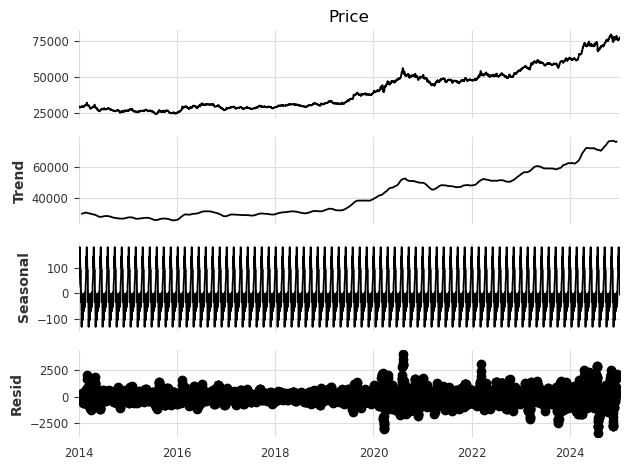

In [18]:
decompose_plot_additive = seasonal_decompose(gold_price.Price, model='additive', period=52)
decompose_plot_additive.plot()
plt.show()

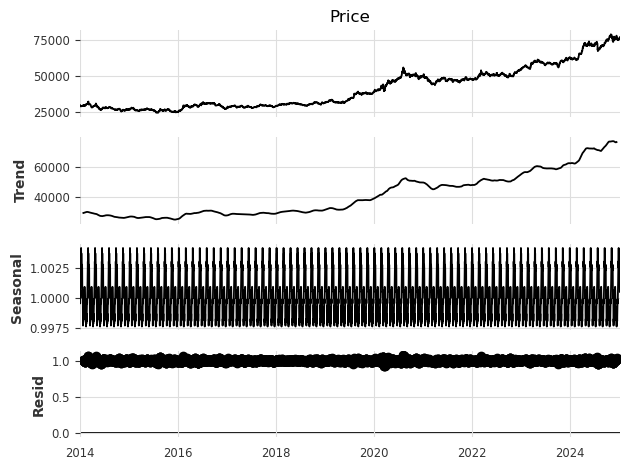

In [19]:
decompose_plot_multiplicative = seasonal_decompose(gold_price.Price, model='multiplicative', period=52)
decompose_plot_multiplicative.plot()
plt.show()

We can see that is multiplicative by the residuals, in the additive models they grow up with the time.

So, we will have to apply `log` to our serie in a future.

### Feature Engineering

In [20]:
import holidays

In [21]:
start_year = gold_price.index.min().year
end_year = gold_price.index.max().year

us_holidays = holidays.UnitedStates(years=range(start_year, end_year + 1))
uk_holidays = holidays.UnitedKingdom(years=range(start_year, end_year + 1))

combined = set(us_holidays.keys()) | set(uk_holidays.keys())

idx_dates = gold_price.index.normalize().date
gold_price["is_holiday"] = [1 if d in combined else 0 for d in idx_dates]

holiday_list = sorted(list(combined))

def days_to_next(date_val: pd.Timestamp) -> int:
    for h in holiday_list:
        if h >= date_val:
            return (h - date_val).days
    return np.nan
    
gold_price['days_to_next_holiday'] = [days_to_next(d) for d in idx_dates]

gold_price.loc[:, "is_weekend"] = (gold_price.index.weekday >= 5).astype(int)

gold_price.head(10)

Price  is_holiday  days_to_next_holiday  is_weekend
2014-01-01  29542.0           1                     0           0
2014-01-02  29975.0           0                    18           0
2014-01-03  29727.0           0                    17           0
2014-01-04  29279.0           0                    16           1
2014-01-05  29279.0           0                    15           1
2014-01-06  29119.0           0                    14           0
2014-01-07  28959.0           0                    13           0
2014-01-08  28934.0           0                    12           0
2014-01-09  28997.0           0                    11           0
2014-01-10  29169.0           0                    10           0

In [22]:
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

### Create train and test sets for time series

In [23]:
timesteps = gold_price.index.to_numpy()
price = gold_price.Price.to_numpy()

In [24]:
# Create train and test splits, 80% train, 20% test
# split_size = int(0.8 * len(price))
split_size = -37

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:2*split_size], price[:2*split_size]

# Create validation data splits (everything before the split)
X_val, y_val = timesteps[2*split_size:split_size], price[2*split_size:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], price[split_size:]

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

len(X_train), len(y_train), len(X_test), len(y_test)

(3950, 3950, 37, 37)

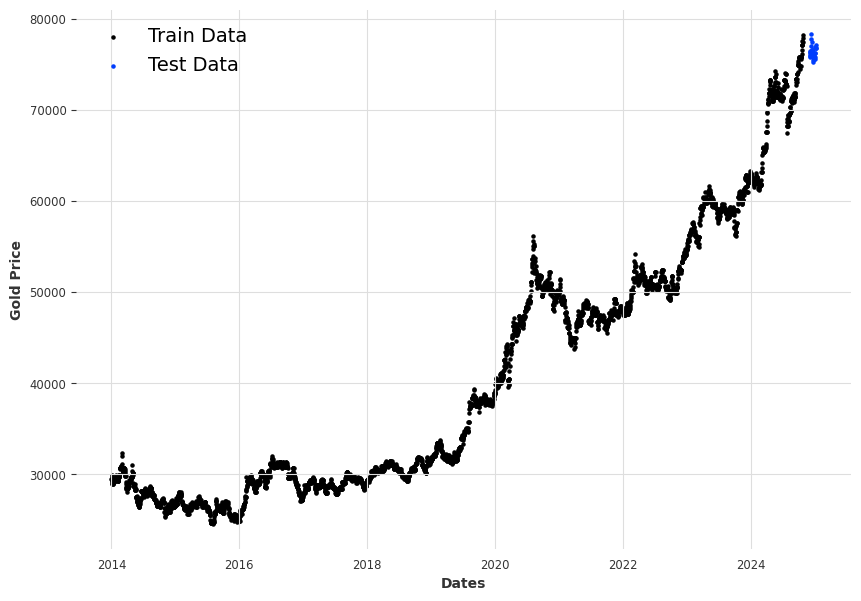

In [25]:
# Plot with train and test
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel('Dates')
plt.ylabel('Gold Price')
plt.legend(fontsize=14)
plt.show()

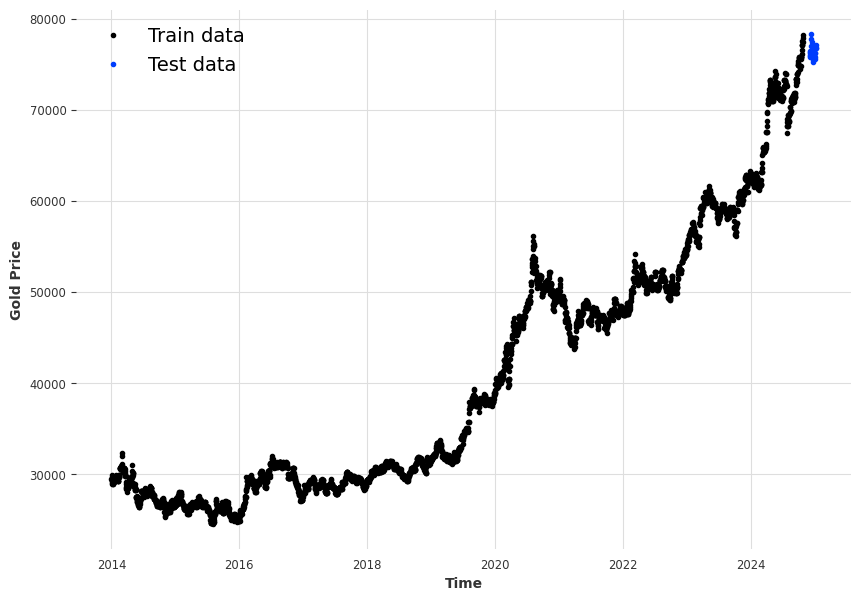

In [26]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data", xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_test, values=y_test, label="Test data", xlabel='Time', ylabel='Gold Price')

## Baselines Models

### Baseline 0: Naive Forecast

$$\hat{y}_{t+1} = y_t$$

In [27]:
# Create a naive forecast
naive_preds = y_test[:-1]
naive_preds[:5]

array([76485., 75815., 75934., 76036., 76353.])

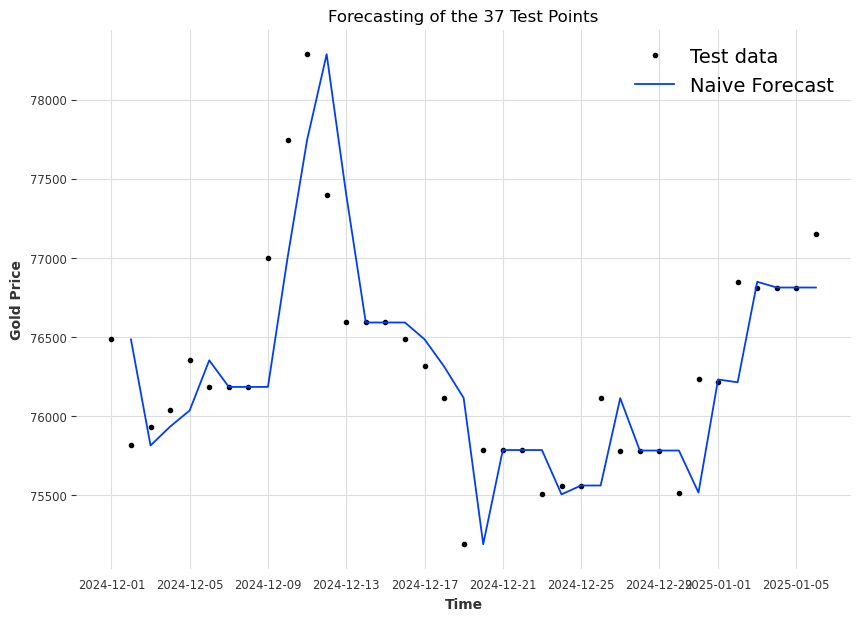

In [28]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test[1:], values=naive_preds, format='-', label='Naive Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points')
plt.show()

In [29]:
naive_metrics = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_preds)
naive_metrics

{'mae': np.float32(288.72223),
 'mse': np.float32(178845.33),
 'rmse': np.float32(422.9011),
 'mape': np.float32(0.3774737)}

### Baseline 1: ARIMA

Bibliography: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

* **AR (Autoregression):** This emphasizes the dependent relationship between an observation and its preceding or 'lagged' observations.
* **I (Integrated):** To achieve a stationary time series, one that doesn't exhibit trend or seasonality, differencing is applied. It typically involves subtracting an observation from its preceding observation.
* **MA (Moving Average):** This component zeroes in on the relationship between an observation and the residual error from a moving average model based on lagged observations.

In [30]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot

#### Stationarity

We first need to apply logarithms to the serie, because we saw that it was a multiplicative model.

In [31]:
log_gold_price = np.log(gold_price.Price)
log_gold_price.head()

2014-01-01    10.293568
2014-01-02    10.308119
2014-01-03    10.299811
2014-01-04    10.284626
2014-01-05    10.284626
Freq: D, Name: Price, dtype: float64

In [32]:
# Check for stationarity (mean and variance constant)
adf = adfuller(log_gold_price)
print(f'ADF p-value: {adf[1]}')

ADF p-value: 0.9911734545221276


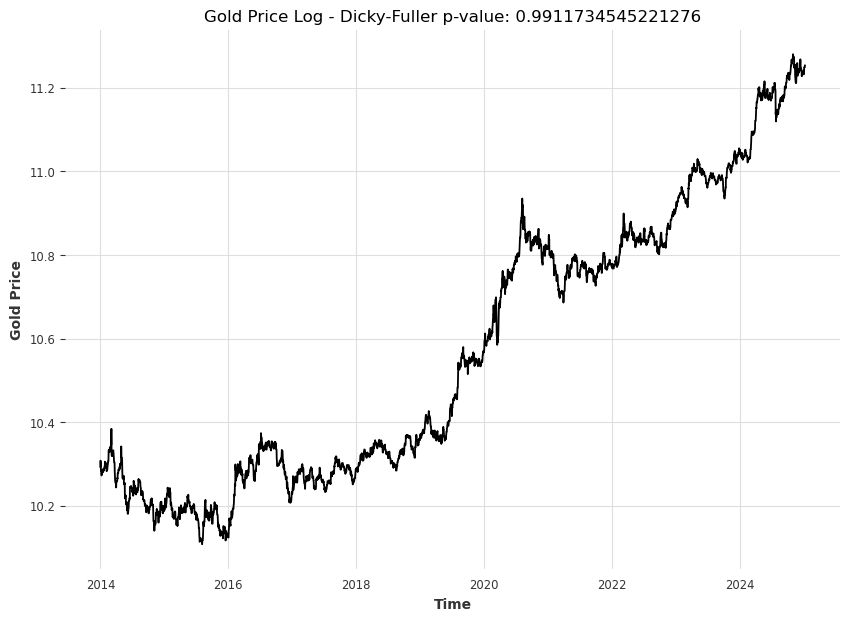

In [33]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price.index,
                 values=log_gold_price.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price')
plt.title(f'Gold Price Log - Dicky-Fuller p-value: {adf[1]}')
plt.show()

In [34]:
# We have to differentiate, because the p-value was greater than 0.05
log_gold_price_stationarity = log_gold_price.diff().dropna()
adf_diff = adfuller(log_gold_price_stationarity)
print(f'ADF p-value with 1 differentation: {adf_diff[1]}')

ADF p-value with 1 differentation: 2.8469869896195193e-30


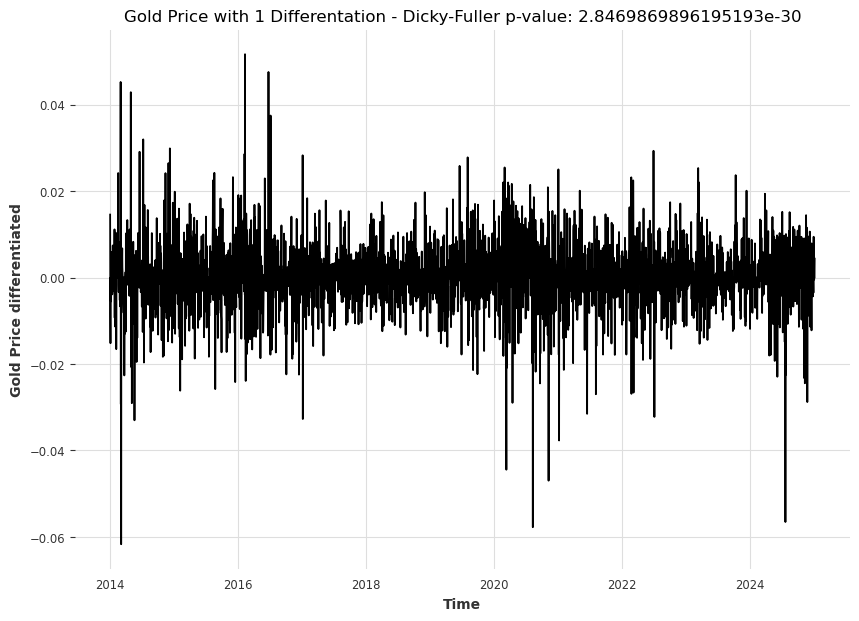

In [35]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price_stationarity.index,
                 values=log_gold_price_stationarity.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price differentiated')
plt.title(f'Gold Price with 1 Differentation - Dicky-Fuller p-value: {adf_diff[1]}')
plt.show()

#### ACF and PACF

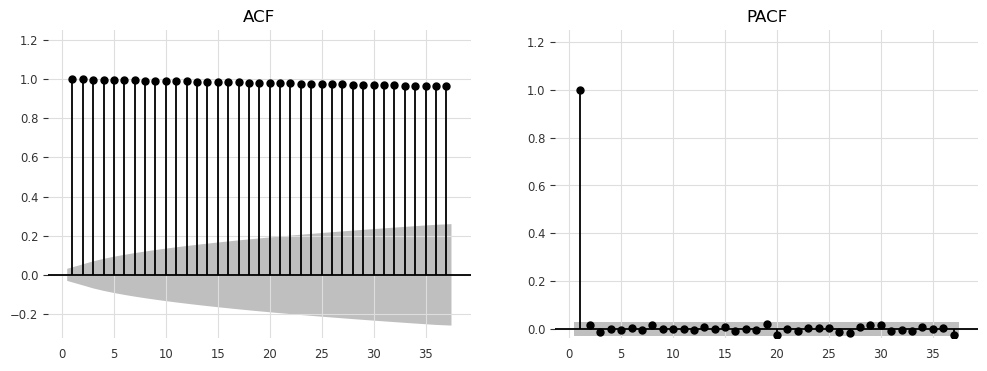

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(gold_price.Price, ax=axes[0], zero=False, auto_ylims=True, title='ACF')
plot_pacf(gold_price.Price, ax=axes[1], zero=False, auto_ylims=True, title='PACF')
plt.show()

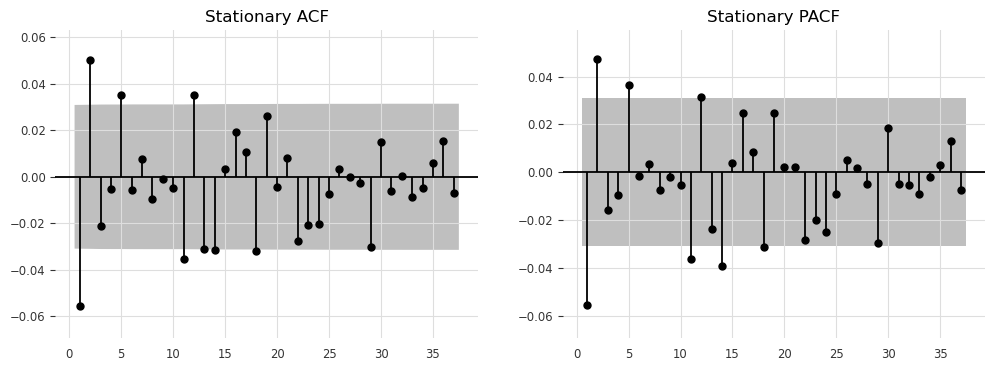

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(log_gold_price_stationarity, ax=axes[0], zero=False, auto_ylims=True, title='Stationary ACF')
plot_pacf(log_gold_price_stationarity, ax=axes[1], zero=False, auto_ylims=True, title='Stationary PACF')
plt.show()

We can try the next models:

* `ARIMA(0, 1, 0)` - **Random Walk**
* `ARIMA(1, 1, 0)`
* `ARIMA(1, 1, 1)`
* `ARIMA(1, 1, 2)`

#### Create Model

In [38]:
log_gold_price_train = pd.Series(np.log(y_train), index=pd.DatetimeIndex(X_train, freq='D'))
log_gold_price_val = pd.Series(np.log(y_val), index=pd.DatetimeIndex(X_val, freq='D'))
log_gold_price_train_val = pd.Series(np.log(y_train_val), index=pd.DatetimeIndex(X_train_val, freq='D'))
log_gold_price_test = pd.Series(np.log(y_test), index=pd.DatetimeIndex(X_test, freq='D'))

In [39]:
model_arima_010 = ARIMA(log_gold_price_train_val, order=(0, 1, 0))
model_arima_110 = ARIMA(log_gold_price_train_val, order=(1, 1, 0))
model_arima_111 = ARIMA(log_gold_price_train_val, order=(1, 1, 1))
model_arima_112 = ARIMA(log_gold_price_train_val, order=(1, 1, 2))
model_arima_212 = ARIMA(log_gold_price_train_val, order=(2, 1, 2))

results_arima_010 = model_arima_010.fit()
results_arima_110 = model_arima_110.fit()
results_arima_111 = model_arima_111.fit()
results_arima_112 = model_arima_112.fit()
results_arima_212 = model_arima_212.fit()

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [40]:
results_arima_010.aic, results_arima_110.aic, results_arima_111.aic, results_arima_112.aic, results_arima_212.aic

(np.float64(-28236.047379327923),
 np.float64(-28246.130913028406),
 np.float64(-28248.629395350847),
 np.float64(-28251.841382477345),
 np.float64(-28252.313029657074))

The best ARIMA model looking at the AIC metric is: `ARIMA(1, 1, 2)`.

#### Make Predictions

Now, we will make the predictions using the **walk-forward** technique.

In [41]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [42]:
history = list(log_gold_price_train_val)
arima_preds = []
for obs in log_gold_price_test:
    model = ARIMA(history, order=(1, 1, 2))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        results = model.fit()
    log_pred = results.forecast()[0]
    arima_preds.append(np.exp(log_pred))
    history.append(obs) # take in the real observation

#### Evaluate Predicts

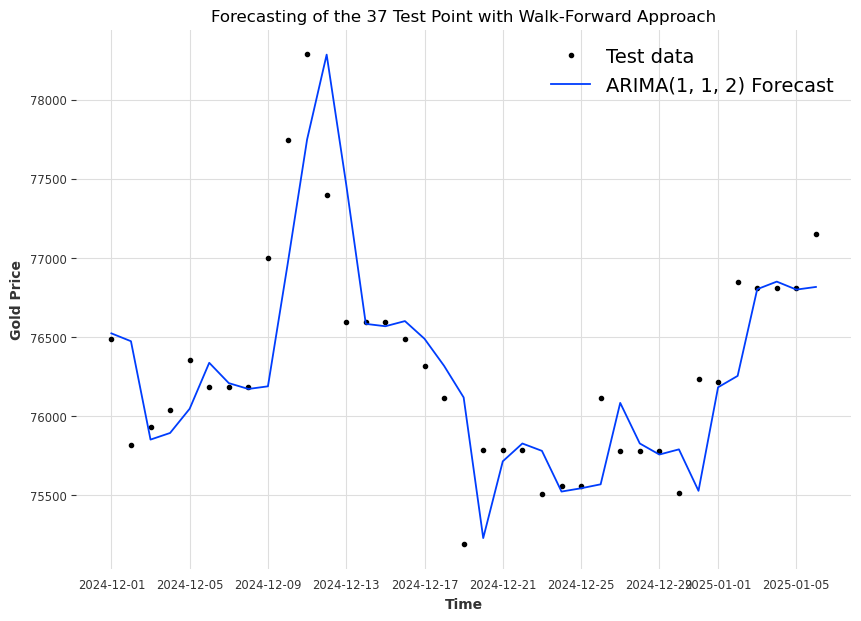

In [43]:
# Plot ARIMA(1, 1, 2) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=arima_preds, format='-', label='ARIMA(1, 1, 2) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Point with Walk-Forward Approach')
plt.show()

In [44]:
arima_metrics = evaluate_preds(y_true=y_test,
                               y_pred=arima_preds)
arima_metrics

{'mae': np.float32(288.50107),
 'mse': np.float32(174503.95),
 'rmse': np.float32(417.7367),
 'mape': np.float32(0.3772017)}

In [45]:
log_pred_arima_direct = results_arima_112.get_forecast(steps=37)
pred_arima_direct = np.exp(log_pred_arima_direct.predicted_mean).values
arima_direct_metrics = evaluate_preds(y_true=y_test, y_pred=pred_arima_direct)
arima_direct_metrics

{'mae': np.float32(557.6049),
 'mse': np.float32(464161.5),
 'rmse': np.float32(681.294),
 'mape': np.float32(0.7308145)}

### Baseline 2: SARIMAX

Our TS is anual stational, so we would need to look at the lags 365, 730 and so on, if we want to know the parameters P and Q of the model ``SARIMAX(p, d, q)x(P, D, Q, m)``. Therefore, we will use grid search to compute the best parameters. We will try the next models:

* ``SARIMAX(0, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 2, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 2, 365)``

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Exogenus variables

First of all, we have to load, clean, transform and put all the exogenus variables into the `gold_price` dataframe.

In [47]:
from utils.load import load_csv_into_dates, load_csv_and_glue_time_series

In [48]:
folder_exogenus_gold_variables = os.path.join(os.getcwd(), '..', 'data', 'exogenus_gold')

##### BRENT

In [49]:
brent = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'brent', 'brent-daily.csv'))
brent.index.min(), brent.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

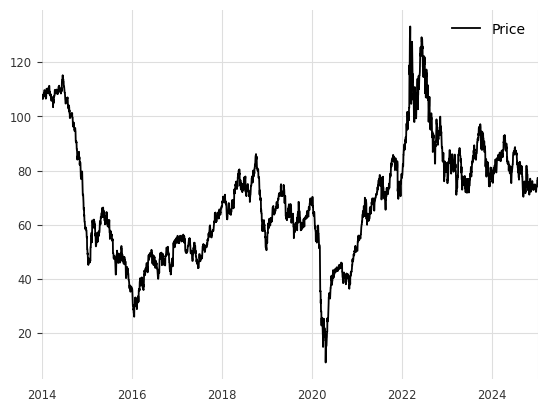

In [50]:
brent.plot()

##### WTI

In [51]:
wti = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'wti', 'wti-daily.csv'))
wti.index.min(), wti.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [52]:
wti[wti.values < 0]

Price
2020-04-18 -36.98
2020-04-19 -36.98
2020-04-20 -36.98

<Axes: >

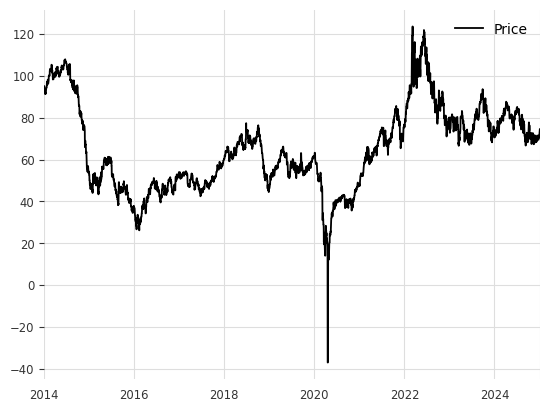

In [53]:
wti.plot()

##### DXY - Dollar Index

In [54]:
folder_dxy = os.path.join(folder_exogenus_gold_variables, 'DXY')
dxy = load_csv_and_glue_time_series(folder_path=folder_dxy, column_name='Open')
dxy.index.min(), dxy.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

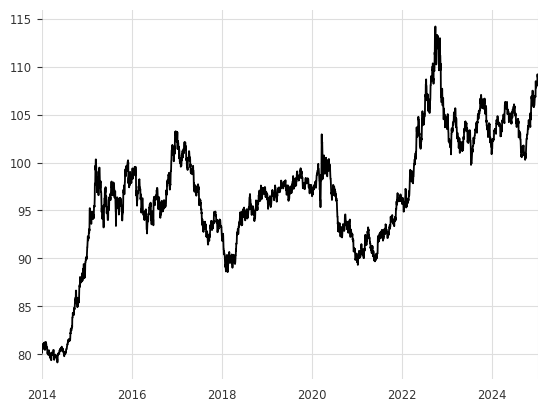

In [55]:
dxy.plot()

##### EURUSD

In [56]:
eurusd = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'EURUSD', 'EURUSD_D1.csv'), header=None)
eurusd = eurusd.iloc[:, 0]
eurusd.index.min(), eurusd.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

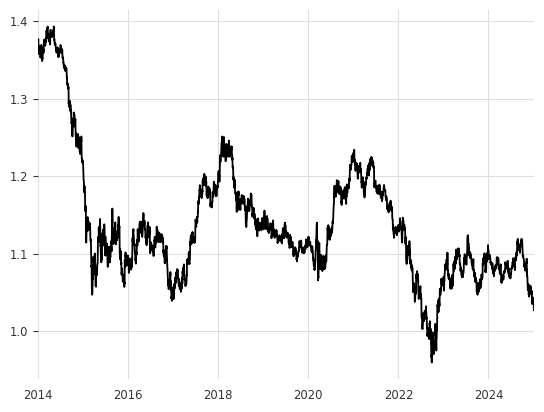

In [57]:
eurusd.plot()

##### VIX

In [58]:
vix = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'VIX', 'VIX_history.csv'),
                          column_name='OPEN')
vix.index.min(), vix.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

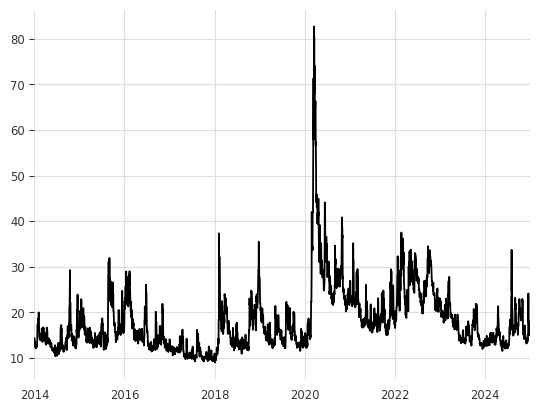

In [59]:
vix.plot()

##### S&P 500

In [60]:
sp500 = load_csv_and_glue_time_series(folder_path=os.path.join(folder_exogenus_gold_variables, 'SP500'),
                                      column_name='Open')
sp500.index.min(), sp500.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

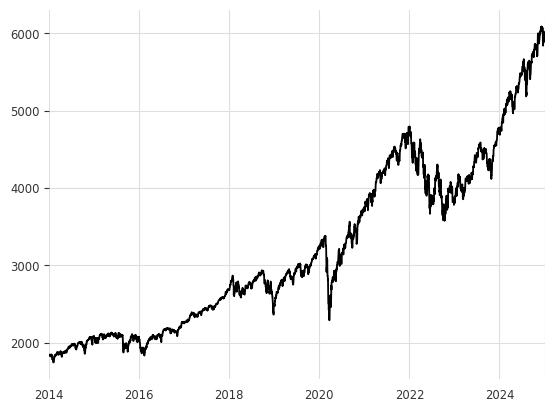

In [61]:
sp500.plot()

##### T5YIE

In [62]:
t5yie = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'T5YIE', 'T5YIE.csv'),
                            column_name='Open')
fecha_01_01_2014 = t5yie.index[0] - pd.Timedelta(days=1)
valor_01_01_2014 = t5yie.iloc[0]
t5yie = pd.concat([
    pd.Series([valor_01_01_2014], index=[fecha_01_01_2014]),
    t5yie
])
t5yie.index.min(), t5yie.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

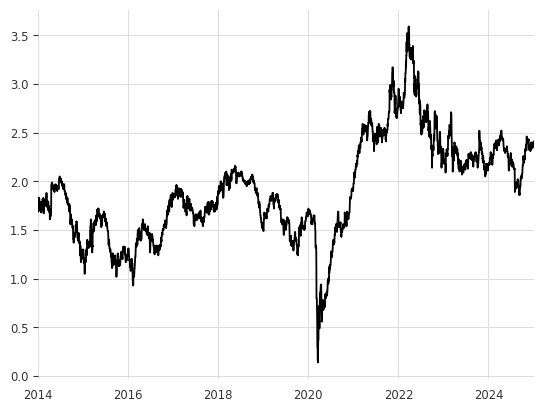

In [63]:
t5yie.plot()

##### T10YIE

In [64]:
t10yie = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'T10YIE', 'T10YIE.csv'),
                            column_name='Open')
fecha_01_01_2014 = t10yie.index[0] - pd.Timedelta(days=1)
valor_01_01_2014 = t10yie.iloc[0]
t10yie = pd.concat([
    pd.Series([valor_01_01_2014], index=[fecha_01_01_2014]),
    t10yie
])
t10yie.index.min(), t10yie.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

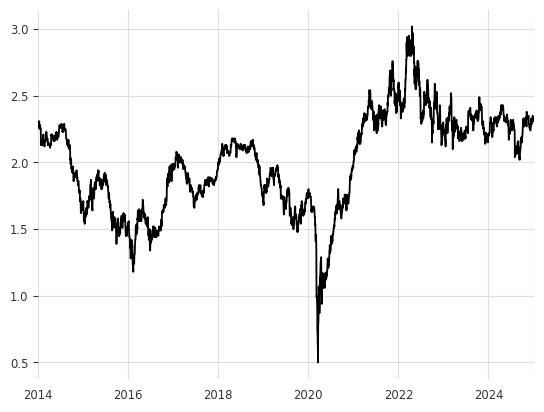

In [65]:
t10yie.plot()

#### Preparing data with Exogenus Variables

In [66]:
gold_price['brent'] = brent
gold_price['wti'] = wti
gold_price['dxy'] = dxy
gold_price['vix'] = vix
gold_price['eurusd'] = eurusd
gold_price['sp500'] = sp500
gold_price['t5yie'] = t5yie
gold_price.head()

Price  is_holiday  days_to_next_holiday  is_weekend   brent  \
2014-01-01  29542.0           1                     0           0  107.94   
2014-01-02  29975.0           0                    18           0  107.94   
2014-01-03  29727.0           0                    17           0  106.57   
2014-01-04  29279.0           0                    16           1  106.71   
2014-01-05  29279.0           0                    15           1  106.71   

              wti    dxy    vix   eurusd        sp500  t5yie  
2014-01-01  95.14  80.21  14.32  1.37553  1845.859985   1.71  
2014-01-02  95.14  80.12  14.32  1.37653  1845.859985   1.71  
2014-01-03  93.66  80.57  14.06  1.36653  1833.209961   1.69  
2014-01-04  93.12  80.86  13.41  1.35935  1832.310059   1.75  
2014-01-05  93.12  80.86  13.41  1.35935  1832.310059   1.75

We need to separate our exogenus variables from our raw gold_price dataframe. Furthermore, we will need also to split in train and test this new dataset.

In [67]:
exog_data = gold_price.reset_index().drop(columns=['index', 'Price'])
exog_data.head()

is_holiday  days_to_next_holiday  is_weekend   brent    wti    dxy    vix  \
0           1                     0           0  107.94  95.14  80.21  14.32   
1           0                    18           0  107.94  95.14  80.12  14.32   
2           0                    17           0  106.57  93.66  80.57  14.06   
3           0                    16           1  106.71  93.12  80.86  13.41   
4           0                    15           1  106.71  93.12  80.86  13.41   

    eurusd        sp500  t5yie  
0  1.37553  1845.859985   1.71  
1  1.37653  1845.859985   1.71  
2  1.36653  1833.209961   1.69  
3  1.35935  1832.310059   1.75  
4  1.35935  1832.310059   1.75

In [68]:
exog_train = exog_data.iloc[:2*split_size, :]
exog_val = exog_data.iloc[2*split_size:split_size, :]
exog_train_val = pd.concat([exog_train, exog_val])
exog_test = exog_data.iloc[split_size:, :]

exog_train.shape, exog_val.shape, exog_train_val.shape, exog_test.shape

((3950, 10), (37, 10), (3987, 10), (37, 10))

We also need to transform our 'anual seasonality' in terms of **Fourier** for agilize the computation, and get rid of the seasonality in SARIMAX.

In [69]:
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

In [70]:
fourier_gen = FourierFeaturizer(m=365.25, k=4)
log_gold_price_fourier, exog_data_fourier = fourier_gen.fit_transform(log_gold_price.values, exog_data)

exog_train_fourier = exog_data_fourier.iloc[:2*split_size, :]
exog_val_fourier = exog_data_fourier.iloc[2*split_size:split_size, :]
exog_train_val_fourier = pd.concat([exog_train_fourier, exog_val_fourier])
exog_test_fourier = exog_data_fourier.iloc[split_size:, :]

exog_train_fourier.shape, exog_val_fourier.shape, exog_train_val_fourier.shape, exog_test_fourier.shape

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



((3950, 18), (37, 18), (3987, 18), (37, 18))

#### Create Model

In [71]:
# Exogenus without Fourier and without seasonality

model_sarimax_010_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))
model_sarimax_212_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_365 = model_sarimax_010_000_365.fit()
results_sarimax_110_000_365 = model_sarimax_110_000_365.fit()
results_sarimax_111_000_365 = model_sarimax_111_000_365.fit()
results_sarimax_112_000_365 = model_sarimax_112_000_365.fit()
results_sarimax_212_000_365 = model_sarimax_212_000_365.fit()

results_sarimax_010_000_365.aic, results_sarimax_110_000_365.aic, results_sarimax_111_000_365.aic, results_sarimax_112_000_365.aic, results_sarimax_212_000_365.aic

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



(np.float64(-28258.81917047356),
 np.float64(-28276.985655355966),
 np.float64(-28278.526195146987),
 np.float64(-28279.888343391303),
 np.float64(-5931.6033544619695))

In [72]:
# Exogenus without Fourier, but with seasonality

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore", category=FutureWarning)
    model_sarimax_auto = auto_arima(
        y=log_gold_price_train_val,
        exogenus=exog_train_val,
        seasonal=True,
        m=52,
        stepwise=True,
        suppress_warnings=True,
        trace=False
    )

model_sarimax_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3987
Model:               SARIMAX(2, 1, 2)   Log Likelihood               14133.488
Date:                Thu, 25 Sep 2025   AIC                         -28254.976
Time:                        09:49:32   BIC                         -28217.233
Sample:                    01-01-2014   HQIC                        -28241.595
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      2.195      0.028    7.23e-05       0.001
ar.L1         -1.1518      0.150     -7.691      0.000      -1.445      -0.858
ar.L2         -0.6531      0.107     -6.084      0.000      -0.864      -0.443
ma.L1          1.0986      0.147      7.449      0.000       0.810       1.388
ma.L2          0.6448      0.101      6.381      0.000       0.447       0.843
sigma2      4.869e-05   4.95e-07     98.278      0.000    4.77e-05    4.97e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13091.05
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
# Exogenus with Fourier

model_sarimax_010_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))
model_sarimax_212_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_fourier = model_sarimax_010_000_fourier.fit()
results_sarimax_110_000_fourier = model_sarimax_110_000_fourier.fit()
results_sarimax_111_000_fourier = model_sarimax_111_000_fourier.fit()
results_sarimax_112_000_fourier = model_sarimax_112_000_fourier.fit()
results_sarimax_212_000_fourier = model_sarimax_212_000_fourier.fit()

results_sarimax_010_000_fourier.aic, results_sarimax_110_000_fourier.aic, results_sarimax_111_000_fourier.aic, results_sarimax_112_000_fourier.aic, results_sarimax_212_000_fourier.aic

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(np.float64(-28252.679195734185),
 np.float64(-28271.461850238567),
 np.float64(-28272.642984480557),
 np.float64(-28273.127557563363),
 np.float64(-28102.970070546908))

The model with lowest AIC is `SARIMAX(1, 1, 2)x(0, 0, 0, 0)` without seasonality nor Fourier's features.

#### Make Predictions

In [74]:
history = list(log_gold_price_train_val.values)
sarimax_preds = []

for i in range(len(log_gold_price_test)):

    model = SARIMAX(
        endog=history,
        exog=exog_data.iloc[:len(history)],
        order=(1, 1, 2),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        results = model.fit(disp=False)

    log_pred = results.forecast(steps=1, exog=exog_test.iloc[i:i+1])
    sarimax_preds.append(np.exp(log_pred))

    history.append(log_gold_price_test.values[i])

#### Evaluate Predicts

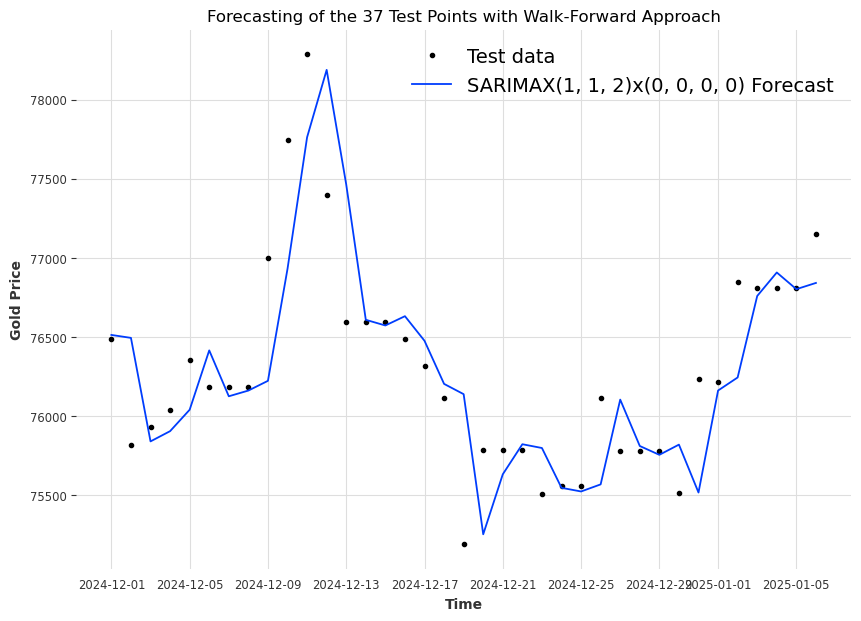

In [75]:
# Plot SARIMAX(1, 1, 2) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=sarimax_preds, format='-', label='SARIMAX(1, 1, 2)x(0, 0, 0, 0) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with Walk-Forward Approach')
plt.show()

In [76]:
sarimax_metrics = evaluate_preds(y_true=y_test,
                                 y_pred=sarimax_preds)
sarimax_metrics

{'mae': np.float32(697.0188),
 'mse': np.float32(818114.1),
 'rmse': np.float32(904.49664),
 'mape': np.float32(0.9114891)}

In [77]:
log_pred_sarimax_direct = results_sarimax_112_000_365.get_forecast(steps=37, exog=exog_test)
pred_sarimax_direct = np.exp(log_pred_sarimax_direct.predicted_mean).values
sarimax_direct_metrics = evaluate_preds(y_true=y_test, y_pred=pred_sarimax_direct)
sarimax_direct_metrics

{'mae': np.float32(518.5511),
 'mse': np.float32(401148.6),
 'rmse': np.float32(633.3629),
 'mape': np.float32(0.67884296)}

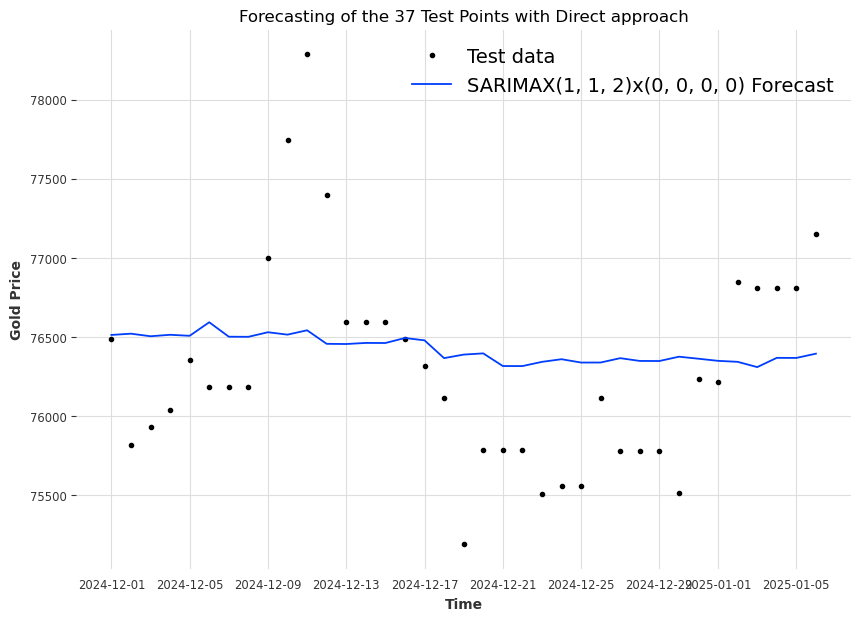

In [78]:
# Plot SARIMAX(1, 1, 2) forecast direct
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=pred_sarimax_direct, format='-', label='SARIMAX(1, 1, 2)x(0, 0, 0, 0) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 37 Test Points with Direct approach')
plt.show()

### Final Results for Baseline Models

| Metrics / Baselines | Naive | ARIMA | SARIMAX |
|----------------|-----------|-----------|-----------|
| MAE  | 288.35  | 288.72  | 697.02  |
| MSE  | 174403.08  | 178845.33  | 818114.06  |
| RMSE  | 422.90  | 417.62  | 861.11  |
| MAPE  | 0.38  | 0.38  | 0.91  |


## Main Models

### Make Windows

First of all, we need to transform our Forecasting Time Series problem in a Supervised Prediction problem. So, the technique that we are going to use is make windows (we will try differnt window's sizes), and use this windows like a features where our model is trained on, and the last element will be the `y` that we are trying to predict.

In [79]:
from utils.windows import make_windows

In [80]:
WINDOW_SIZE = 30
HORIZON = 1

We have to include the exogenus variables into the window-format.

In [81]:
index = pd.date_range(start='2014-01-01', periods=len(gold_price)-1, freq='D')[WINDOW_SIZE-1:]
first_iter = True
for var in gold_price.columns.values:
    columns_var = [f'{var}_{i+1}' for i in range(WINDOW_SIZE)]
    if var == 'Price':
        full_windows, full_labels = make_windows(gold_price[var], window_size=WINDOW_SIZE, horizon=HORIZON)
    else:
        full_windows, _ = make_windows(gold_price[var], window_size=WINDOW_SIZE, horizon=HORIZON)
    if first_iter:
        df = pd.DataFrame(full_windows, columns=columns_var, index=index)
        first_iter = False
        continue
    df2 = pd.DataFrame(full_windows, columns=columns_var, index=index)
    df = pd.concat([df, df2], axis=1)

In [82]:
gold_price_windowed = df.copy()
gold_price_windowed.head()

Price_1  Price_2  Price_3  Price_4  Price_5  Price_6  Price_7  \
2014-01-30  29542.0  29975.0  29727.0  29279.0  29279.0  29119.0  28959.0   
2014-01-31  29975.0  29727.0  29279.0  29279.0  29119.0  28959.0  28934.0   
2014-02-01  29727.0  29279.0  29279.0  29119.0  28959.0  28934.0  28997.0   
2014-02-02  29279.0  29279.0  29119.0  28959.0  28934.0  28997.0  29169.0   
2014-02-03  29279.0  29119.0  28959.0  28934.0  28997.0  29169.0  29169.0   

            Price_8  Price_9  Price_10  ...  t5yie_21  t5yie_22  t5yie_23  \
2014-01-30  28934.0  28997.0   29169.0  ...      1.71      1.79      1.72   
2014-01-31  28997.0  29169.0   29169.0  ...      1.79      1.72      1.68   
2014-02-01  29169.0  29169.0   29169.0  ...      1.72      1.68      1.72   
2014-02-02  29169.0  29169.0   29312.0  ...      1.68      1.72      1.72   
2014-02-03  29169.0  29312.0   29198.0  ...      1.72      1.72      1.72   

            t5yie_24  t5yie_25  t5yie_26  t5yie_27  t5yie_28  t5yie_29  \
2014-01-30      1.68      1.72      1.72      1.72      1.71      1.72   
2014-01-31      1.72      1.72      1.72      1.71      1.72      1.76   
2014-02-01      1.72      1.72      1.71      1.72      1.76      1.72   
2014-02-02      1.72      1.71      1.72      1.76      1.72      1.70   
2014-02-03      1.71      1.72      1.76      1.72      1.70      1.70   

            t5yie_30  
2014-01-30      1.76  
2014-01-31      1.72  
2014-02-01      1.70  
2014-02-02      1.70  
2014-02-03      1.70  

[5 rows x 330 columns]

Before continuing, we have to remove all calendar variables from 1 to 29, and only stay with the 30th.

In [83]:
calendar_vars = ["is_weekend", "is_holiday", "days_to_next_holiday"]
keep_cols = []
for var in calendar_vars:
    keep_cols.append(f"{var}_{WINDOW_SIZE}")

for col in gold_price_windowed.columns:
    if not any(col.startswith(var) for var in calendar_vars):
        keep_cols.append(col)

gold_price_windowed = gold_price_windowed[keep_cols]
len(gold_price_windowed.columns.values)

243

In [84]:
# Turning windows into training and tests sets
train_gold_price_windowed = gold_price_windowed[:2*split_size]
val_gold_price_windowed = gold_price_windowed[2*split_size:split_size]
test_gold_price_windowed = gold_price_windowed[split_size:]

train_labels = full_labels[:2*split_size]
val_labels = full_labels[2*split_size:split_size]
test_labels = full_labels[split_size:]

len(train_gold_price_windowed), len(val_gold_price_windowed), len(test_gold_price_windowed), len(train_labels), len(val_labels), len(test_labels)

(3920, 37, 37, 3920, 37, 37)

In [85]:
train_val_gold_price_windowed = pd.concat([train_gold_price_windowed, val_gold_price_windowed])
train_val_labels = np.concatenate((train_labels, val_labels))

### LightGBM

In [86]:
import lightgbm as lgb

In [87]:
df_models_metrics_lightgbm = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [88]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=0,
    reg_alpha=0,
    random_state=42,
    verbose=-1
)

model_lightgbm.name = "Default Model"

model_lightgbm.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse')

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



LGBMRegressor(colsample_bytree=1, min_split_gain=0, objective='regression',
              random_state=42, reg_alpha=0, reg_lambda=0, subsample=1,
              verbose=-1)

##### Make Predictions

In [89]:
pred_lightgbm = model_lightgbm.predict(val_gold_price_windowed)
pred_train_lightgbm = model_lightgbm.predict(train_gold_price_windowed)

##### Evaluate Predictions

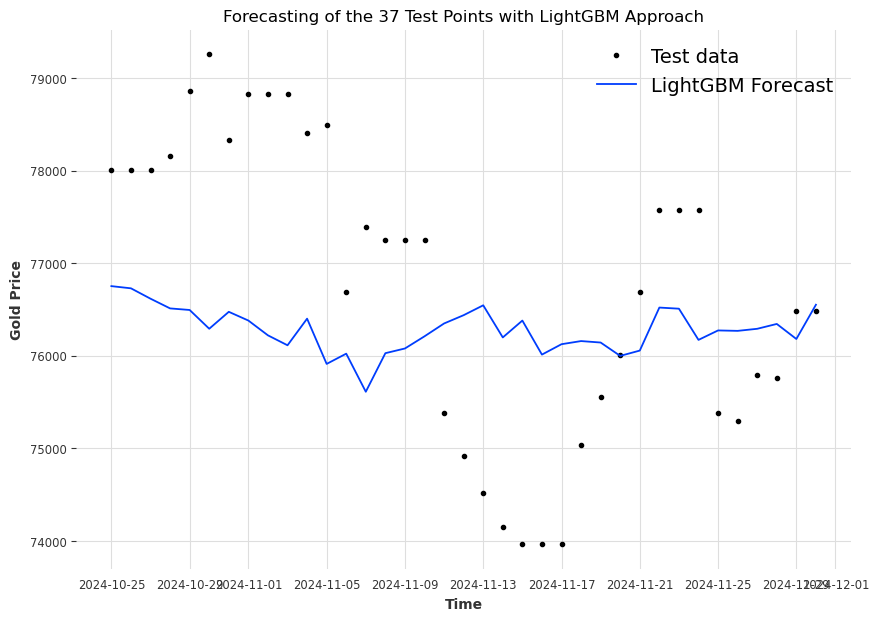

In [90]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [91]:
lightgbm_metrics = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(1442.8066),
 'mse': np.float32(2675549.5),
 'rmse': np.float32(1635.7107),
 'mape': np.float32(1.8748409)}

##### Evaluate Overfitting

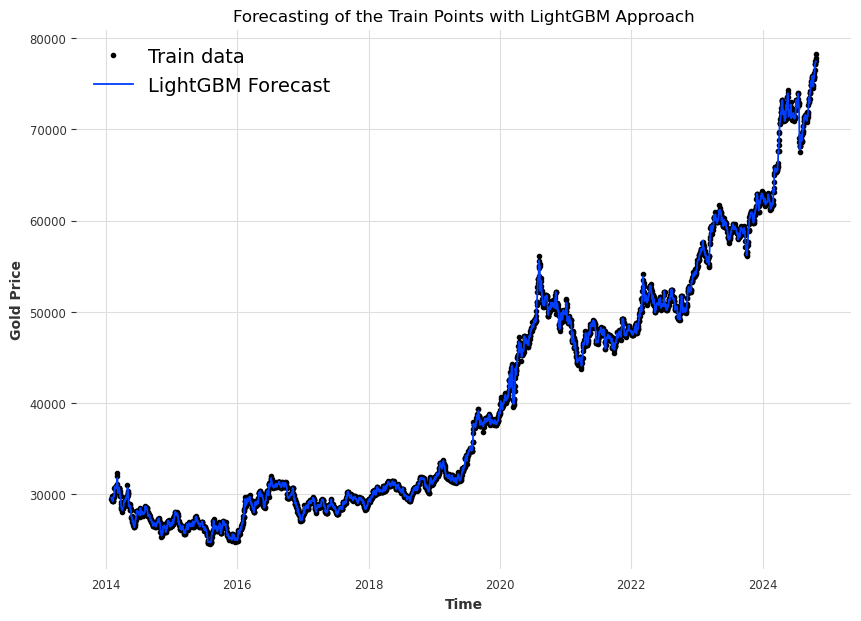

In [92]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=y_train[WINDOW_SIZE:], label="Train data")
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=pred_train_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [93]:
lightgbm_metrics_train = evaluate_preds(y_true=y_train[WINDOW_SIZE:],
                                        y_pred=pred_train_lightgbm)
lightgbm_metrics_train

{'mae': np.float32(117.799706),
 'mse': np.float32(29763.072),
 'rmse': np.float32(172.51978),
 'mape': np.float32(0.3070611)}

##### Persist Metrics

In [94]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train['mape'],
        "Val MAPE": lightgbm_metrics['mape'],
        "Train RMSE": lightgbm_metrics_train['rmse'],
        "Val RMSE": lightgbm_metrics['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22108\3944565183.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [95]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=50,
    learning_rate=0.2,
    num_leaves=21,
    max_depth=4,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=30,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=0,
    reg_alpha=0,
    random_state=42,
    verbose=-1
)

model_lightgbm.name = 'Small Model'

model_lightgbm.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse')

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



LGBMRegressor(colsample_bytree=1, learning_rate=0.2, max_depth=4,
              min_child_samples=30, min_split_gain=0, n_estimators=50,
              num_leaves=21, objective='regression', random_state=42,
              reg_alpha=0, reg_lambda=0, subsample=1, verbose=-1)

##### Make Predictions

In [96]:
pred_lightgbm = model_lightgbm.predict(val_gold_price_windowed)
pred_train_lightgbm = model_lightgbm.predict(train_gold_price_windowed)

##### Evaluate Predictions

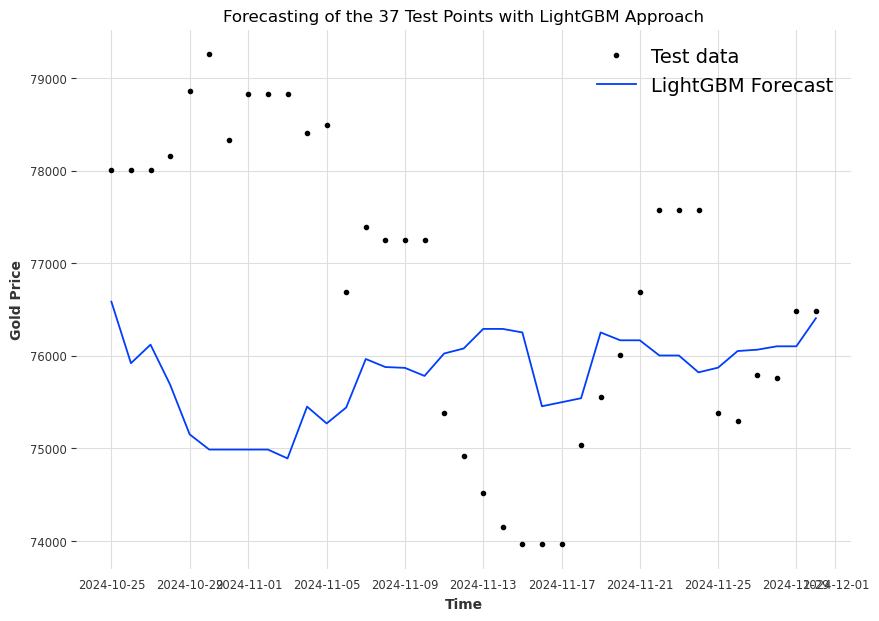

In [97]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [98]:
lightgbm_metrics = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(1730.2783),
 'mse': np.float32(4388501.0),
 'rmse': np.float32(2094.875),
 'mape': np.float32(2.2354949)}

##### Evaluate Overfitting

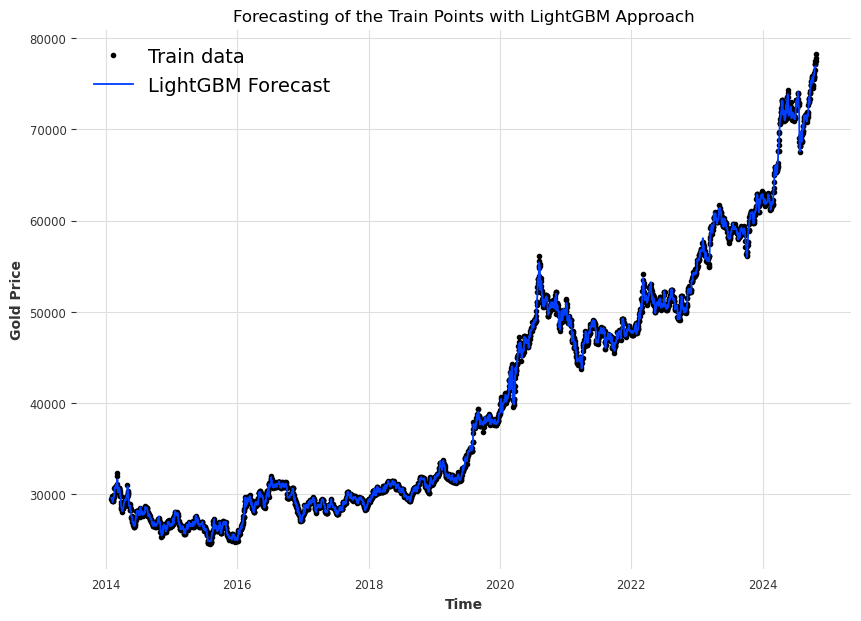

In [99]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=y_train[WINDOW_SIZE:], label="Train data")
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=pred_train_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [100]:
lightgbm_metrics_train = evaluate_preds(y_true=y_train[WINDOW_SIZE:],
                                        y_pred=pred_train_lightgbm)
lightgbm_metrics_train

{'mae': np.float32(172.44725),
 'mse': np.float32(64521.004),
 'rmse': np.float32(254.00986),
 'mape': np.float32(0.43617082)}

##### Persist Metrics

In [101]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train['mape'],
        "Val MAPE": lightgbm_metrics['mape'],
        "Train RMSE": lightgbm_metrics_train['rmse'],
        "Val RMSE": lightgbm_metrics['rmse']
    }])
], ignore_index=True)

#### Regularized Model

##### Create Model

In [102]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0.1,
    random_state=42,
    verbose=-1
)

model_lightgbm.name = "Regularized Model"

model_lightgbm.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse')

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



LGBMRegressor(colsample_bytree=0.8, min_split_gain=0, objective='regression',
              random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=0.8,
              verbose=-1)

##### Make Predictions

In [103]:
pred_lightgbm = model_lightgbm.predict(val_gold_price_windowed)
pred_train_lightgbm = model_lightgbm.predict(train_gold_price_windowed)

##### Evaluate Predictions

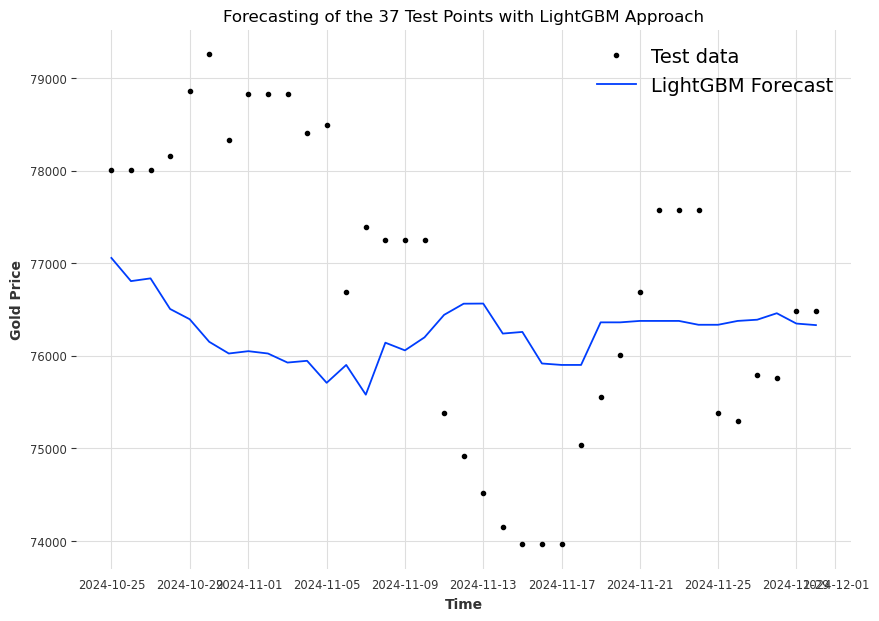

In [104]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [105]:
lightgbm_metrics = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(1490.77),
 'mse': np.float32(2895976.8),
 'rmse': np.float32(1701.757),
 'mape': np.float32(1.9357866)}

##### Evaluate Overfitting

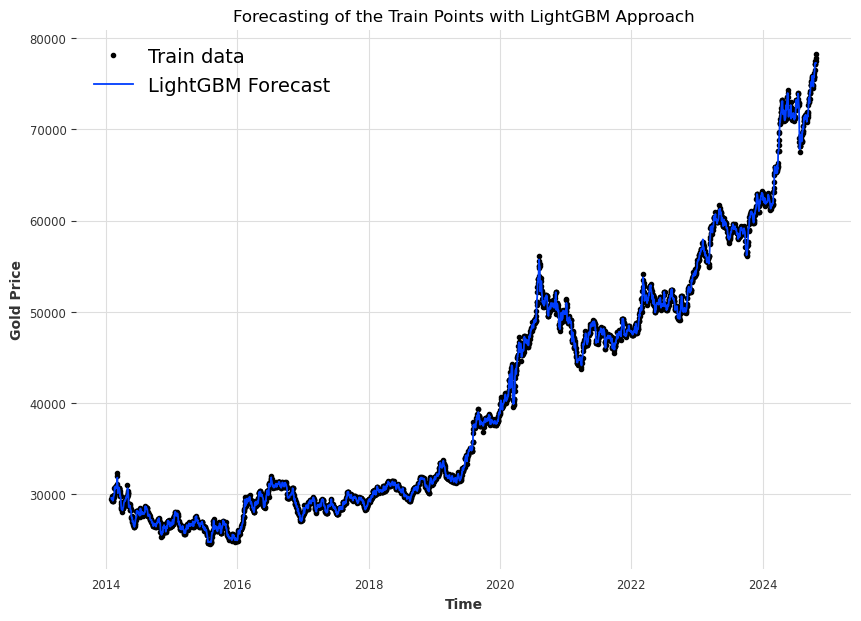

In [106]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=y_train[WINDOW_SIZE:], label="Train data")
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=pred_train_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [107]:
lightgbm_metrics_train = evaluate_preds(y_true=y_train[WINDOW_SIZE:],
                                        y_pred=pred_train_lightgbm)
lightgbm_metrics_train

{'mae': np.float32(122.653465),
 'mse': np.float32(32139.42),
 'rmse': np.float32(179.2747),
 'mape': np.float32(0.3183987)}

##### Persist Metrics

In [108]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train['mape'],
        "Val MAPE": lightgbm_metrics['mape'],
        "Train RMSE": lightgbm_metrics_train['rmse'],
        "Val RMSE": lightgbm_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Model

##### Create Model

In [109]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=-1,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=0,
    reg_alpha=0,
    random_state=42,
    verbose=-1
)

model_lightgbm.name = 'Early Stopping Model'

evals_result_lightgbm = {}

model_lightgbm.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse',
                   callbacks=[
                       lgb.early_stopping(stopping_rounds=80),
                       lgb.log_evaluation(period=50),
                       lgb.record_evaluation(eval_result=evals_result_lightgbm)
                    ]
                )

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



Training until validation scores don't improve for 80 rounds
[50]	valid_0's rmse: 22161.8	valid_0's l2: 4.91147e+08
[100]	valid_0's rmse: 13863.3	valid_0's l2: 1.92192e+08
[150]	valid_0's rmse: 8913.96	valid_0's l2: 7.94588e+07
[200]	valid_0's rmse: 5956.02	valid_0's l2: 3.54742e+07
[250]	valid_0's rmse: 4175.47	valid_0's l2: 1.74346e+07
[300]	valid_0's rmse: 3147.64	valid_0's l2: 9.90766e+06
[350]	valid_0's rmse: 2556.65	valid_0's l2: 6.53646e+06
[400]	valid_0's rmse: 2209.04	valid_0's l2: 4.87984e+06
[450]	valid_0's rmse: 2009.75	valid_0's l2: 4.03909e+06
[500]	valid_0's rmse: 1898.91	valid_0's l2: 3.60586e+06
[550]	valid_0's rmse: 1839.35	valid_0's l2: 3.38322e+06
[600]	valid_0's rmse: 1777.28	valid_0's l2: 3.15874e+06
[650]	valid_0's rmse: 1730.19	valid_0's l2: 2.99355e+06
[700]	valid_0's rmse: 1698.3	valid_0's l2: 2.88422e+06
[750]	valid_0's rmse: 1678.97	valid_0's l2: 2.81893e+06
[800]	valid_0's rmse: 1665.85	valid_0's l2: 2.77507e+06
[850]	valid_0's rmse: 1653.87	valid_0's l2: 2

LGBMRegressor(colsample_bytree=1, learning_rate=0.01, min_split_gain=0,
              n_estimators=1000, objective='regression', random_state=42,
              reg_alpha=0, reg_lambda=0, subsample=1, verbose=-1)

##### Make Predictions

In [110]:
pred_lightgbm = model_lightgbm.predict(val_gold_price_windowed)
pred_train_lightgbm = model_lightgbm.predict(train_gold_price_windowed)

##### Evaluate Predictions

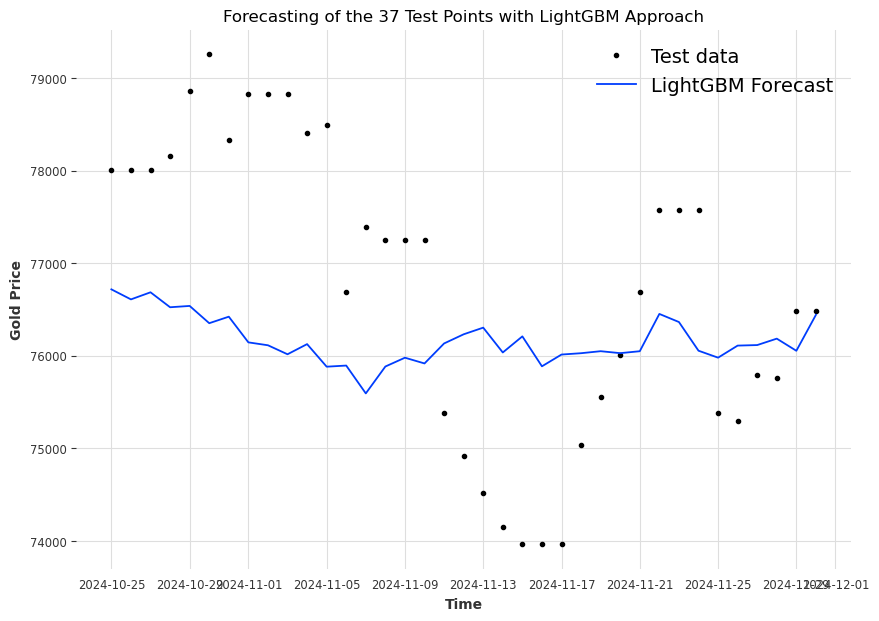

In [111]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [112]:
lightgbm_metrics = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(1433.4598),
 'mse': np.float32(2682472.0),
 'rmse': np.float32(1637.8254),
 'mape': np.float32(1.8599073)}

##### Evaluate Overfitting

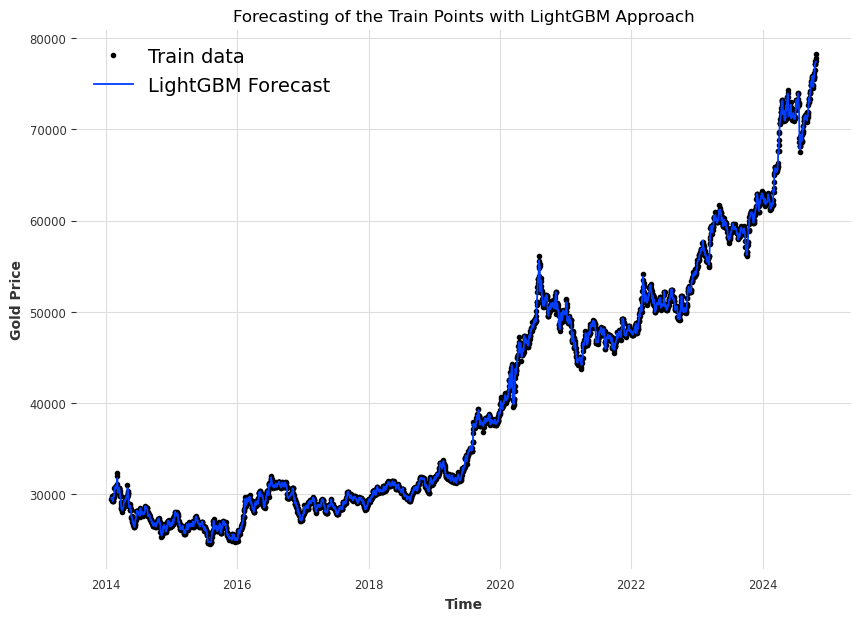

In [113]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=y_train[WINDOW_SIZE:], label="Train data")
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=pred_train_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [114]:
lightgbm_metrics_train = evaluate_preds(y_true=y_train[WINDOW_SIZE:],
                                        y_pred=pred_train_lightgbm)
lightgbm_metrics_train

{'mae': np.float32(117.150955),
 'mse': np.float32(29636.422),
 'rmse': np.float32(172.15233),
 'mape': np.float32(0.30617794)}

##### Persist Metrics

In [115]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train['mape'],
        "Val MAPE": lightgbm_metrics['mape'],
        "Train RMSE": lightgbm_metrics_train['rmse'],
        "Val RMSE": lightgbm_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Extremely Regularized Model

##### Create model

In [116]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=4,
    max_depth=2,
    min_split_gain=0.2,
    min_child_weight=100,
    min_child_samples=400,
    subsample=0.6,
    colsample_bytree=0.6,
    feature_fraction=0.6,
    reg_lambda=20.0,
    reg_alpha=5.0,
    random_state=42,
    verbose=-1
)

model_lightgbm.name = 'Early Stopping Extremely Regularized Model'

evals_result_lightgbm = {}

model_lightgbm.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse',
                   callbacks=[
                       lgb.early_stopping(stopping_rounds=80),
                       lgb.log_evaluation(period=50),
                       lgb.record_evaluation(eval_result=evals_result_lightgbm)
                    ]
                )

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



Training until validation scores don't improve for 80 rounds
[50]	valid_0's rmse: 16074.7	valid_0's l2: 2.58395e+08
[100]	valid_0's rmse: 10401.7	valid_0's l2: 1.08196e+08
[150]	valid_0's rmse: 8983.75	valid_0's l2: 8.07078e+07
[200]	valid_0's rmse: 8494.09	valid_0's l2: 7.21495e+07
[250]	valid_0's rmse: 8139.14	valid_0's l2: 6.62455e+07
[300]	valid_0's rmse: 8106.22	valid_0's l2: 6.57108e+07
[350]	valid_0's rmse: 8283.08	valid_0's l2: 6.86094e+07
Early stopping, best iteration is:
[286]	valid_0's rmse: 8060.46	valid_0's l2: 6.49711e+07


LGBMRegressor(colsample_bytree=0.6, feature_fraction=0.6, learning_rate=0.03,
              max_depth=2, min_child_samples=400, min_child_weight=100,
              min_split_gain=0.2, n_estimators=3000, num_leaves=4,
              objective='regression', random_state=42, reg_alpha=5.0,
              reg_lambda=20.0, subsample=0.6, verbose=-1)

##### Make predictions

In [117]:
pred_lightgbm = model_lightgbm.predict(val_gold_price_windowed, num_iteration=model_lightgbm.best_iteration_)
pred_train_lightgbm = model_lightgbm.predict(train_gold_price_windowed, num_iteration=model_lightgbm.best_iteration_)
len(pred_lightgbm), len(pred_train_lightgbm)

(37, 3920)

##### Evaluate predictions

In this model, and all the coming models, there is a possibility of overfitting, so, I will look also the metrics on the train set.

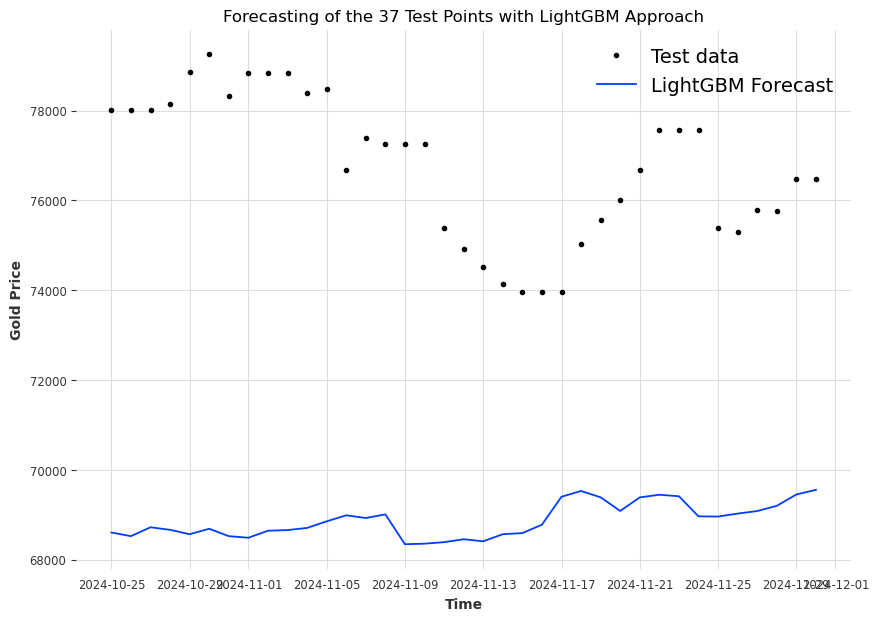

In [118]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [119]:
lightgbm_metrics = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(7878.1045),
 'mse': np.float32(64971044.0),
 'rmse': np.float32(8060.462),
 'mape': np.float32(10.223386)}

##### Evaluate Overfitting

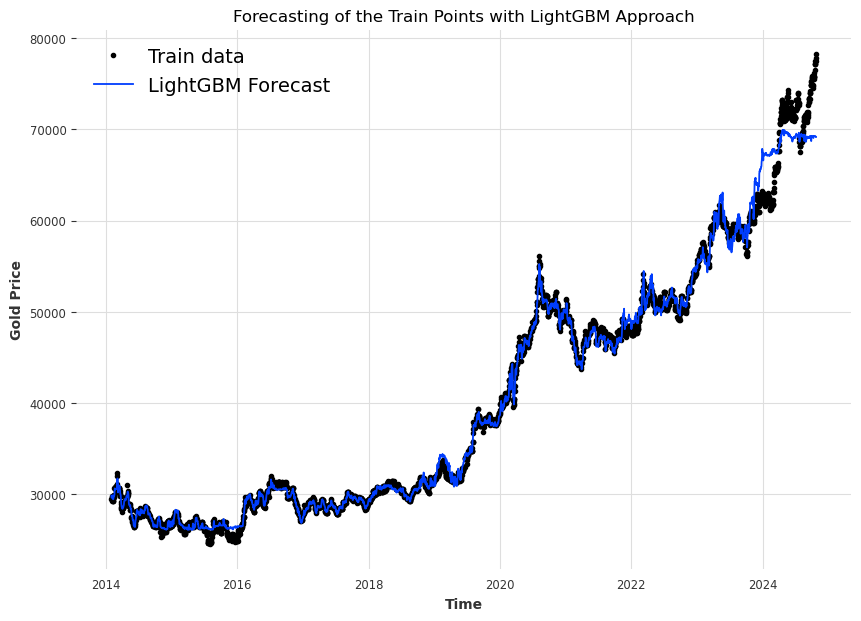

In [120]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=y_train[WINDOW_SIZE:], label="Train data")
plot_time_series(timesteps=X_train[WINDOW_SIZE:], values=pred_train_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [121]:
lightgbm_metrics_train = evaluate_preds(y_true=y_train[WINDOW_SIZE:],
                                        y_pred=pred_train_lightgbm)
lightgbm_metrics_train

{'mae': np.float32(685.0032),
 'mse': np.float32(1578232.9),
 'rmse': np.float32(1256.2773),
 'mape': np.float32(1.4543114)}

##### Persist Metrics

In [122]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train['mape'],
        "Val MAPE": lightgbm_metrics['mape'],
        "Train RMSE": lightgbm_metrics_train['rmse'],
        "Val RMSE": lightgbm_metrics['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [123]:
df_models_metrics_lightgbm

Model  Train MAPE   Val MAPE  \
0                               Default Model    0.307061   1.874841   
1                                 Small Model    0.436171   2.235495   
2                           Regularized Model    0.318399   1.935787   
3                        Early Stopping Model    0.306178   1.859907   
4  Early Stopping Extremely Regularized Model    1.454311  10.223386   

    Train RMSE     Val RMSE  
0   172.519775  1635.710693  
1   254.009857  2094.875000  
2   179.274704  1701.756958  
3   172.152328  1637.825439  
4  1256.277344  8060.461914

In [124]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=-1,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=0,
    reg_alpha=0,
    random_state=42,
    verbose=-1
)

evals_result_lightgbm = {}

model_lightgbm.fit(train_val_gold_price_windowed, train_val_labels,
                   eval_set=[(test_gold_price_windowed, test_labels)],
                   eval_metric='rmse',
                   callbacks=[
                       lgb.early_stopping(stopping_rounds=80),
                       lgb.log_evaluation(period=50),
                       lgb.record_evaluation(eval_result=evals_result_lightgbm)
                    ]
                )

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



Training until validation scores don't improve for 80 rounds
[50]	valid_0's rmse: 21121	valid_0's l2: 4.46097e+08
[100]	valid_0's rmse: 12652.2	valid_0's l2: 1.60077e+08
[150]	valid_0's rmse: 7623.5	valid_0's l2: 5.81178e+07
[200]	valid_0's rmse: 4621.01	valid_0's l2: 2.13538e+07
[250]	valid_0's rmse: 2887.77	valid_0's l2: 8.33922e+06
[300]	valid_0's rmse: 1880.91	valid_0's l2: 3.53781e+06
[350]	valid_0's rmse: 1279.86	valid_0's l2: 1.63804e+06
[400]	valid_0's rmse: 942.321	valid_0's l2: 887970
[450]	valid_0's rmse: 767.5	valid_0's l2: 589057
[500]	valid_0's rmse: 691.592	valid_0's l2: 478300
[550]	valid_0's rmse: 660.818	valid_0's l2: 436681
[600]	valid_0's rmse: 651.607	valid_0's l2: 424591
[650]	valid_0's rmse: 643.564	valid_0's l2: 414174
[700]	valid_0's rmse: 638.557	valid_0's l2: 407755
[750]	valid_0's rmse: 635.311	valid_0's l2: 403621
[800]	valid_0's rmse: 632.632	valid_0's l2: 400223
[850]	valid_0's rmse: 630.923	valid_0's l2: 398063
[900]	valid_0's rmse: 630.245	valid_0's l2:

LGBMRegressor(colsample_bytree=1, learning_rate=0.01, min_split_gain=0,
              n_estimators=1000, objective='regression', random_state=42,
              reg_alpha=0, reg_lambda=0, subsample=1, verbose=-1)

In [125]:
pred_lightgbm = model_lightgbm.predict(test_gold_price_windowed)

In [126]:
lightgbm_metrics = evaluate_preds(y_true=y_test,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(485.0591),
 'mse': np.float32(392880.84),
 'rmse': np.float32(626.80206),
 'mape': np.float32(0.63377774)}

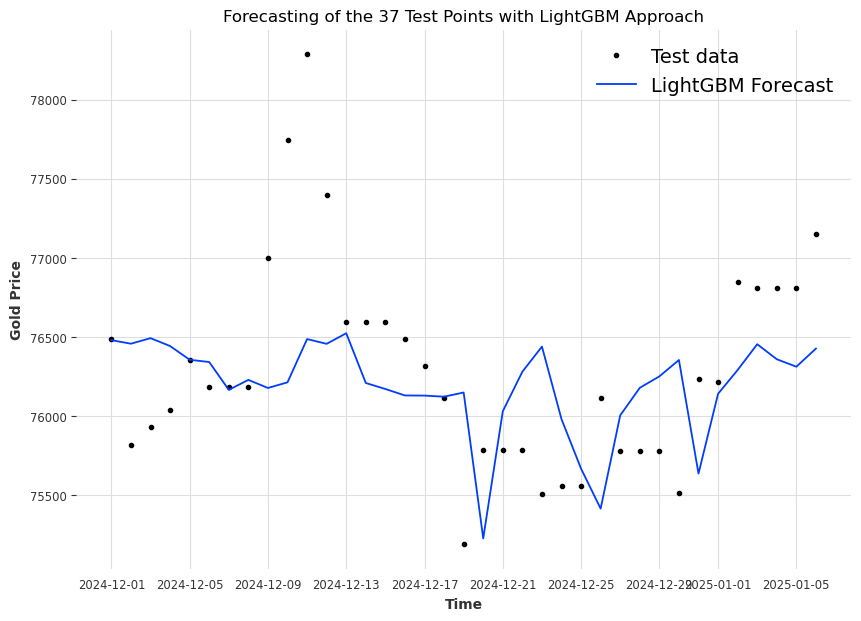

In [127]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

### N-BEATS

In [128]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

from utils.preds import make_predictions_rolling_one_darts

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\fs\__init__.py:4: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [129]:
df_models_metrics_nbeats = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Prepare the data for `darts`

We have to transform our `pd.DataFrame` into a `TimeSeries` object, and scale it.

In [130]:
# Create scalers for both
scaler = Scaler()

# Create TimeSeries objects to work with darts framework
gold_price_darts_train = TimeSeries.from_dataframe(gold_price[:2*split_size], value_cols='Price')
gold_price_darts_val = TimeSeries.from_dataframe(gold_price[2*split_size:split_size], value_cols='Price')
gold_price_darts_test = TimeSeries.from_dataframe(gold_price[split_size:], value_cols='Price')

# Scale the data
gold_price_darts_scaled_train = scaler.fit_transform(gold_price_darts_train)
gold_price_darts_scaled_val = scaler.transform(gold_price_darts_val)
gold_price_darts_scaled_test = scaler.transform(gold_price_darts_test)

In [131]:
from darts import concatenate

gold_price_darts_scaled_train_val = concatenate([gold_price_darts_scaled_train, gold_price_darts_scaled_val])

#### Default Model

##### Create model

In [132]:
model_nbeats = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats.name = 'Default Model'

model_nbeats.fit(gold_price_darts_scaled_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
------------

Epoch 9: 100%|██████████| 123/123 [00:06<00:00, 18.52it/s, train_loss=0.000132]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 123/123 [00:06<00:00, 18.51it/s, train_loss=0.000132]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [133]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [134]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.37it/s]


##### Evaluate Predicts

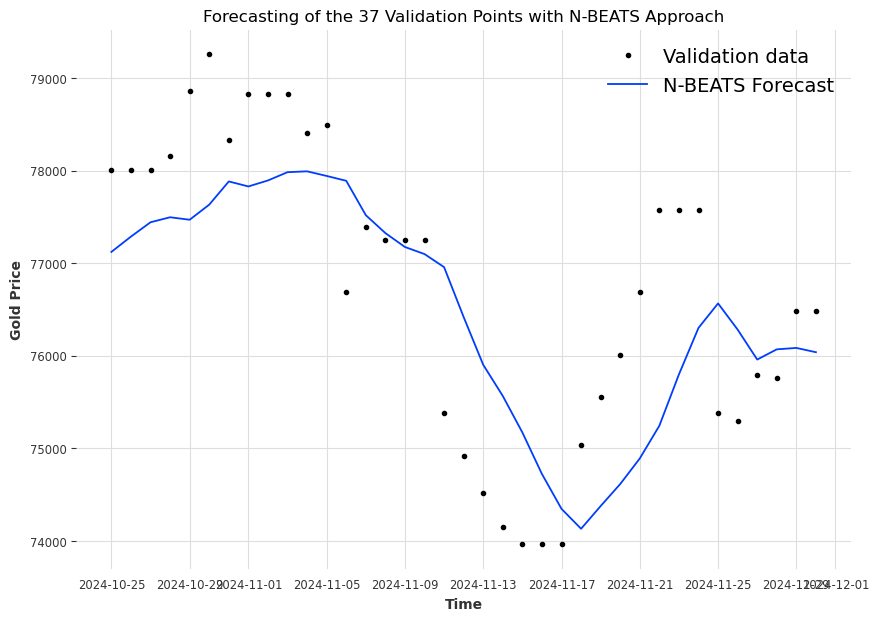

In [135]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [136]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(920.8602),
 'mse': np.float32(1155472.8),
 'rmse': np.float32(1074.9292),
 'mape': np.float32(1.2016013)}

##### Evaluate Overfitting

In [137]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.23it/s]


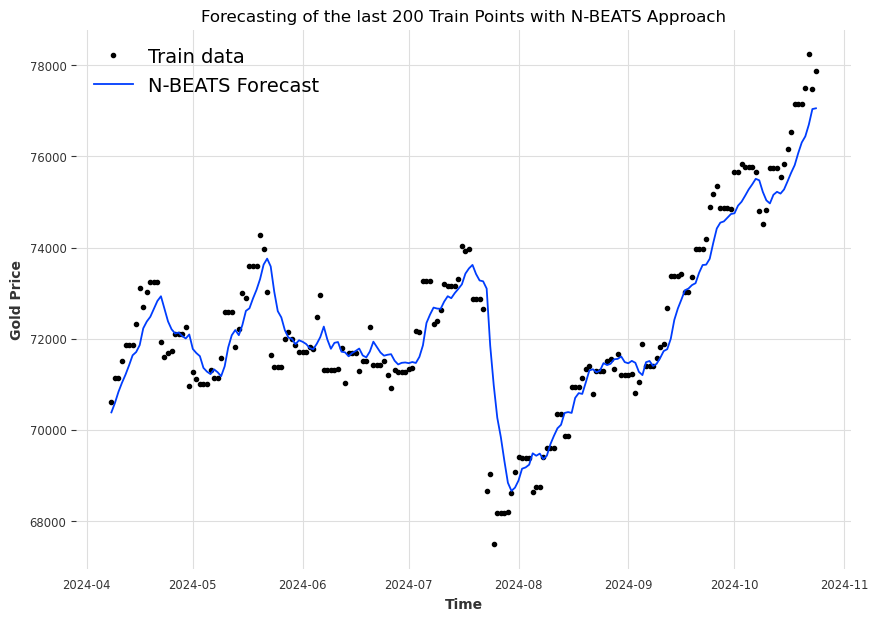

In [138]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [139]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[-200:])
nbeats_train_metrics

{'mae': np.float32(541.5778),
 'mse': np.float32(589747.8),
 'rmse': np.float32(767.9504),
 'mape': np.float32(0.75027794)}

##### Persist Metrics

In [140]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics['mape'],
        "Val MAPE": nbeats_train_metrics['mape'],
        "Train RMSE": nbeats_train_metrics['rmse'],
        "Val RMSE": nbeats_metrics['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22108\3650114659.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Dropout Model

##### Create Model

In [141]:
model_nbeats = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0.2,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats.name = 'Dropout Model'

model_nbeats.fit(gold_price_darts_scaled_train)

Epoch 9: 100%|██████████| 123/123 [00:06<00:00, 17.80it/s, train_loss=0.000717]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [142]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


##### Evaluate Predicts

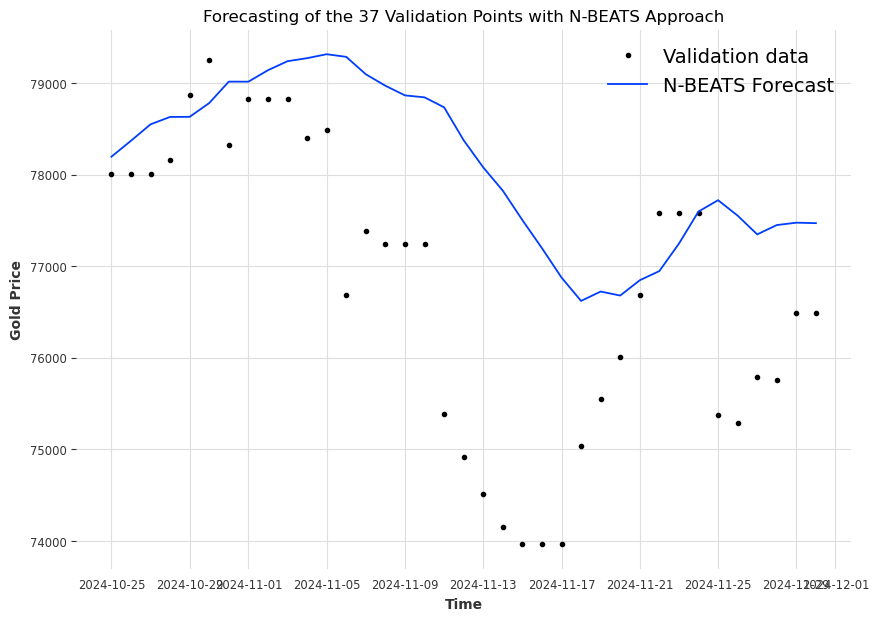

In [143]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [144]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(1430.4609),
 'mse': np.float32(3365641.0),
 'rmse': np.float32(1834.5684),
 'mape': np.float32(1.8907703)}

##### Evaluate Overffiting

In [145]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.48it/s]


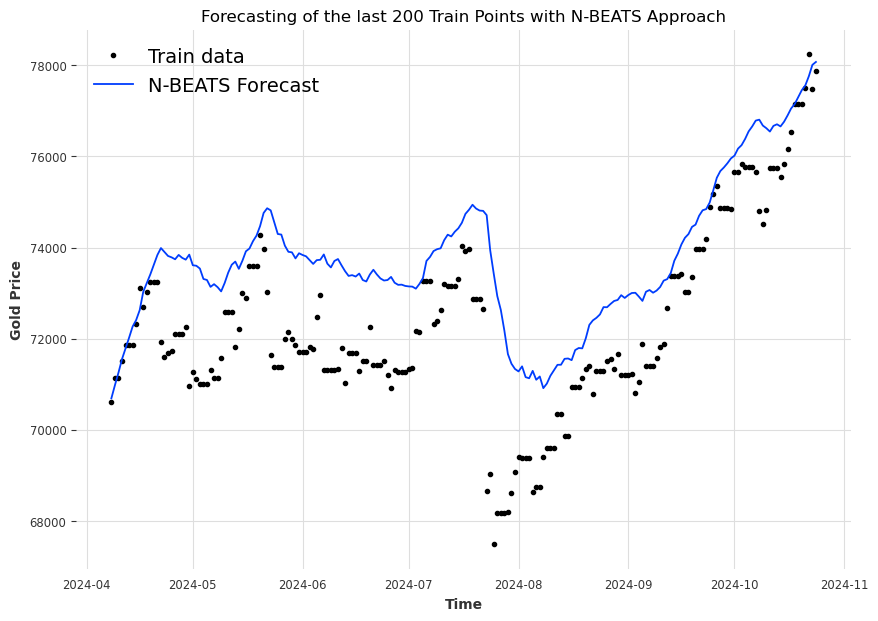

In [146]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [147]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[-200:])
nbeats_train_metrics

{'mae': np.float32(1457.6775),
 'mse': np.float32(3111935.0),
 'rmse': np.float32(1764.0677),
 'mape': np.float32(2.0428877)}

##### Persist Metrics

In [148]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics['mape'],
        "Val MAPE": nbeats_train_metrics['mape'],
        "Train RMSE": nbeats_train_metrics['rmse'],
        "Val RMSE": nbeats_metrics['rmse']
    }])
], ignore_index=True)

#### Small Model

Less num_stacks, layer_widths and num_layers.

##### Create Model

In [149]:
model_nbeats = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=6,
    num_blocks=1,
    num_layers=3,
    layer_widths=128,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats.name = 'Small Model'

model_nbeats.fit(gold_price_darts_scaled_train)

Epoch 9: 100%|██████████| 123/123 [00:01<00:00, 86.18it/s, train_loss=3.56e-5] 


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=128, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [150]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.03it/s]


##### Evaluate Predictions

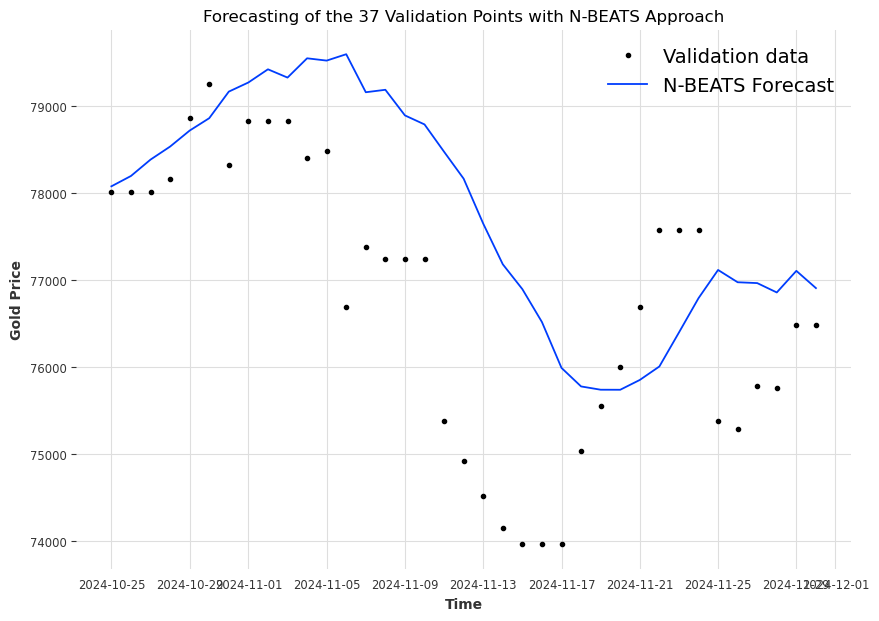

In [151]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [152]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(1304.7778),
 'mse': np.float32(2652376.2),
 'rmse': np.float32(1628.6118),
 'mape': np.float32(1.7182747)}

##### Evaluate Overfitting

In [153]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.19it/s] 


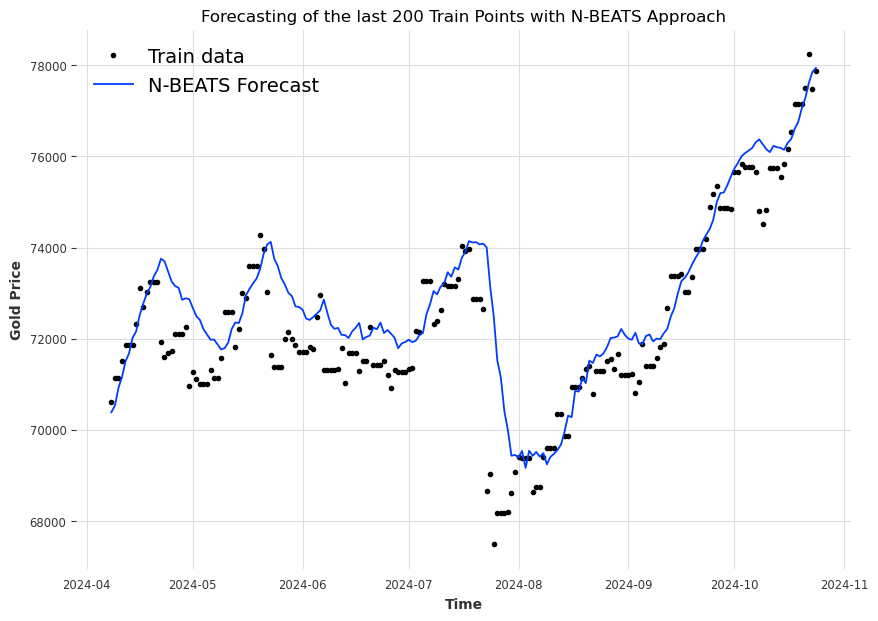

In [154]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [155]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[-200:])
nbeats_train_metrics

{'mae': np.float32(714.0986),
 'mse': np.float32(1084577.6),
 'rmse': np.float32(1041.4305),
 'mape': np.float32(0.9999659)}

##### Persist Metrics

In [156]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics['mape'],
        "Val MAPE": nbeats_train_metrics['mape'],
        "Train RMSE": nbeats_train_metrics['rmse'],
        "Val RMSE": nbeats_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Model

##### Create Model

In [157]:
from pytorch_lightning.callbacks import EarlyStopping

In [158]:
early_stopper = EarlyStopping(monitor="train_loss", patience=5, mode="min")

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    n_epochs=100,
    batch_size=32,
    dropout=0.2,
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    random_state=42
)

model_nbeats.name = 'Early Stopping Model'

model_nbeats.fit(gold_price_darts_scaled_train)

Epoch 38: 100%|██████████| 123/123 [00:07<00:00, 17.38it/s, train_loss=7.16e-5] 


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A51BB68C0>]}, random_state=42)

##### Make Predictions

In [159]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.51it/s]


##### Evaluate Predictions

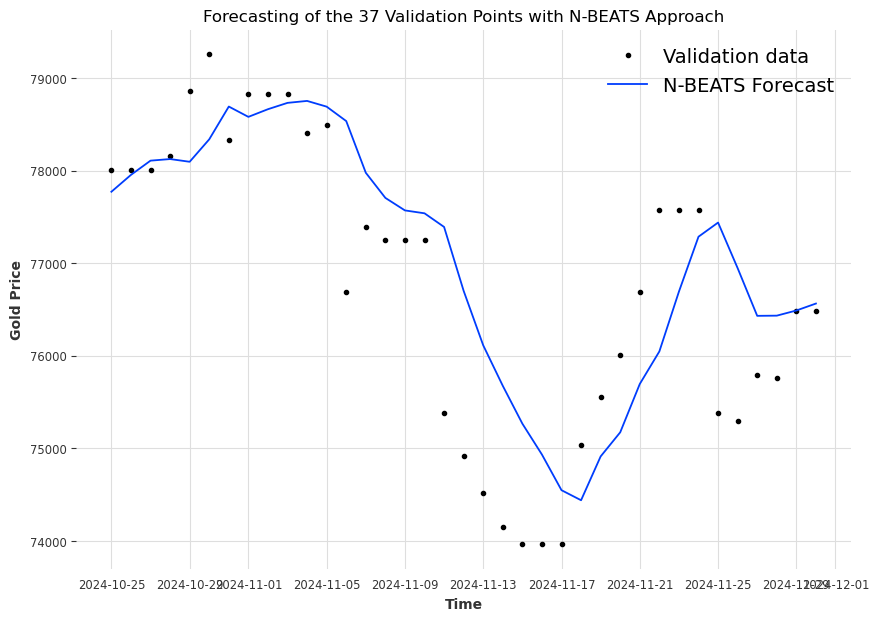

In [160]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [161]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(749.0606),
 'mse': np.float32(936724.6),
 'rmse': np.float32(967.84534),
 'mape': np.float32(0.9858305)}

##### Evaluate Overfitting

In [162]:
preds_holdout_train_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


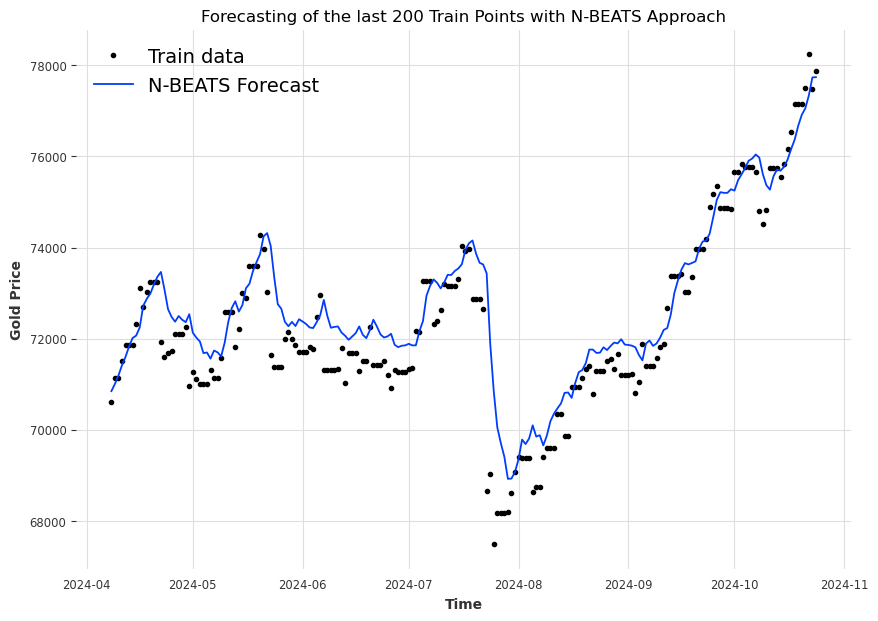

In [163]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [164]:
nbeats_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeats,
                                      y_true=y_train[-200:])
nbeats_train_metrics

{'mae': np.float32(571.1982),
 'mse': np.float32(656065.44),
 'rmse': np.float32(809.97864),
 'mape': np.float32(0.79928774)}

##### Persist Metrics

In [165]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics['mape'],
        "Val MAPE": nbeats_train_metrics['mape'],
        "Train RMSE": nbeats_train_metrics['rmse'],
        "Val RMSE": nbeats_metrics['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [166]:
df_models_metrics_nbeats

Model  Train MAPE  Val MAPE   Train RMSE     Val RMSE
0         Default Model    1.201601  0.750278   767.950378  1074.929199
1         Dropout Model    1.890770  2.042888  1764.067749  1834.568359
2           Small Model    1.718275  0.999966  1041.430542  1628.611816
3  Early Stopping Model    0.985830  0.799288   809.978638   967.845337

In [167]:
early_stopper = EarlyStopping(monitor="train_loss", patience=5, mode="min")

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    n_epochs=100,
    batch_size=32,
    dropout=0.2,
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    random_state=42
)

model_nbeats.fit(gold_price_darts_scaled_train_val)

Epoch 22: 100%|██████████| 124/124 [00:07<00:00, 17.27it/s, train_loss=0.000384]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A45052320>]}, random_state=42)

In [168]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train_val,
                                                  ts_test=gold_price_darts_scaled_test,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.60it/s]


In [169]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(1748.8353),
 'mse': np.float32(4755145.5),
 'rmse': np.float32(2180.6296),
 'mape': np.float32(2.3122694)}

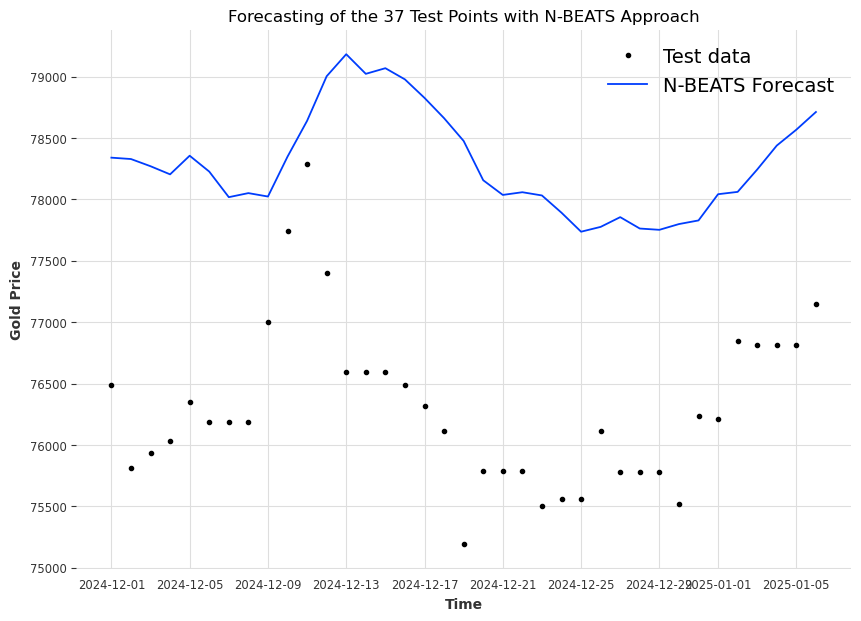

In [170]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with N-BEATS Approach')
plt.show()

### LSTM - Long Short Term Memory

In [171]:
from darts.models import RNNModel

In [172]:
df_models_metrics_lstm = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Preparing the data

In [173]:
# Create scaler
scaler_exogenus = Scaler()

gold_price_exogenus_darts_train = TimeSeries.from_dataframe(gold_price[:2*split_size], value_cols=exog_data.columns.values)
gold_price_exogenus_darts_val = TimeSeries.from_dataframe(gold_price[2*split_size:split_size], value_cols=exog_data.columns.values)
gold_price_exogenus_darts_train_val = concatenate([gold_price_exogenus_darts_train, gold_price_exogenus_darts_val])
gold_price_exogenus_darts_test = TimeSeries.from_dataframe(gold_price[split_size:], value_cols=exog_data.columns.values)

gold_price_exogenus_darts_scaled_train = scaler_exogenus.fit_transform(gold_price_exogenus_darts_train)
gold_price_exogenus_darts_scaled_val = scaler_exogenus.transform(gold_price_exogenus_darts_val)
gold_price_exogenus_darts_scaled_train_val = scaler_exogenus.transform(gold_price_exogenus_darts_train_val)
gold_price_exogenus_darts_scaled_test = scaler_exogenus.transform(gold_price_exogenus_darts_test)

#### Default Model

##### Create Model

In [174]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=25,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_lstm.name = 'Default Model'

model_lstm.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:00<00:00, 146.59it/s, train_loss=3.25e-5] 


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [175]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.14it/s]


##### Evaluate Predictions

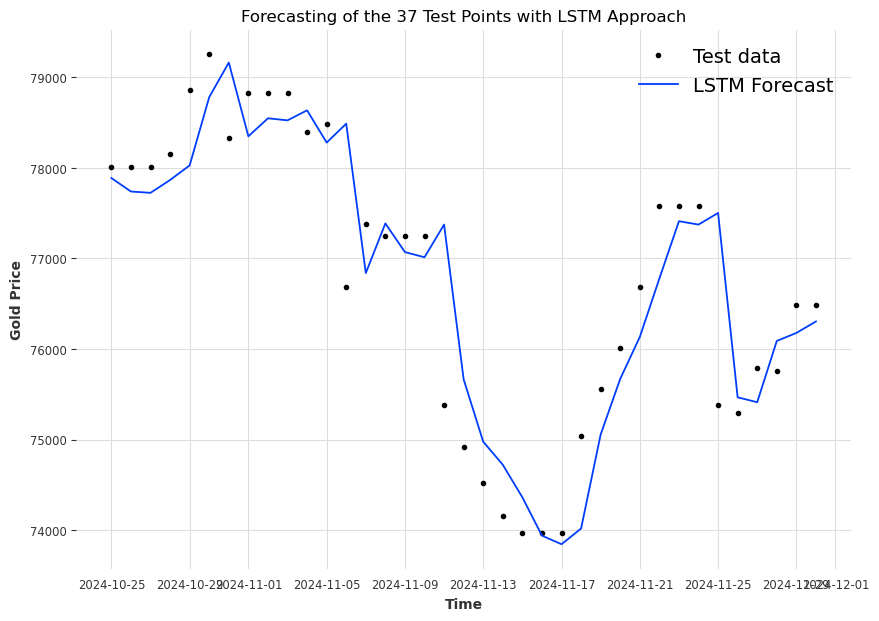

In [ ]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [177]:
lstm_metrics = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm)
lstm_metrics

{'mae': np.float32(511.23798),
 'mse': np.float32(503353.72),
 'rmse': np.float32(709.47424),
 'mape': np.float32(0.6685529)}

##### Evaluate Overfitting

In [178]:
preds_holdout_train_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


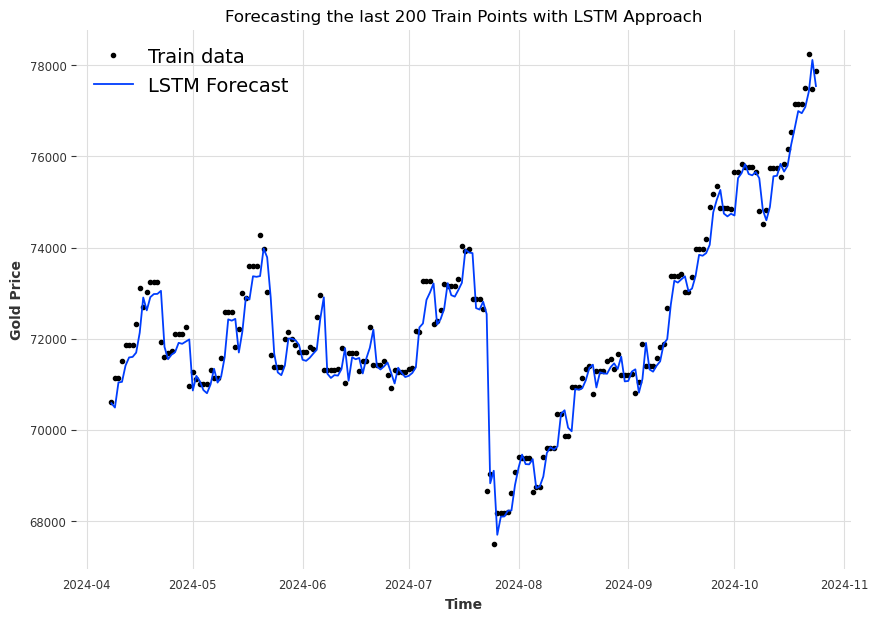

In [179]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [180]:
lstm_train_metrics = evaluate_preds(y_pred=preds_holdout_train_lstm,
                                      y_true=y_train[-200:])
lstm_train_metrics

{'mae': np.float32(343.1118),
 'mse': np.float32(270306.8),
 'rmse': np.float32(519.9104),
 'mape': np.float32(0.47529066)}

##### Persist Metrics

In [181]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics['mape'],
        "Val MAPE": lstm_metrics['mape'],
        "Train RMSE": lstm_train_metrics['rmse'],
        "Val RMSE": lstm_metrics['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22108\1962257944.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [182]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=10,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_lstm.name = 'Small Model'

model_lstm.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:00<00:00, 145.02it/s, train_loss=2.81e-5] 


RNNModel(model=LSTM, hidden_dim=10, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [183]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]


##### Evaluate Predictions

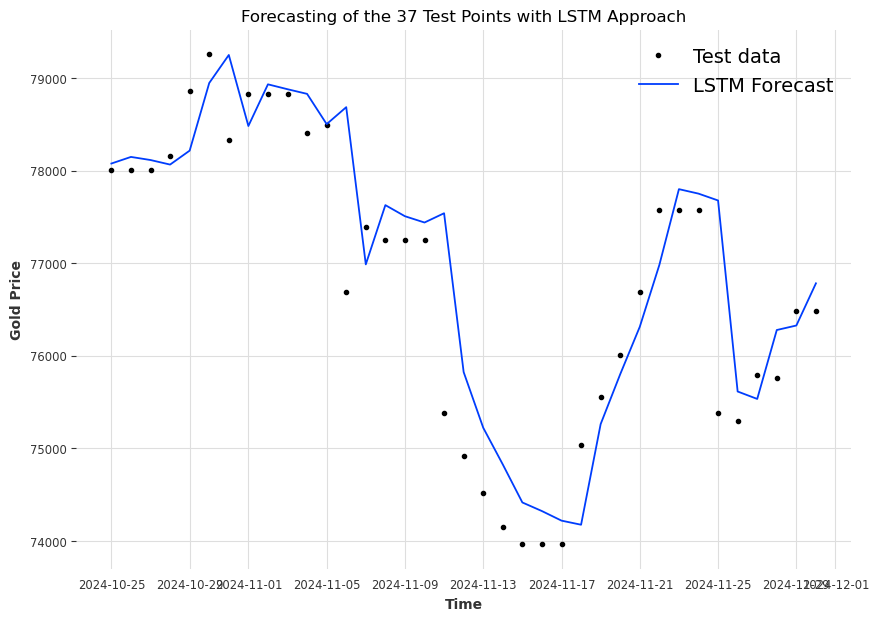

In [ ]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [185]:
lstm_metrics = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm)
lstm_metrics

{'mae': np.float32(501.1609),
 'mse': np.float32(547161.7),
 'rmse': np.float32(739.7038),
 'mape': np.float32(0.6579086)}

##### Evaluate Overfitting

In [186]:
preds_holdout_train_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]


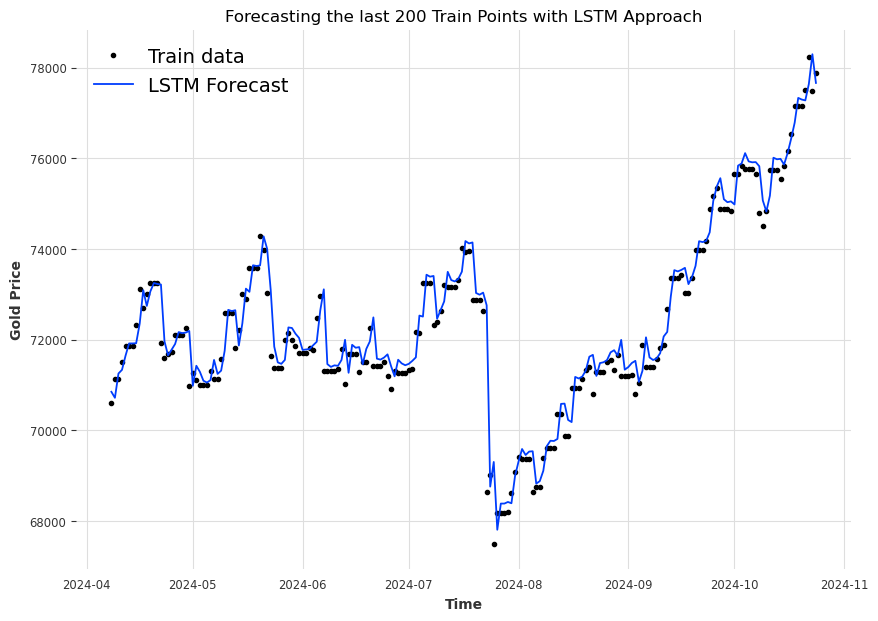

In [187]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [188]:
lstm_train_metrics = evaluate_preds(y_pred=preds_holdout_train_lstm,
                                      y_true=y_train[-200:])
lstm_train_metrics

{'mae': np.float32(333.43332),
 'mse': np.float32(281945.97),
 'rmse': np.float32(530.98584),
 'mape': np.float32(0.46348962)}

##### Persist Metrics

In [189]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics['mape'],
        "Val MAPE": lstm_metrics['mape'],
        "Train RMSE": lstm_train_metrics['rmse'],
        "Val RMSE": lstm_metrics['rmse']
    }])
], ignore_index=True)

#### Complex Model

##### Create Model

In [190]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=40,
    n_rnn_layers=3,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_lstm.name = 'Complex Model'

model_lstm.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:01<00:00, 86.44it/s, train_loss=2.17e-5] 


RNNModel(model=LSTM, hidden_dim=40, n_rnn_layers=3, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [191]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.05it/s]


##### Evaluate Predictions

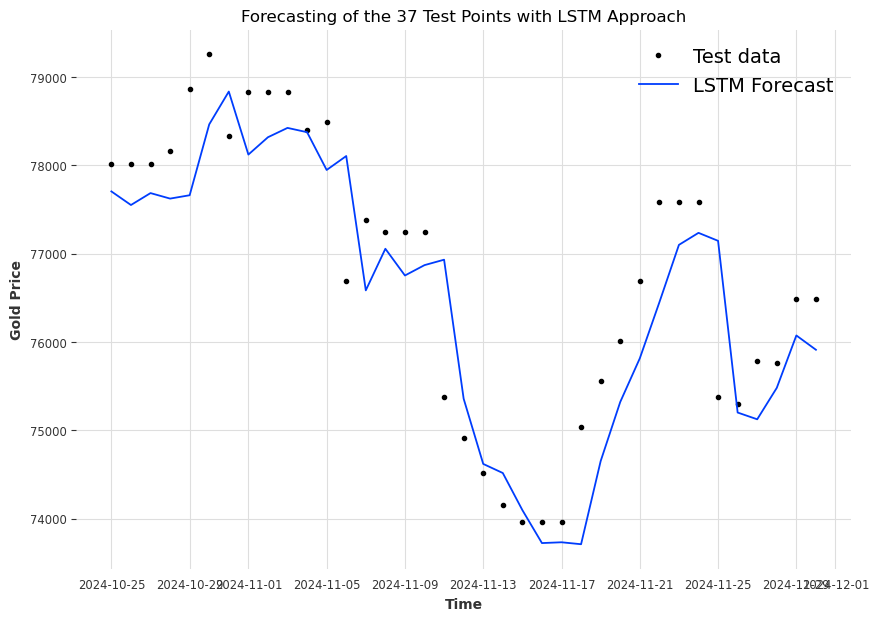

In [ ]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [193]:
lstm_metrics = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm)
lstm_metrics

{'mae': np.float32(600.15265),
 'mse': np.float32(534776.1),
 'rmse': np.float32(731.2839),
 'mape': np.float32(0.78180295)}

##### Evaluate Overfitting

In [194]:
preds_holdout_train_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.80it/s]


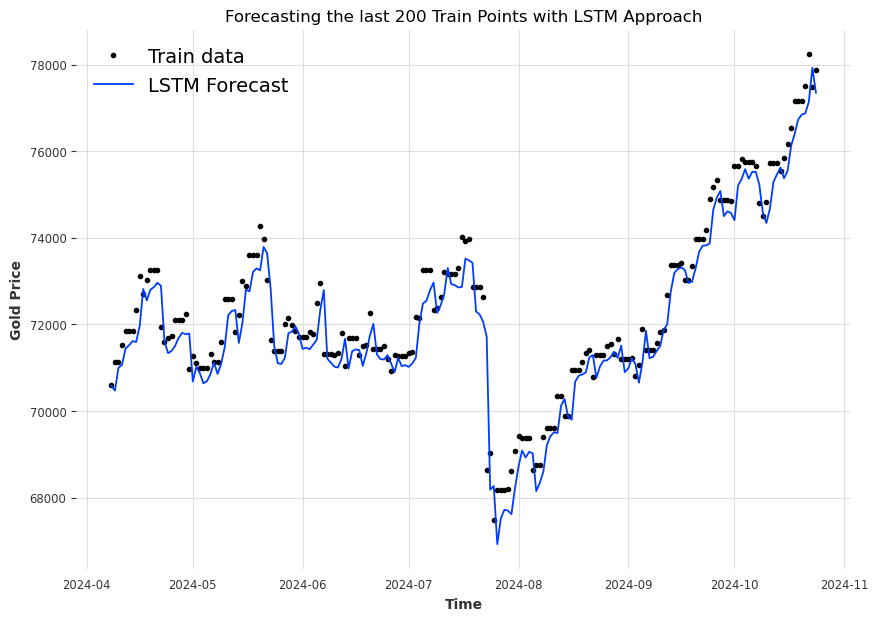

In [195]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [196]:
lstm_train_metrics = evaluate_preds(y_pred=preds_holdout_train_lstm,
                                      y_true=y_train[-200:])
lstm_train_metrics

{'mae': np.float32(439.83337),
 'mse': np.float32(311260.56),
 'rmse': np.float32(557.9073),
 'mape': np.float32(0.60917294)}

##### Persist Metrics

In [197]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics['mape'],
        "Val MAPE": lstm_metrics['mape'],
        "Train RMSE": lstm_train_metrics['rmse'],
        "Val RMSE": lstm_metrics['rmse']
    }])
], ignore_index=True)

#### Regularized Small Model

##### Create Model

In [198]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=10,
    n_rnn_layers=1,
    dropout=0.2,
    batch_size=32,
    n_epochs=100
)

model_lstm.name = 'Regularized Small Model'

model_lstm.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Epoch 0:   0%|          | 0/123 [00:00<?, ?it/s] 

Epoch 99: 100%|██████████| 123/123 [00:00<00:00, 129.44it/s, train_loss=2.08e-5] 


RNNModel(model=LSTM, hidden_dim=10, n_rnn_layers=1, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [199]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.45it/s]


##### Evaluate Predictions

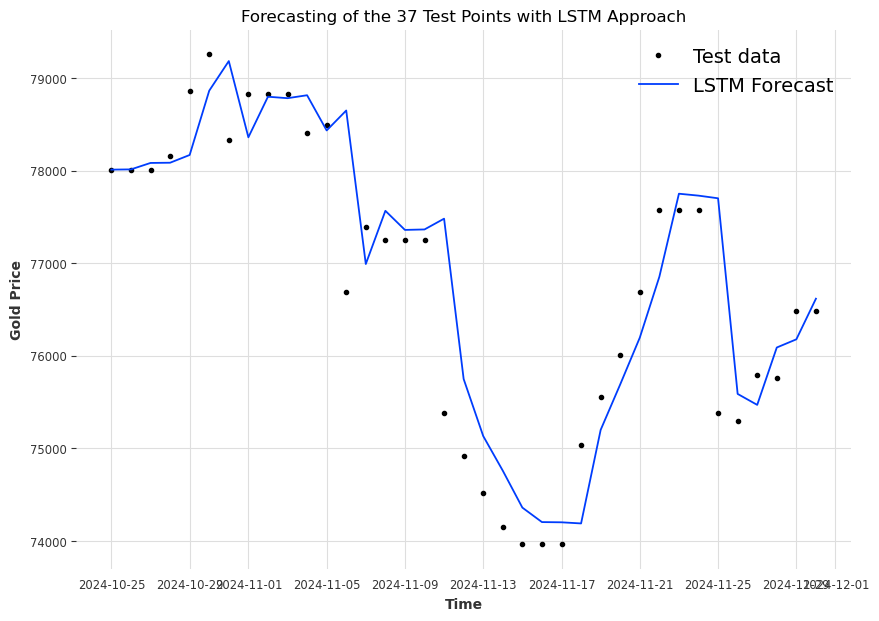

In [ ]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [201]:
lstm_metrics = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm)
lstm_metrics

{'mae': np.float32(481.45206),
 'mse': np.float32(529878.06),
 'rmse': np.float32(727.92725),
 'mape': np.float32(0.63172644)}

##### Evaluate Overfitting

In [202]:
preds_holdout_train_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]


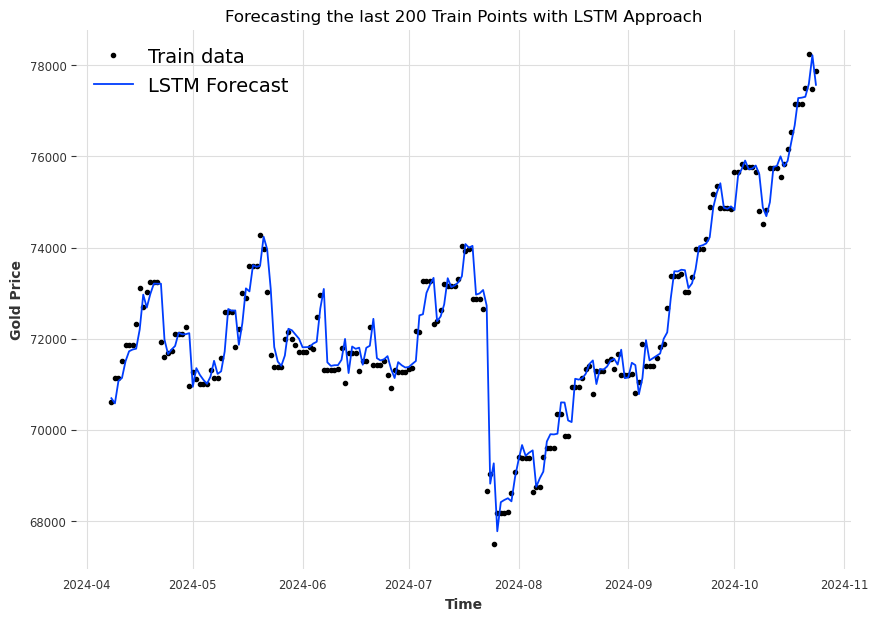

In [203]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [204]:
lstm_train_metrics = evaluate_preds(y_pred=preds_holdout_train_lstm,
                                      y_true=y_train[-200:])
lstm_train_metrics

{'mae': np.float32(320.82437),
 'mse': np.float32(273471.0),
 'rmse': np.float32(522.9445),
 'mape': np.float32(0.44610357)}

##### Persist Metrics

In [205]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics['mape'],
        "Val MAPE": lstm_metrics['mape'],
        "Train RMSE": lstm_train_metrics['rmse'],
        "Val RMSE": lstm_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Model

##### Create Model

In [206]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=25,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=1000,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_lstm.name = 'Early Stopping Model'

model_lstm.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 83: 100%|██████████| 123/123 [00:00<00:00, 139.27it/s, train_loss=3.19e-5] 


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=1000, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A62226E30>]})

##### Make Predictions

In [207]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.54it/s]


##### Evaluate Predictions

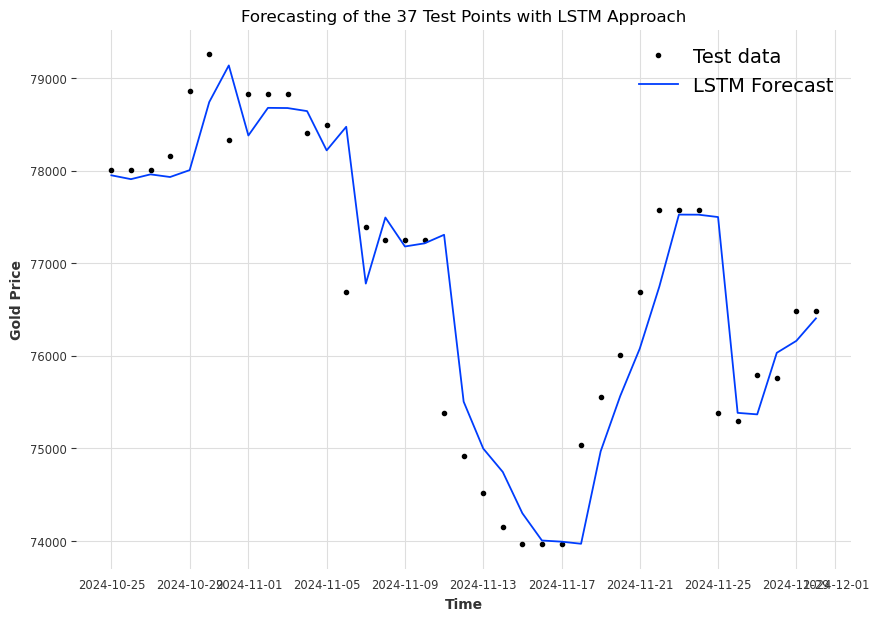

In [ ]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [209]:
lstm_metrics = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm)
lstm_metrics

{'mae': np.float32(475.1284),
 'mse': np.float32(489275.4),
 'rmse': np.float32(699.48224),
 'mape': np.float32(0.62183845)}

##### Evaluate Overfitting

In [210]:
preds_holdout_train_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.92it/s]


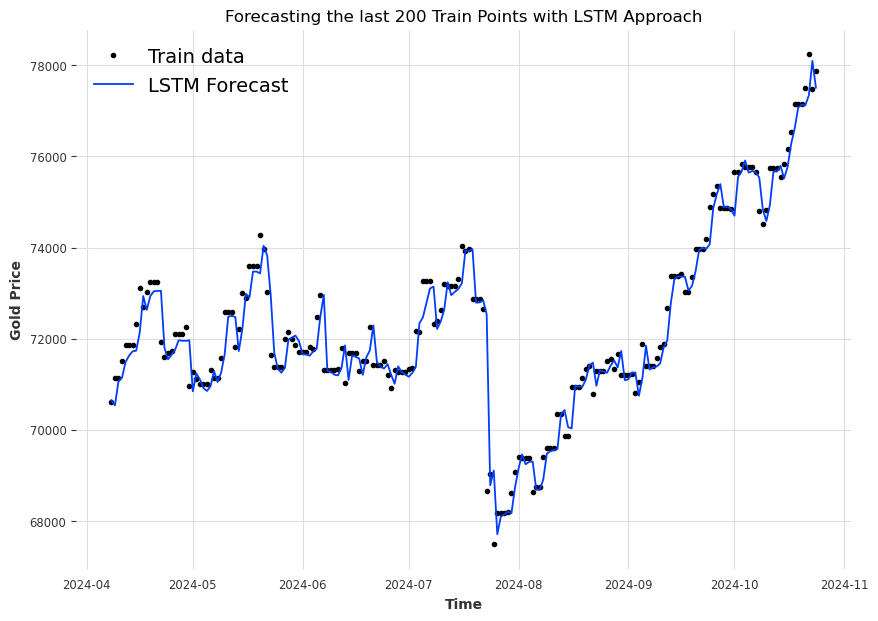

In [211]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [212]:
lstm_train_metrics = evaluate_preds(y_pred=preds_holdout_train_lstm,
                                      y_true=y_train[-200:])
lstm_train_metrics

{'mae': np.float32(325.66992),
 'mse': np.float32(265139.88),
 'rmse': np.float32(514.91736),
 'mape': np.float32(0.45160636)}

##### Persist Metrics

In [213]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics['mape'],
        "Val MAPE": lstm_metrics['mape'],
        "Train RMSE": lstm_train_metrics['rmse'],
        "Val RMSE": lstm_metrics['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [214]:
df_models_metrics_lstm

Model  Train MAPE  Val MAPE  Train RMSE    Val RMSE
0            Default Model    0.475291  0.668553  519.910400  709.474243
1              Small Model    0.463490  0.657909  530.985840  739.703796
2            Complex Model    0.609173  0.781803  557.907288  731.283875
3  Regularized Small Model    0.446104  0.631726  522.944519  727.927246
4     Early Stopping Model    0.451606  0.621838  514.917358  699.482239

In [215]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=10,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_lstm.fit(gold_price_darts_scaled_train_val, future_covariates=gold_price_exogenus_darts_scaled_train_val)

Epoch 99: 100%|██████████| 124/124 [00:00<00:00, 141.22it/s, train_loss=4.97e-5] 


RNNModel(model=LSTM, hidden_dim=10, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

In [216]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]


In [217]:
nbeats_metrics = evaluate_preds(y_true=y_test,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(1985.3146),
 'mse': np.float32(4262372.5),
 'rmse': np.float32(2064.5515),
 'mape': np.float32(2.606821)}

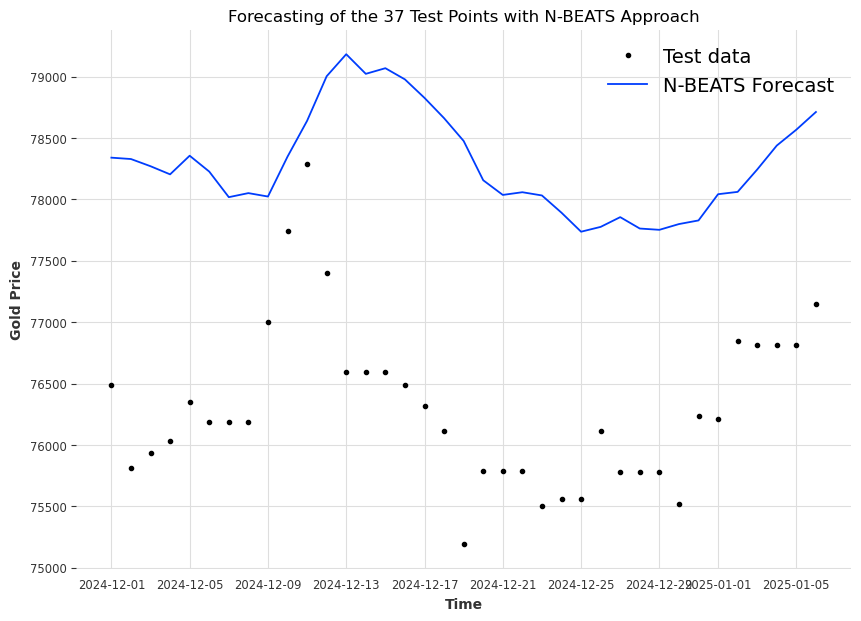

In [218]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with N-BEATS Approach')
plt.show()

### GRU - Gated Recurrent Unit Neural Network

In [219]:
df_models_metrics_gru = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [220]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=25,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_gru.name = 'Default Model'

model_gru.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:00<00:00, 144.98it/s, train_loss=2.27e-5] 


RNNModel(model=GRU, hidden_dim=25, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [221]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.09it/s]


##### Evaluate Predictions

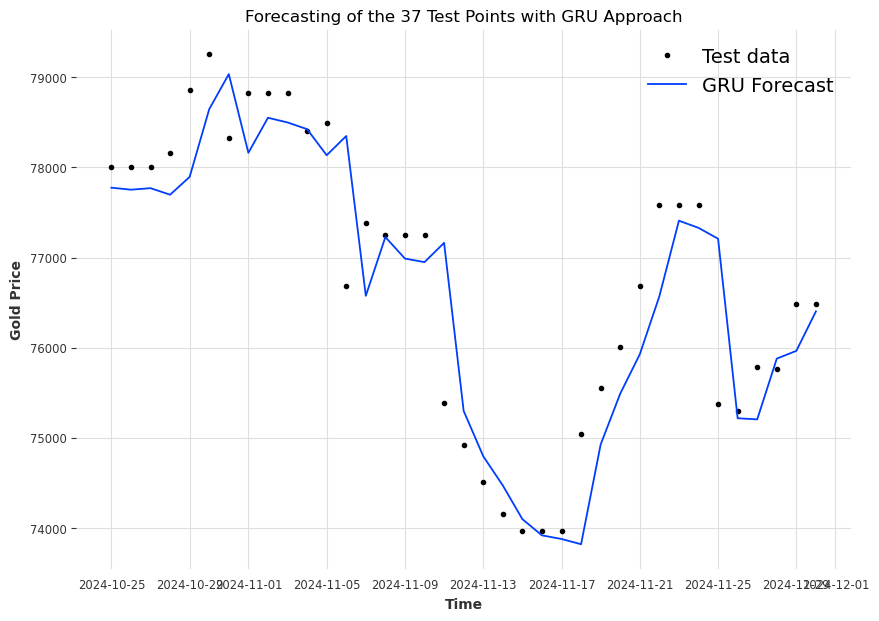

In [ ]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [223]:
gru_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(512.81036),
 'mse': np.float32(483539.56),
 'rmse': np.float32(695.3701),
 'mape': np.float32(0.66868186)}

##### Evaluate Overfitting

In [224]:
preds_holdout_train_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]


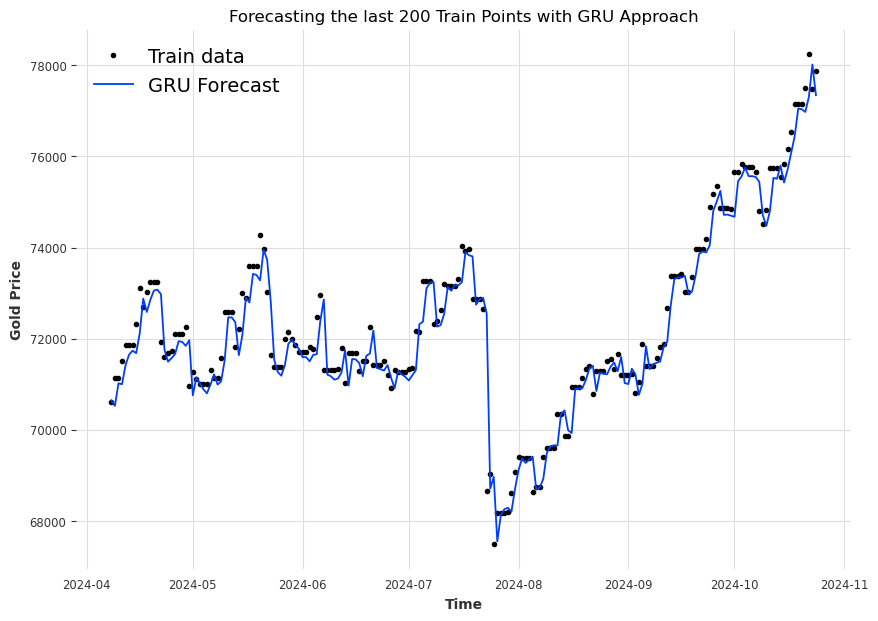

In [225]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [226]:
gru_train_metrics = evaluate_preds(y_pred=preds_holdout_train_gru,
                                      y_true=y_train[-200:])
gru_train_metrics

{'mae': np.float32(348.3824),
 'mse': np.float32(279424.84),
 'rmse': np.float32(528.6065),
 'mape': np.float32(0.48227507)}

##### Persist Metrics

In [227]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics['mape'],
        "Val MAPE": gru_metrics['mape'],
        "Train RMSE": gru_train_metrics['rmse'],
        "Val RMSE": gru_metrics['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22108\3738052753.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [228]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=12,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_gru.name = 'Small Model'

model_gru.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:00<00:00, 131.67it/s, train_loss=4.67e-5] 


RNNModel(model=GRU, hidden_dim=12, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [229]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 248.30it/s]


##### Evaluate Predictions

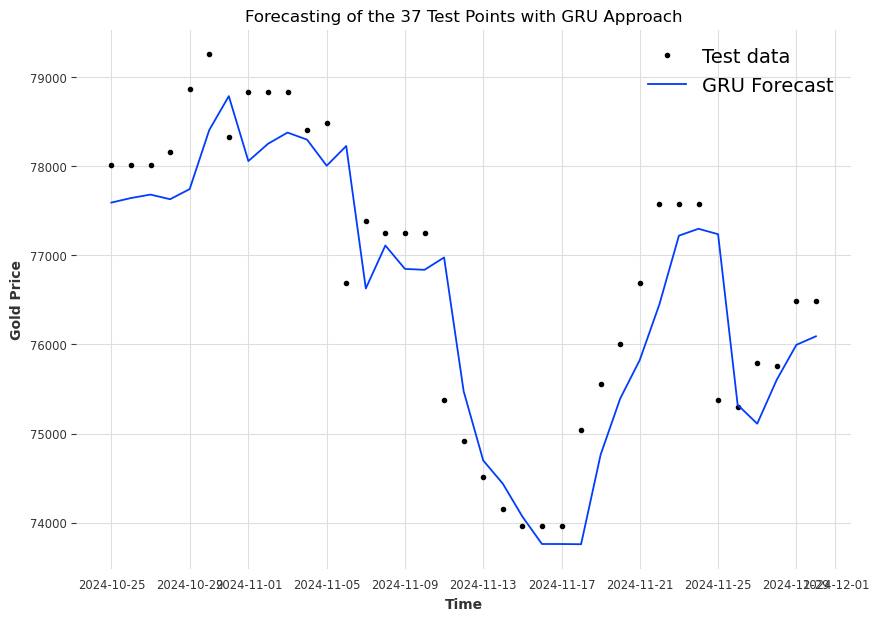

In [ ]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [231]:
gru_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(588.2869),
 'mse': np.float32(535986.8),
 'rmse': np.float32(732.1112),
 'mape': np.float32(0.7661407)}

##### Evaluate Overfitting

In [232]:
preds_holdout_train_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.04it/s]


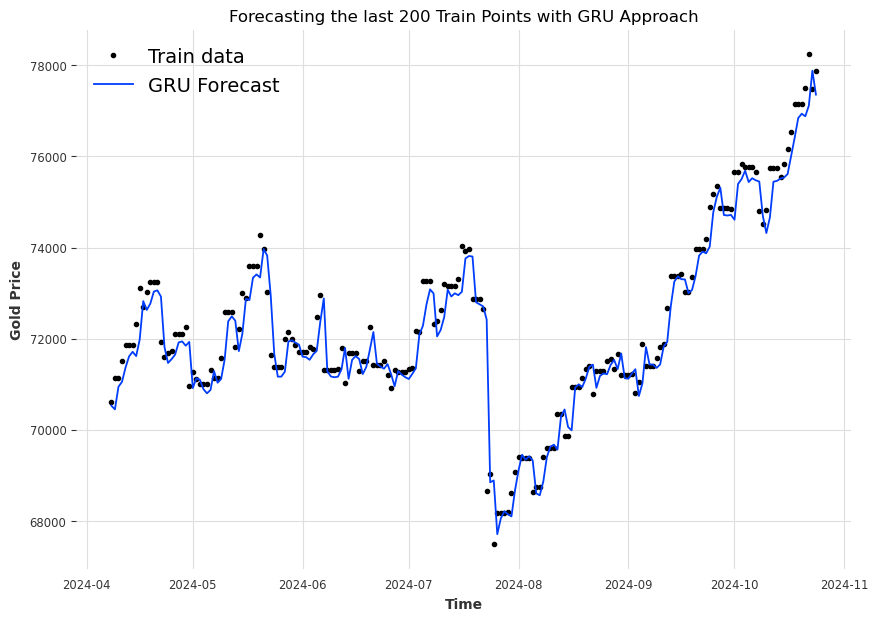

In [233]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [234]:
gru_train_metrics = evaluate_preds(y_pred=preds_holdout_train_gru,
                                      y_true=y_train[-200:])
gru_train_metrics

{'mae': np.float32(364.0222),
 'mse': np.float32(286103.7),
 'rmse': np.float32(534.8866),
 'mape': np.float32(0.50327694)}

##### Persist Metrics

In [235]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics['mape'],
        "Val MAPE": gru_metrics['mape'],
        "Train RMSE": gru_train_metrics['rmse'],
        "Val RMSE": gru_metrics['rmse']
    }])
], ignore_index=True)

#### Complex Model

##### Create Model

In [236]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=35,
    n_rnn_layers=3,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_gru.name = 'Complex Model'

model_gru.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:01<00:00, 92.64it/s, train_loss=5.47e-5] 


RNNModel(model=GRU, hidden_dim=35, n_rnn_layers=3, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [237]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.87it/s]


##### Evaluate Predictions

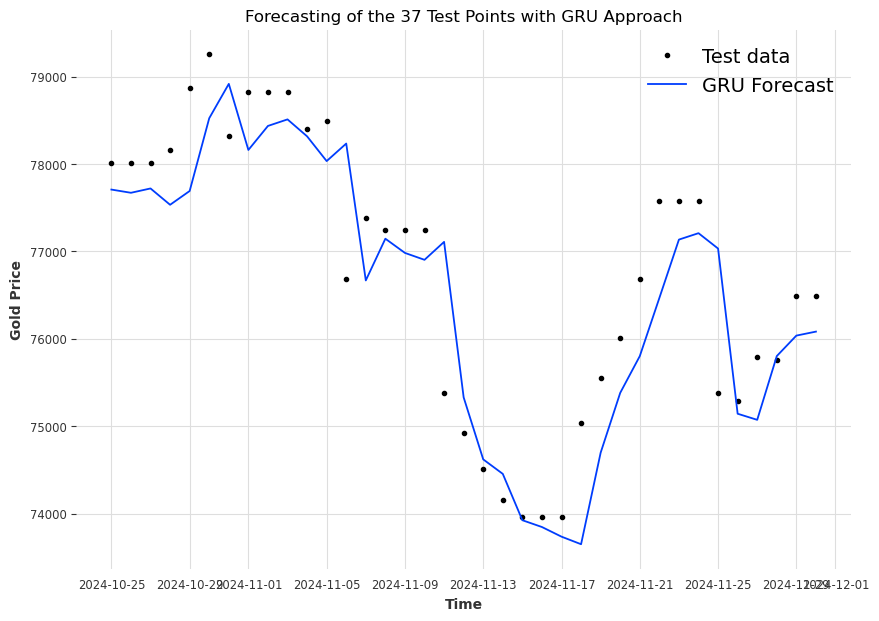

In [ ]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [239]:
gru_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(567.2787),
 'mse': np.float32(523045.72),
 'rmse': np.float32(723.219),
 'mape': np.float32(0.73901254)}

##### Evaluate Overfitting

In [240]:
preds_holdout_train_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s] 


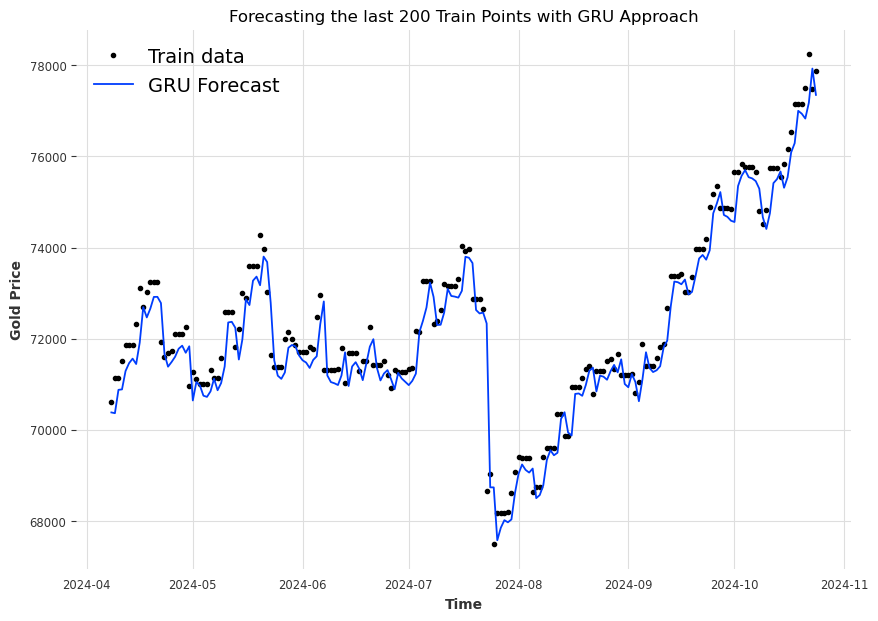

In [241]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [242]:
gru_train_metrics = evaluate_preds(y_pred=preds_holdout_train_gru,
                                      y_true=y_train[-200:])
gru_train_metrics

{'mae': np.float32(403.34317),
 'mse': np.float32(302482.88),
 'rmse': np.float32(549.98444),
 'mape': np.float32(0.5581727)}

##### Persist Metrics

In [243]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics['mape'],
        "Val MAPE": gru_metrics['mape'],
        "Train RMSE": gru_train_metrics['rmse'],
        "Val RMSE": gru_metrics['rmse']
    }])
], ignore_index=True)

#### Regularized Small Model

##### Create Model

In [244]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=12,
    n_rnn_layers=1,
    dropout=0.2,
    batch_size=32,
    n_epochs=100
)

model_gru.name = 'Regularized Small Model'

model_gru.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Epoch 99: 100%|██████████| 123/123 [00:00<00:00, 138.36it/s, train_loss=4.08e-5] 


RNNModel(model=GRU, hidden_dim=12, n_rnn_layers=1, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [245]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.91it/s]


##### Evaluate Predictions

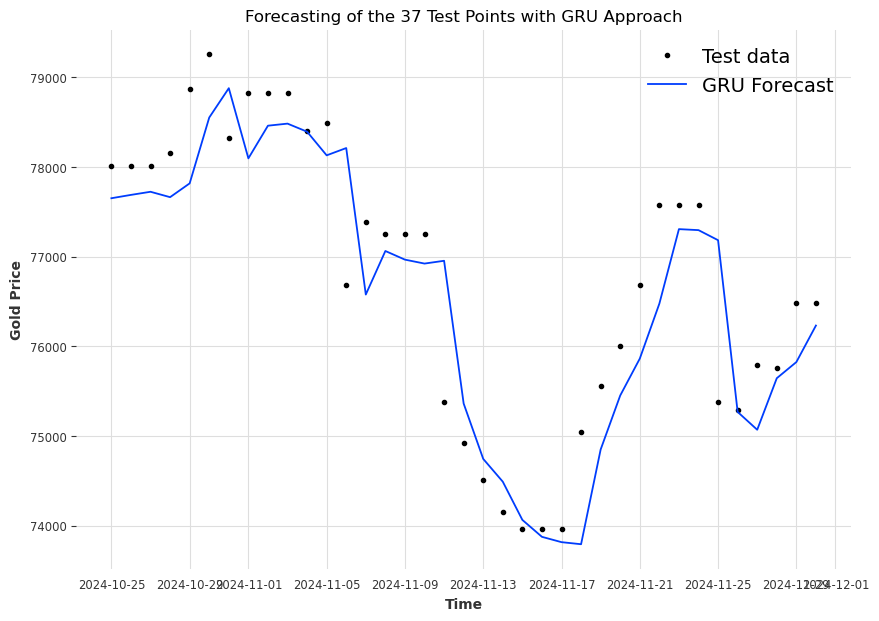

In [ ]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [247]:
gru_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(546.0705),
 'mse': np.float32(490801.12),
 'rmse': np.float32(700.572),
 'mape': np.float32(0.7116004)}

##### Evaluate Overfitting

In [248]:
preds_holdout_train_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.18it/s]


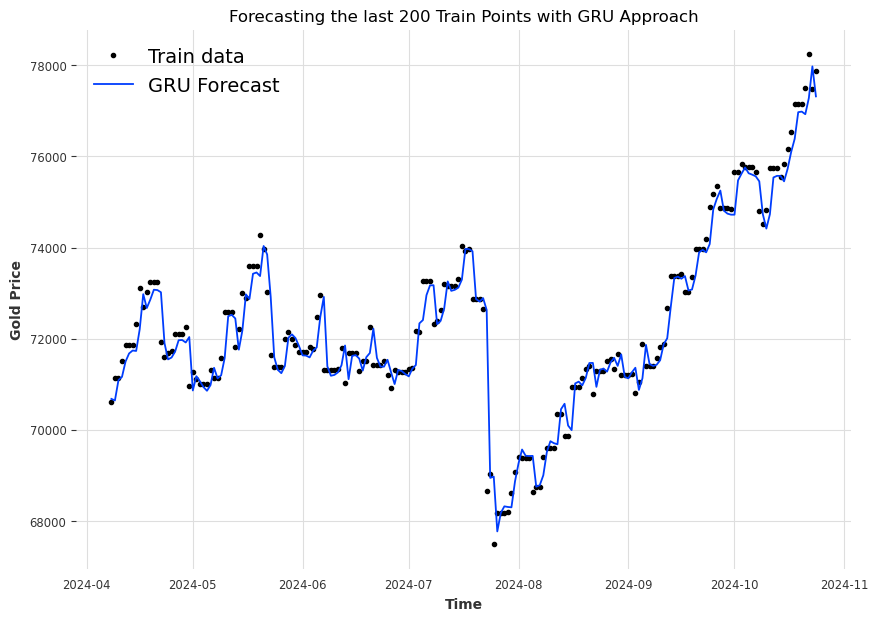

In [249]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [250]:
gru_train_metrics = evaluate_preds(y_pred=preds_holdout_train_gru,
                                      y_true=y_train[-200:])
gru_train_metrics

{'mae': np.float32(328.43253),
 'mse': np.float32(269937.38),
 'rmse': np.float32(519.555),
 'mape': np.float32(0.45458955)}

##### Persist Metrics

In [251]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics['mape'],
        "Val MAPE": gru_metrics['mape'],
        "Train RMSE": gru_train_metrics['rmse'],
        "Val RMSE": gru_metrics['rmse']
    }])
], ignore_index=True)

#### Regularized Big Complex Model

##### Create Model

In [252]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=50,
    n_rnn_layers=5,
    dropout=0.2,
    batch_size=32,
    n_epochs=200
)

model_gru.name = 'Regularized Big Complex Model'

model_gru.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 199: 100%|██████████| 123/123 [00:01<00:00, 61.92it/s, train_loss=0.000143]


RNNModel(model=GRU, hidden_dim=50, n_rnn_layers=5, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=200)

##### Make Predictions

In [253]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]


##### Evaluate Predictions

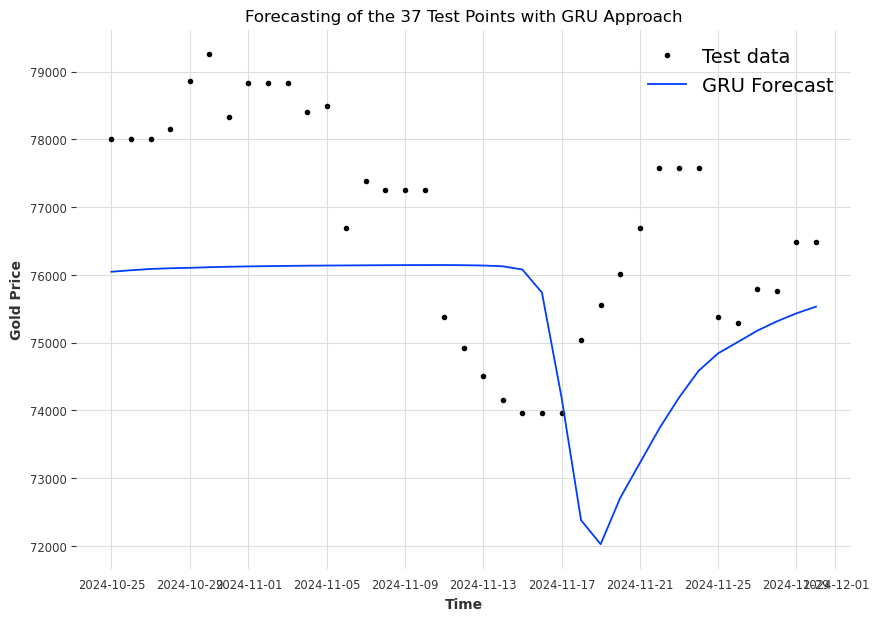

In [ ]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [255]:
gru_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(1907.7465),
 'mse': np.float32(4672031.0),
 'rmse': np.float32(2161.488),
 'mape': np.float32(2.475145)}

##### Evaluate Overfitting

In [256]:
preds_holdout_train_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.58it/s]


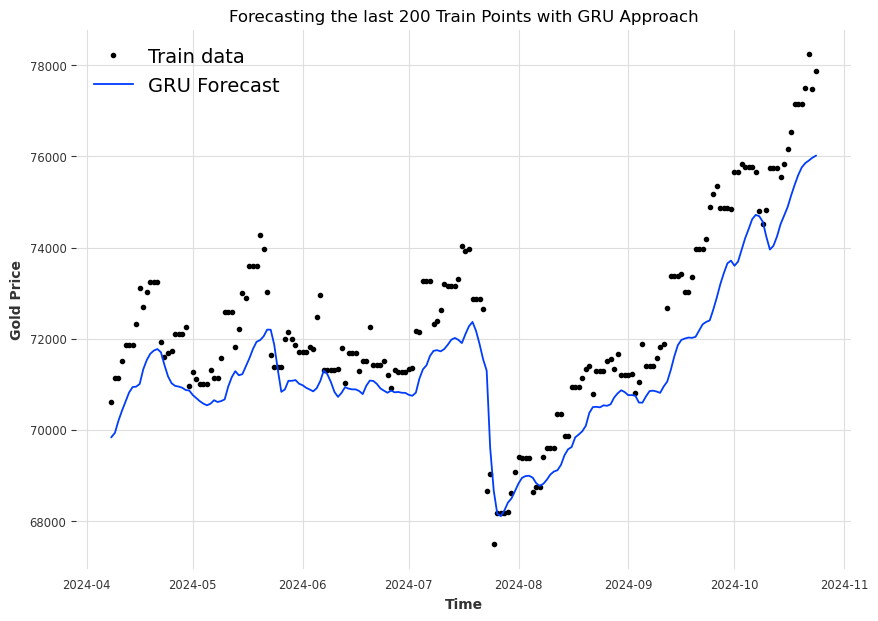

In [257]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [258]:
gru_train_metrics = evaluate_preds(y_pred=preds_holdout_train_gru,
                                      y_true=y_train[-200:])
gru_train_metrics

{'mae': np.float32(1003.6346),
 'mse': np.float32(1367433.8),
 'rmse': np.float32(1169.3732),
 'mape': np.float32(1.3741553)}

##### Persist Metrics

In [259]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics['mape'],
        "Val MAPE": gru_metrics['mape'],
        "Train RMSE": gru_train_metrics['rmse'],
        "Val RMSE": gru_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Regularized Big Complex Model

##### Create Model

In [260]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=50,
    n_rnn_layers=5,
    dropout=0.2,
    batch_size=32,
    n_epochs=1000,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_gru.name = 'Early Stopping Regularized Big Complex Model'

model_gru.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 86: 100%|██████████| 123/123 [00:01<00:00, 69.61it/s, train_loss=0.00014] 


RNNModel(model=GRU, hidden_dim=50, n_rnn_layers=5, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=1000, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A51BA8190>]})

##### Make Predictions

In [261]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.40it/s]


##### Evaluate Predictions

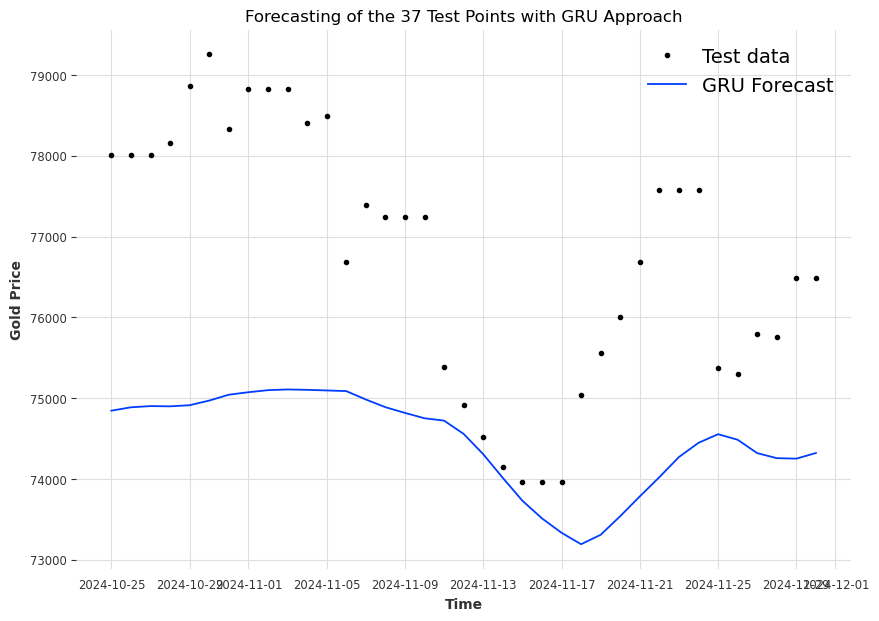

In [ ]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [263]:
gru_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(2284.4722),
 'mse': np.float32(6710272.0),
 'rmse': np.float32(2590.4192),
 'mape': np.float32(2.946195)}

##### Evaluate Overfitting

In [264]:
preds_holdout_train_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.00it/s]


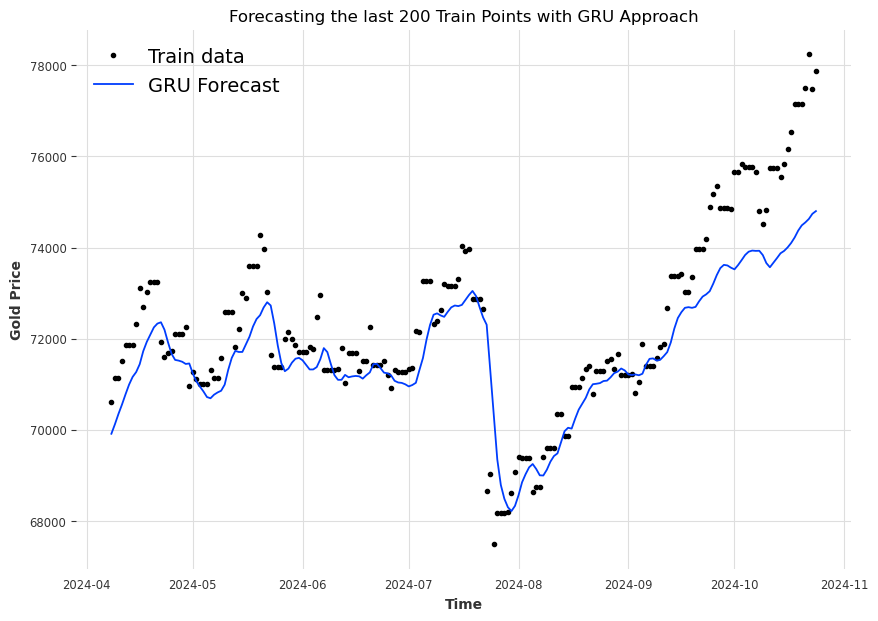

In [265]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [266]:
gru_train_metrics = evaluate_preds(y_pred=preds_holdout_train_gru,
                                      y_true=y_train[-200:])
gru_train_metrics

{'mae': np.float32(829.7951),
 'mse': np.float32(1248111.5),
 'rmse': np.float32(1117.1891),
 'mape': np.float32(1.1305151)}

##### Persist Metrics

In [267]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics['mape'],
        "Val MAPE": gru_metrics['mape'],
        "Train RMSE": gru_train_metrics['rmse'],
        "Val RMSE": gru_metrics['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [268]:
df_models_metrics_gru

Model  Train MAPE  Val MAPE  \
0                                 Default Model    0.482275  0.668682   
1                                   Small Model    0.503277  0.766141   
2                                 Complex Model    0.558173  0.739013   
3                       Regularized Small Model    0.454590  0.711600   
4                 Regularized Big Complex Model    1.374155  2.475145   
5  Early Stopping Regularized Big Complex Model    1.130515  2.946195   

    Train RMSE     Val RMSE  
0   528.606506   695.370117  
1   534.886597   732.111206  
2   549.984436   723.218994  
3   519.554993   700.572021  
4  1169.373169  2161.488037  
5  1117.189087  2590.419189

In [269]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=50,
    n_rnn_layers=5,
    dropout=0.2,
    batch_size=32,
    n_epochs=200
)

model_gru.fit(gold_price_darts_scaled_train_val, future_covariates=gold_price_exogenus_darts_scaled_train_val)

Epoch 199: 100%|██████████| 124/124 [00:01<00:00, 67.01it/s, train_loss=9.54e-5] 


RNNModel(model=GRU, hidden_dim=50, n_rnn_layers=5, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=200)

In [270]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.17it/s]


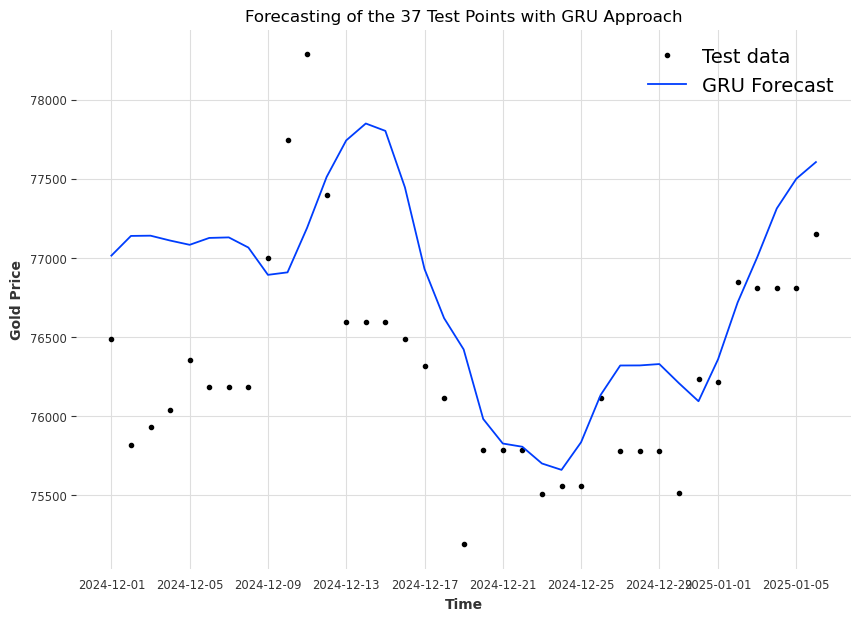

In [271]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with GRU Approach')
plt.show()

In [272]:
gru_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(597.7665),
 'mse': np.float32(530719.1),
 'rmse': np.float32(728.5047),
 'mape': np.float32(0.7830335)}

### N-BEATSx

In [279]:
df_models_metrics_nbeatsx = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [ ]:
model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx.name = 'Default Model'

model_nbeatsx.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:07<00:00, 16.89it/s, train_loss=6.01e-5] 


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [281]:
from utils.preds import make_predictions_rolling_one_past_covariates_darts

In [282]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


##### Evaluate Predictions

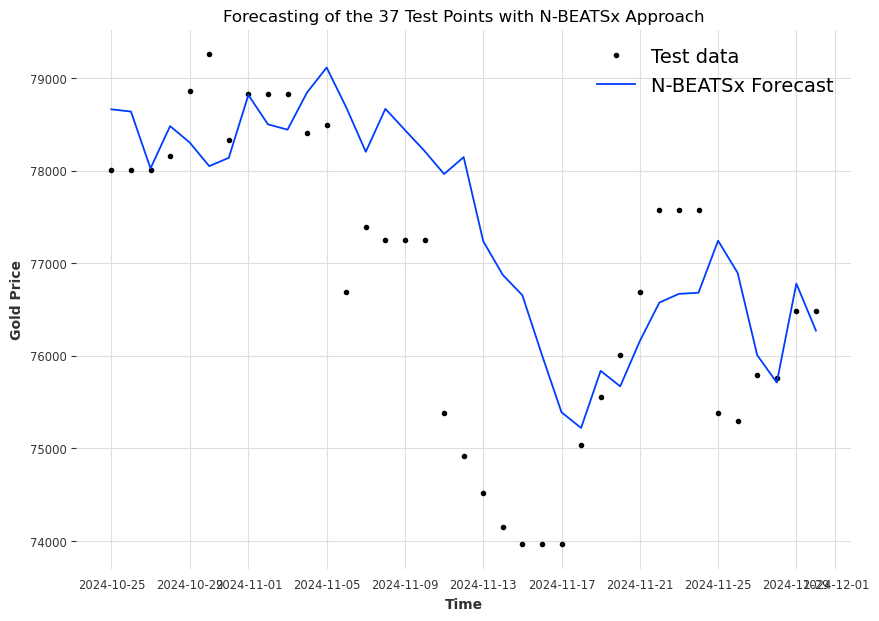

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [284]:
nbeatsx_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(1015.0923),
 'mse': np.float32(1819508.1),
 'rmse': np.float32(1348.8915),
 'mape': np.float32(1.3378427)}

##### Evaluate Overfitting

In [285]:
preds_holdout_train_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]


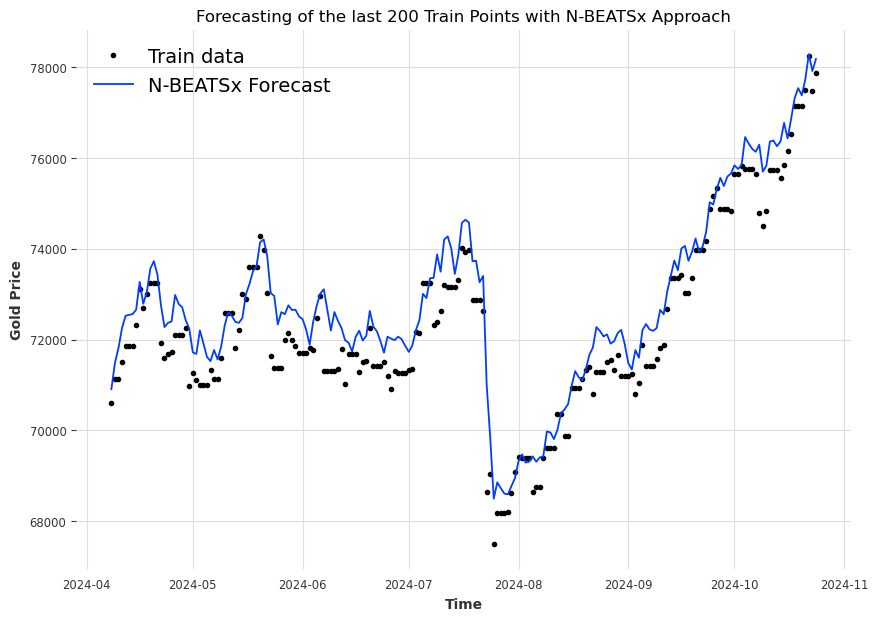

In [286]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [287]:
nbeatsx_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeatsx,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics

{'mae': np.float32(550.2778),
 'mse': np.float32(448621.75),
 'rmse': np.float32(669.7923),
 'mape': np.float32(0.7642567)}

##### Persist Metrics

In [290]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics['mape'],
        "Val MAPE": nbeatsx_metrics['mape'],
        "Train RMSE": nbeatsx_train_metrics['rmse'],
        "Val RMSE": nbeatsx_metrics['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22108\2851691698.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [293]:
model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx.name = 'Small Model'

model_nbeatsx.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:02<00:00, 45.99it/s, train_loss=0.000231]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [294]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.20it/s] 


##### Evaluate Predictions

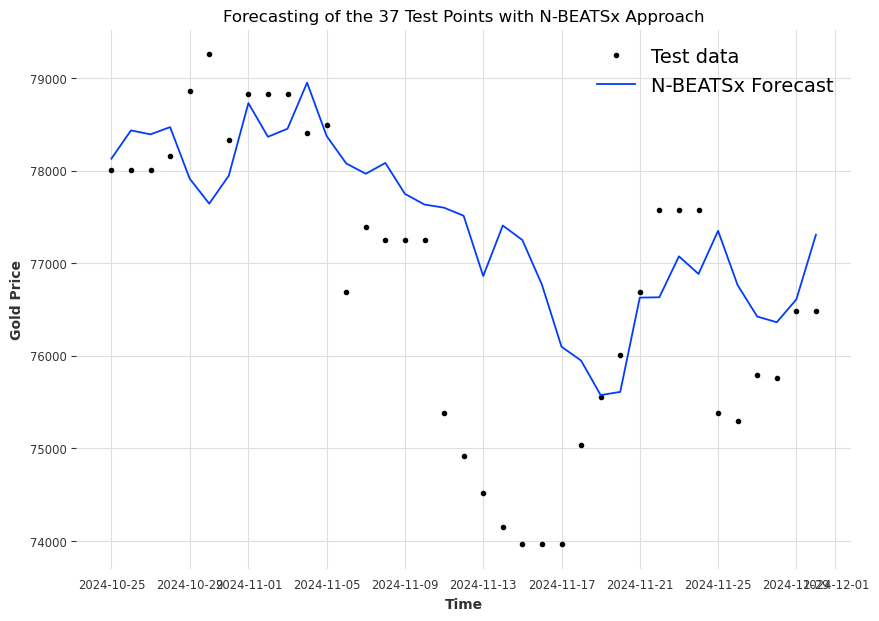

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [296]:
nbeatsx_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(1007.4971),
 'mse': np.float32(1870964.4),
 'rmse': np.float32(1367.832),
 'mape': np.float32(1.3311847)}

##### Evaluate Overfitting

In [297]:
preds_holdout_train_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.04it/s] 


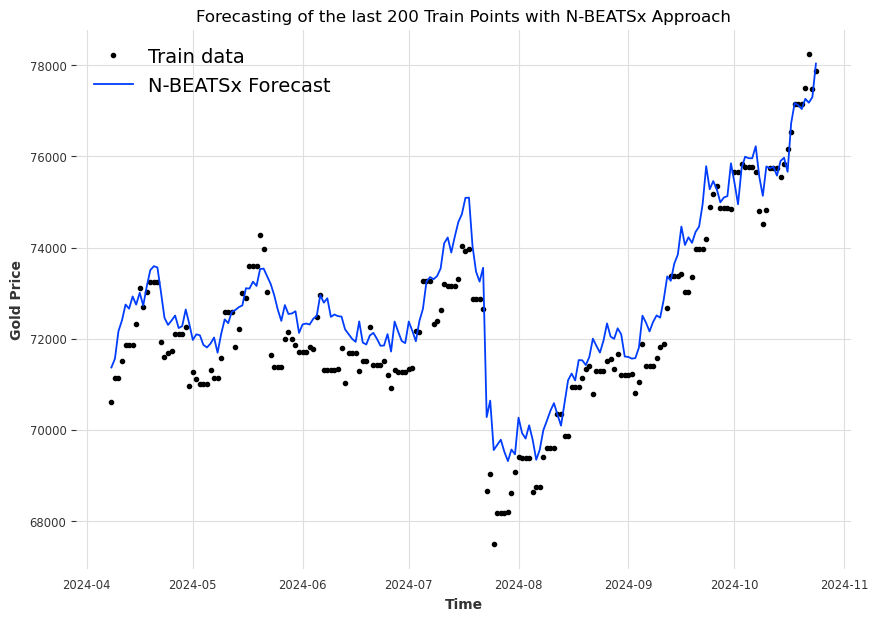

In [298]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [299]:
nbeatsx_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeatsx,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics

{'mae': np.float32(646.3816),
 'mse': np.float32(586681.8),
 'rmse': np.float32(765.9516),
 'mape': np.float32(0.9019257)}

##### Persist Metrics

In [300]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics['mape'],
        "Val MAPE": nbeatsx_metrics['mape'],
        "Train RMSE": nbeatsx_train_metrics['rmse'],
        "Val RMSE": nbeatsx_metrics['rmse']
    }])
], ignore_index=True)

#### Smaller Model

##### Create Model

In [302]:
model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=9,
    num_blocks=1,
    num_layers=2,
    layer_widths=32,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx.name = 'Smaller Model'

model_nbeatsx.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:01<00:00, 66.09it/s, train_loss=8.6e-5]  


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=9, num_blocks=1, num_layers=2, layer_widths=32, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [ ]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s] 


##### Evaluate Predictions

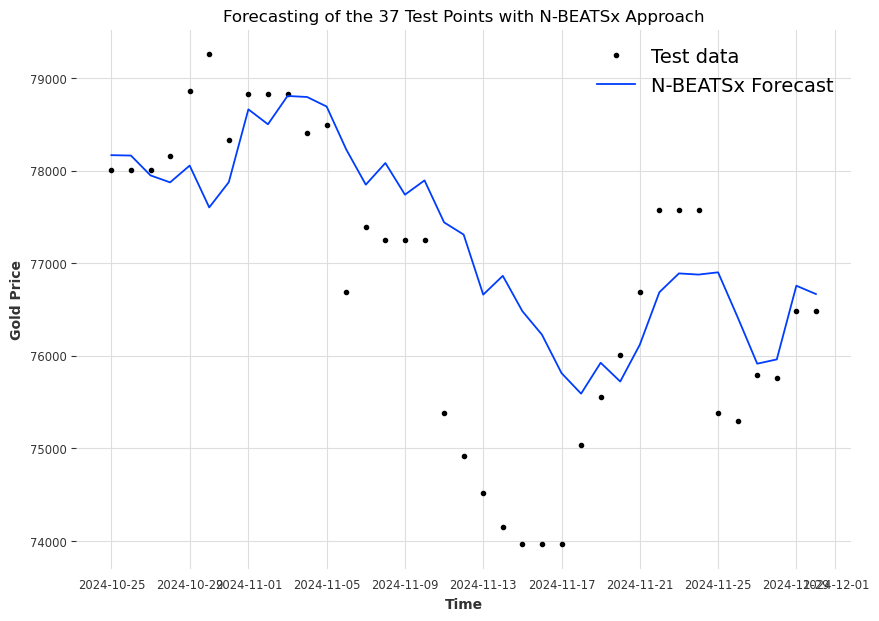

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [305]:
nbeatsx_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(867.3102),
 'mse': np.float32(1382737.9),
 'rmse': np.float32(1175.8988),
 'mape': np.float32(1.1448869)}

##### Evaluate Overfitting

In [306]:
preds_holdout_train_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.60it/s]


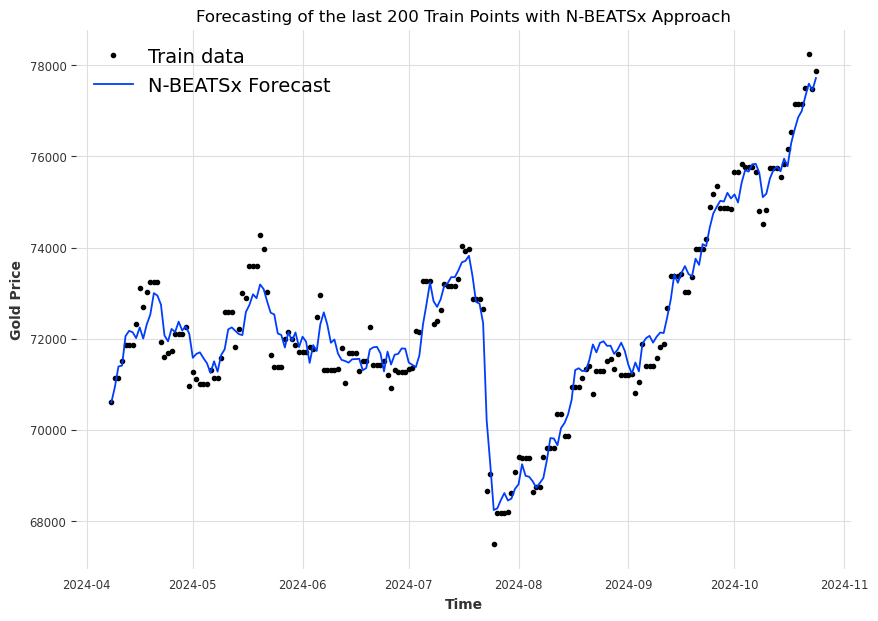

In [307]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [308]:
nbeatsx_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeatsx,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics

{'mae': np.float32(369.8393),
 'mse': np.float32(213918.64),
 'rmse': np.float32(462.5134),
 'mape': np.float32(0.5129911)}

##### Persist Metrics

In [309]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics['mape'],
        "Val MAPE": nbeatsx_metrics['mape'],
        "Train RMSE": nbeatsx_train_metrics['rmse'],
        "Val RMSE": nbeatsx_metrics['rmse']
    }])
], ignore_index=True)

#### Regularized Small Model

##### Create Model

In [311]:
model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0.2,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx.name = 'Regularized Small Model'

model_nbeatsx.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:02<00:00, 42.72it/s, train_loss=0.000241]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [312]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.93it/s] 


##### Evaluate Predictions

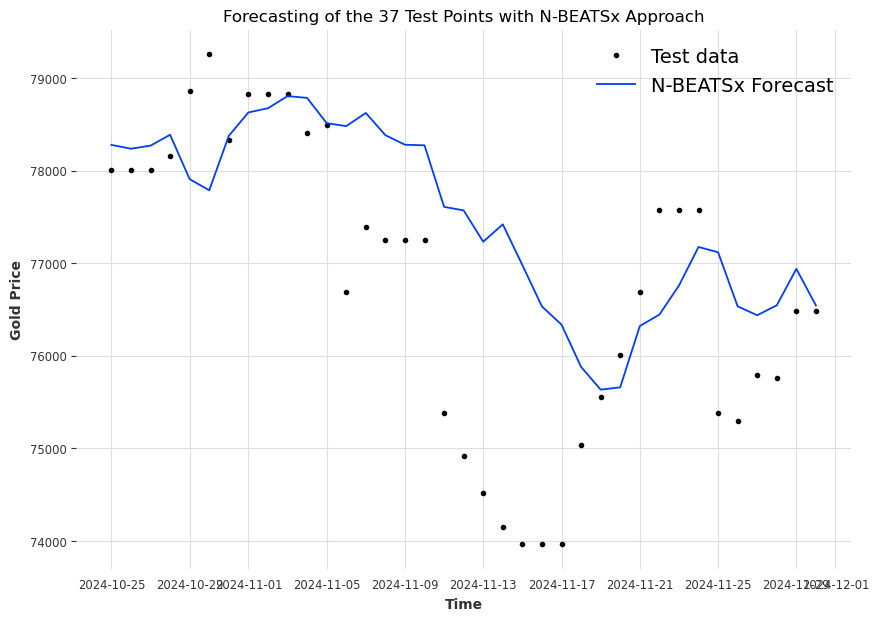

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [314]:
nbeatsx_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(1032.8302),
 'mse': np.float32(1945059.0),
 'rmse': np.float32(1394.6537),
 'mape': np.float32(1.364667)}

##### Evaluate Overfitting

In [315]:
preds_holdout_train_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.92it/s] 


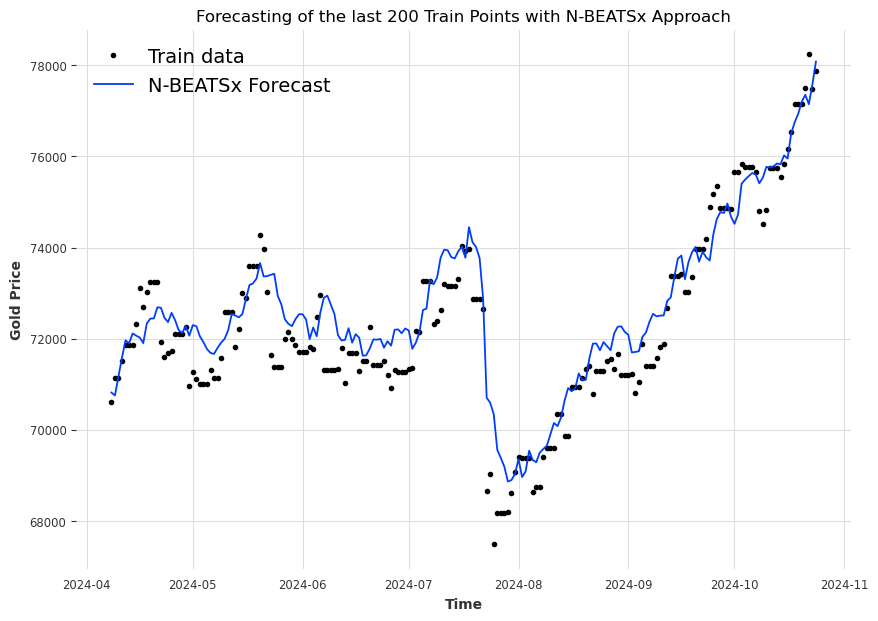

In [316]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [317]:
nbeatsx_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeatsx,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics

{'mae': np.float32(571.84094),
 'mse': np.float32(530117.94),
 'rmse': np.float32(728.092),
 'mape': np.float32(0.7969323)}

##### Persist Metrics

In [318]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics['mape'],
        "Val MAPE": nbeatsx_metrics['mape'],
        "Train RMSE": nbeatsx_train_metrics['rmse'],
        "Val RMSE": nbeatsx_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Small Model

##### Create Model

In [320]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_nbeatsx.name = 'Early Stopping Small Model'

model_nbeatsx.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 80: 100%|██████████| 123/123 [00:02<00:00, 45.53it/s, train_loss=0.000437]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A621ABFA0>]})

##### Make Predictions

In [321]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s] 


##### Evaluate Predictions

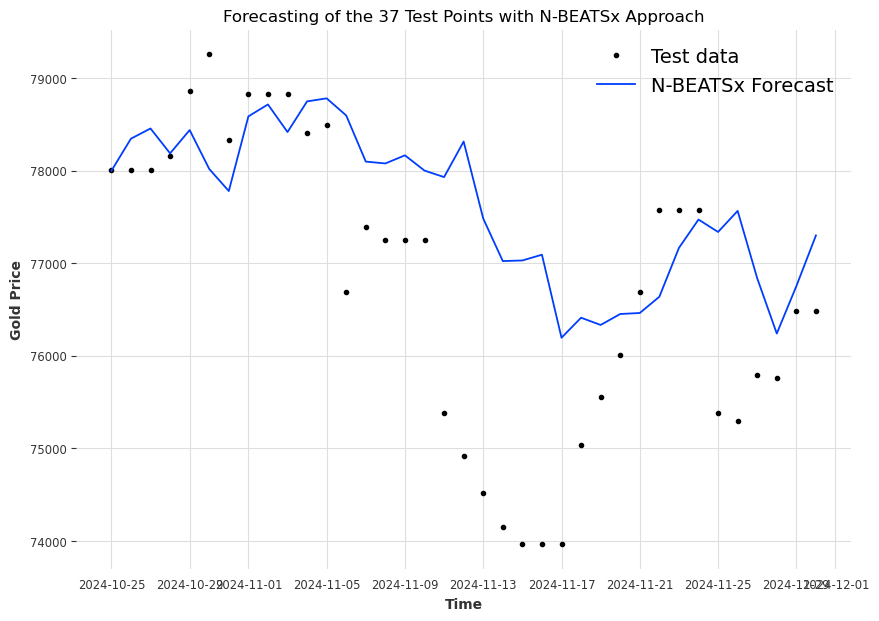

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [323]:
nbeatsx_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(1105.1184),
 'mse': np.float32(2246300.5),
 'rmse': np.float32(1498.7664),
 'mape': np.float32(1.4625064)}

##### Evaluate Overfitting

In [324]:
preds_holdout_train_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.22it/s] 


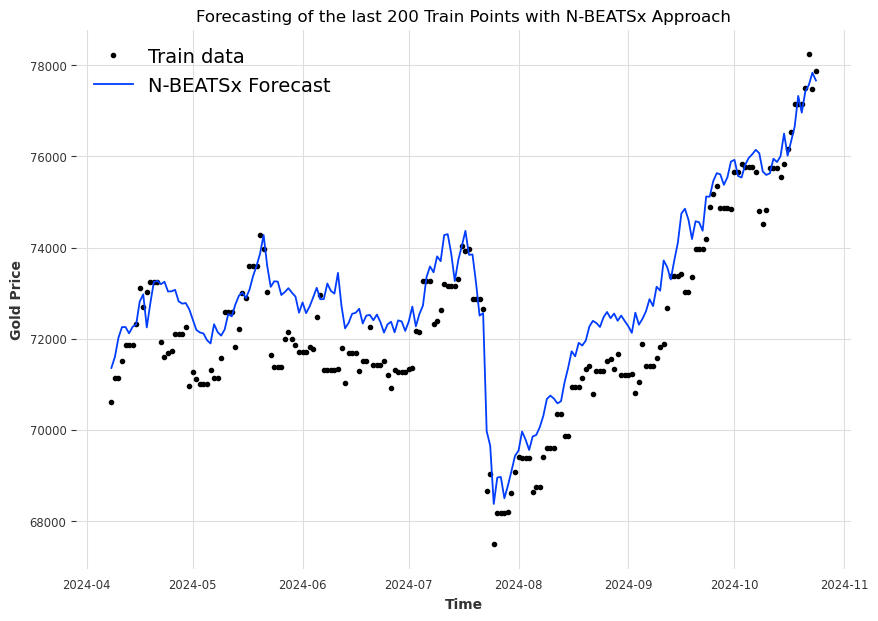

In [325]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [326]:
nbeatsx_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeatsx,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics

{'mae': np.float32(784.7477),
 'mse': np.float32(852232.2),
 'rmse': np.float32(923.16425),
 'mape': np.float32(1.0941167)}

##### Persist Metrics

In [327]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics['mape'],
        "Val MAPE": nbeatsx_metrics['mape'],
        "Train RMSE": nbeatsx_train_metrics['rmse'],
        "Val RMSE": nbeatsx_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Default Model

##### Create Model

In [330]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_nbeatsx.name = 'Early Stopping Default Model'

model_nbeatsx.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 50: 100%|██████████| 123/123 [00:06<00:00, 18.11it/s, train_loss=6.92e-5] 


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A62230790>]})

##### Make Predictions

In [331]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.77it/s]


##### Evaluate Predictions

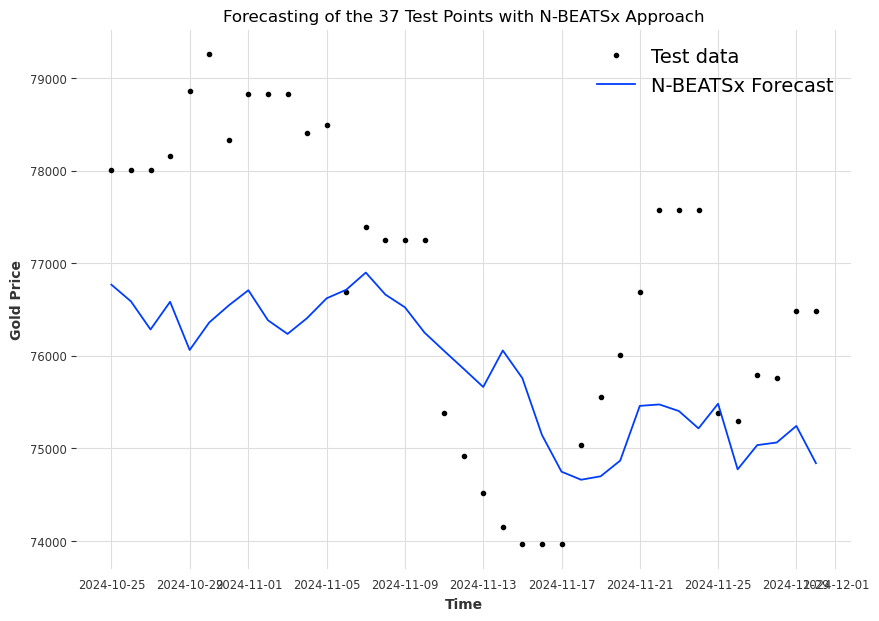

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [333]:
nbeatsx_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(1376.1968),
 'mse': np.float32(2452417.8),
 'rmse': np.float32(1566.0198),
 'mape': np.float32(1.7821361)}

##### Evaluate Overfitting

In [334]:
preds_holdout_train_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.92it/s]


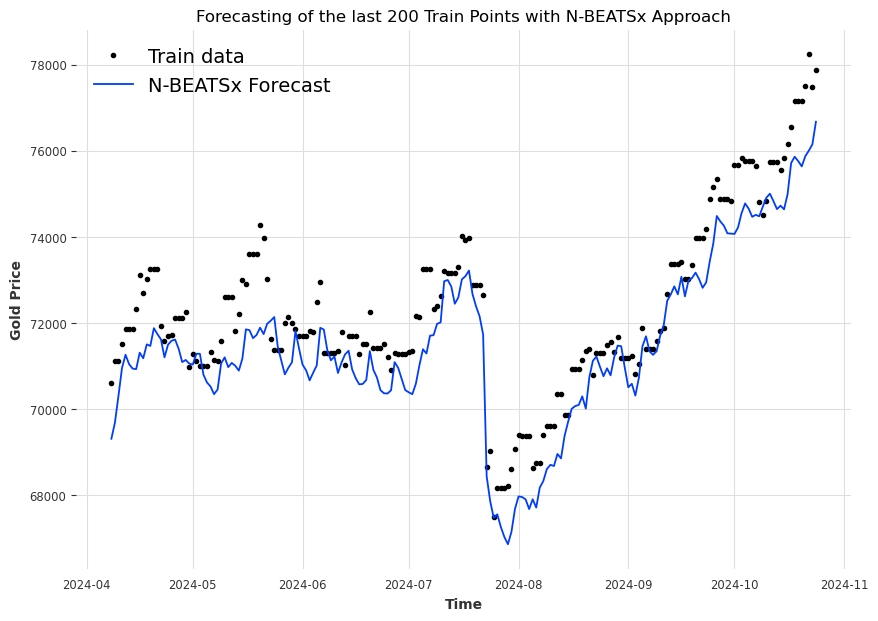

In [335]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [336]:
nbeatsx_train_metrics = evaluate_preds(y_pred=preds_holdout_train_nbeatsx,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics

{'mae': np.float32(837.548),
 'mse': np.float32(966815.4),
 'rmse': np.float32(983.2677),
 'mape': np.float32(1.1536639)}

##### Persist Metrics

In [337]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics['mape'],
        "Val MAPE": nbeatsx_metrics['mape'],
        "Train RMSE": nbeatsx_train_metrics['rmse'],
        "Val RMSE": nbeatsx_metrics['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [338]:
df_models_metrics_nbeatsx

Model  Train MAPE  Val MAPE  Train RMSE     Val RMSE
0                 Default Model    0.764257  1.337843  669.792297  1348.891479
1                   Small Model    0.901926  1.331185  765.951599  1367.832031
2                 Smaller Model    0.512991  1.144887  462.513397  1175.898804
3       Regularized Small Model    0.796932  1.364667  728.091980  1394.653687
4    Early Stopping Small Model    1.094117  1.462506  923.164246  1498.766357
5  Early Stopping Default Model    1.153664  1.782136  983.267700  1566.019775

In [339]:
model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx.fit(series=gold_price_darts_scaled_train_val, past_covariates=gold_price_exogenus_darts_scaled_train_val)

Epoch 99: 100%|██████████| 124/124 [00:02<00:00, 44.70it/s, train_loss=0.000177]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

In [340]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


In [341]:
nbeatsx_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(1319.3918),
 'mse': np.float32(2146065.0),
 'rmse': np.float32(1464.9454),
 'mape': np.float32(1.726277)}

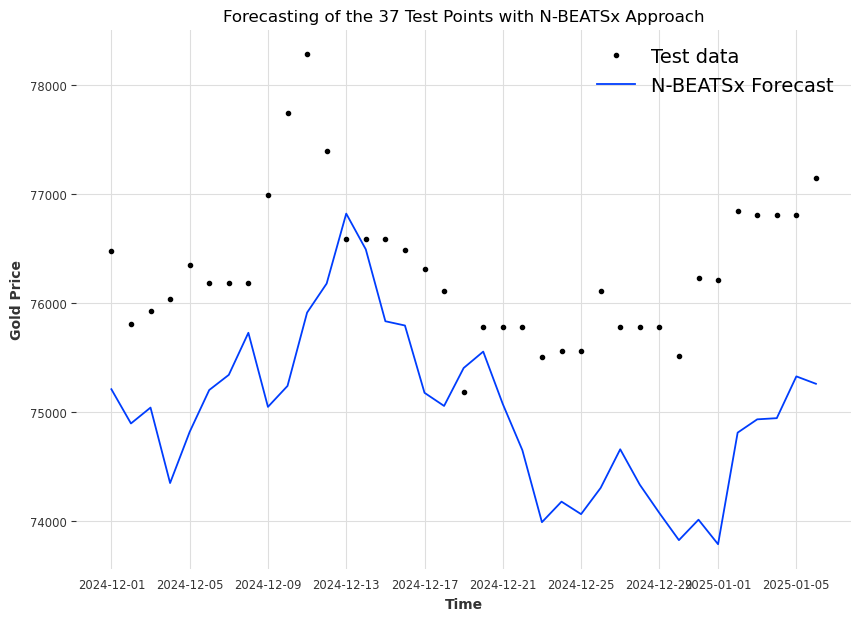

In [342]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with N-BEATSx Approach')
plt.show()

### TCN (Temporal Convolutional Networks)

In [ ]:
from darts.models import TCNModel

In [ ]:
df_models_metrics_tcn = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [348]:
model_tcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=3,
    num_filters=3,
    num_layers=None,
    dilation_base=2,
    weight_norm=False,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn.name = 'Default Model'

model_tcn.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:00<00:00, 129.83it/s, train_loss=2.34e-5] 


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [349]:
preds_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.25it/s]


##### Evaluate Predictions

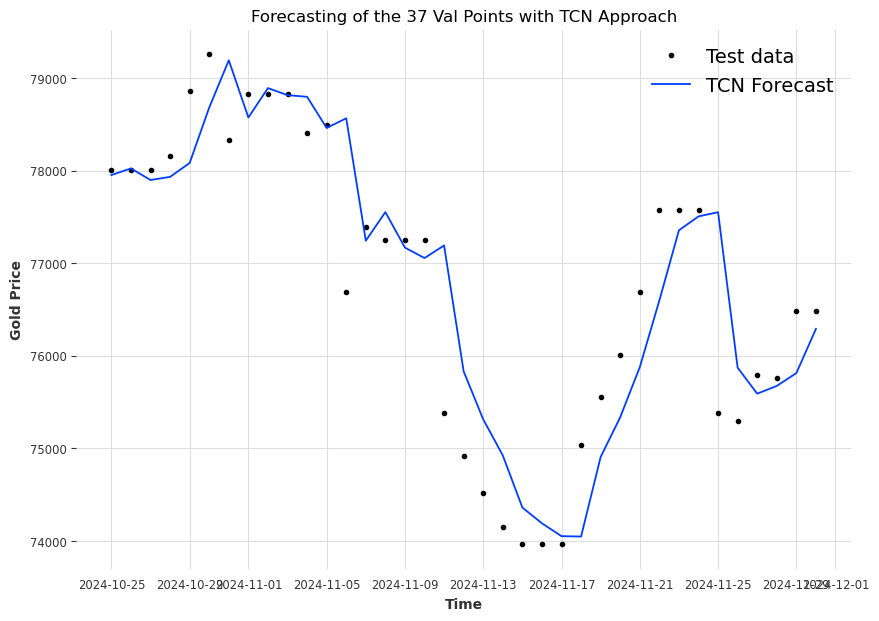

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [351]:
tcn_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn)
tcn_metrics

{'mae': np.float32(521.4018),
 'mse': np.float32(550018.5),
 'rmse': np.float32(741.6323),
 'mape': np.float32(0.6839996)}

##### Evaluate Overfitting

In [352]:
preds_holdout_train_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.12it/s]


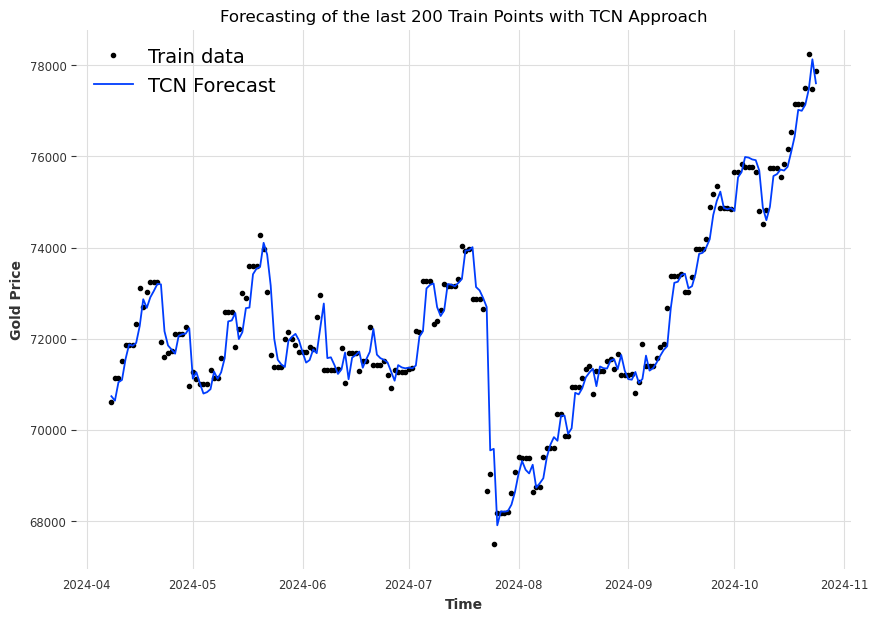

In [353]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [354]:
tcn_train_metrics = evaluate_preds(y_pred=preds_holdout_train_tcn,
                                      y_true=y_train[-200:])
tcn_train_metrics

{'mae': np.float32(339.88757),
 'mse': np.float32(290857.97),
 'rmse': np.float32(539.3125),
 'mape': np.float32(0.47133183)}

##### Persist Metrics

In [355]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics['mape'],
        "Val MAPE": tcn_metrics['mape'],
        "Train RMSE": tcn_train_metrics['rmse'],
        "Val RMSE": tcn_metrics['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22108\3964244345.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [357]:
model_tcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=2,
    num_filters=2,
    num_layers=None,
    dilation_base=1,
    weight_norm=False,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn.name = 'Small Model'

model_tcn.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:01<00:00, 66.89it/s, train_loss=4.53e-5] 


TCNModel(output_chunk_shift=0, kernel_size=2, num_filters=2, num_layers=None, dilation_base=1, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [358]:
preds_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.75it/s] 


##### Evaluate Predictions

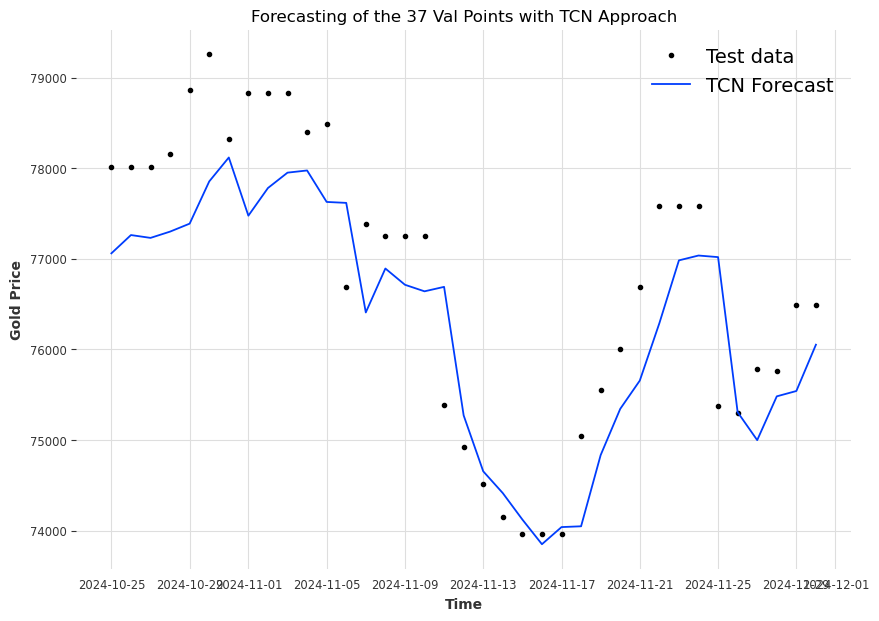

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [360]:
tcn_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn)
tcn_metrics

{'mae': np.float32(723.2095),
 'mse': np.float32(703102.06),
 'rmse': np.float32(838.51184),
 'mape': np.float32(0.9369191)}

##### Evaluate Overfitting

In [361]:
preds_holdout_train_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.40it/s]


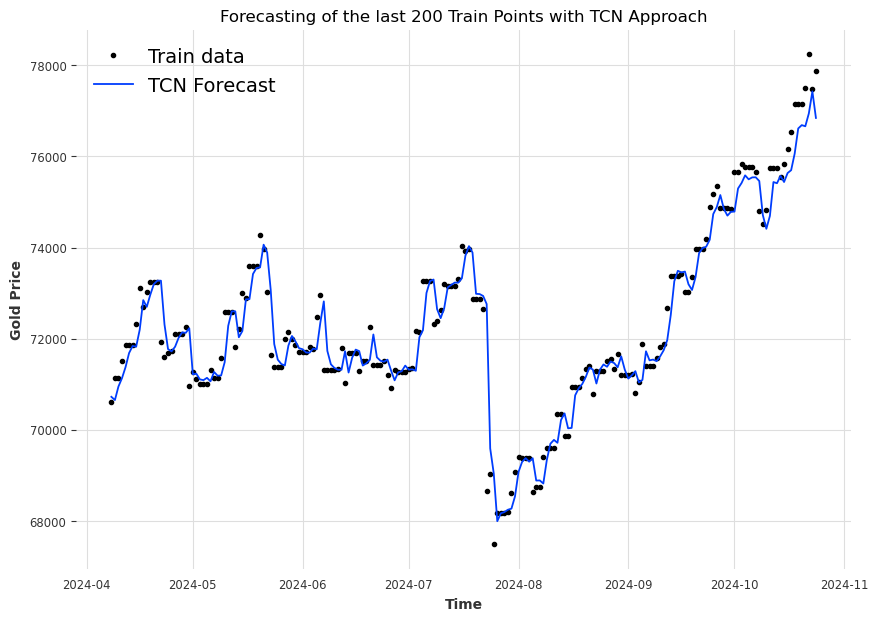

In [362]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [363]:
tcn_train_metrics = evaluate_preds(y_pred=preds_holdout_train_tcn,
                                      y_true=y_train[-200:])
tcn_train_metrics

{'mae': np.float32(349.2402),
 'mse': np.float32(307423.47),
 'rmse': np.float32(554.4578),
 'mape': np.float32(0.48240265)}

##### Persist Metrics

In [364]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics['mape'],
        "Val MAPE": tcn_metrics['mape'],
        "Train RMSE": tcn_train_metrics['rmse'],
        "Val RMSE": tcn_metrics['rmse']
    }])
], ignore_index=True)

#### Complex Model

##### Create Model

In [366]:
model_tcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=4,
    num_filters=4,
    num_layers=4,
    dilation_base=3,
    weight_norm=True,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn.name = 'Complex Model'

model_tcn.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:01<00:00, 111.88it/s, train_loss=3.5e-5]  


TCNModel(output_chunk_shift=0, kernel_size=4, num_filters=4, num_layers=4, dilation_base=3, weight_norm=True, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [367]:
preds_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.23it/s]


##### Evaluate Predictions

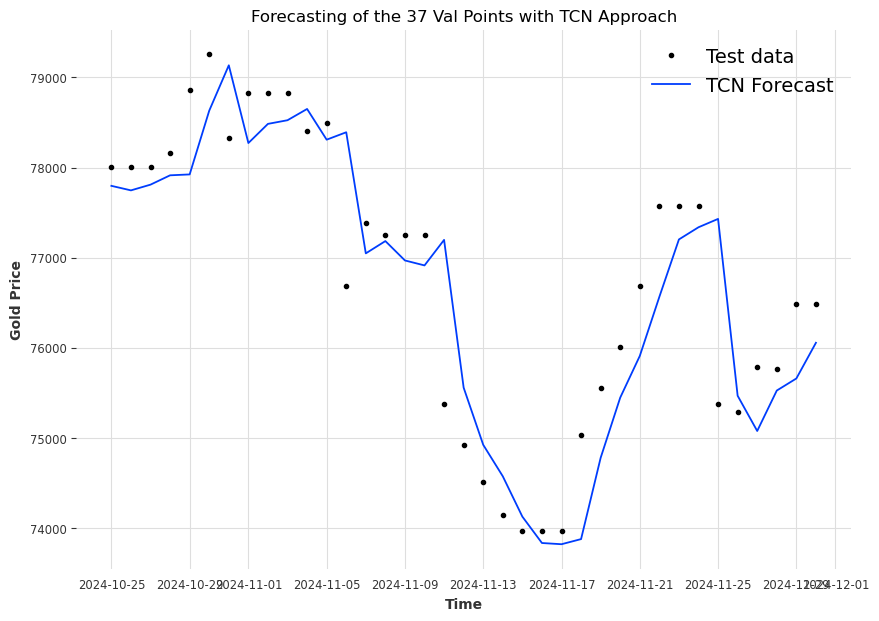

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [369]:
tcn_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn)
tcn_metrics

{'mae': np.float32(559.4932),
 'mse': np.float32(536394.6),
 'rmse': np.float32(732.38965),
 'mape': np.float32(0.7308616)}

##### Evaluate Overfitting

In [370]:
preds_holdout_train_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.64it/s]


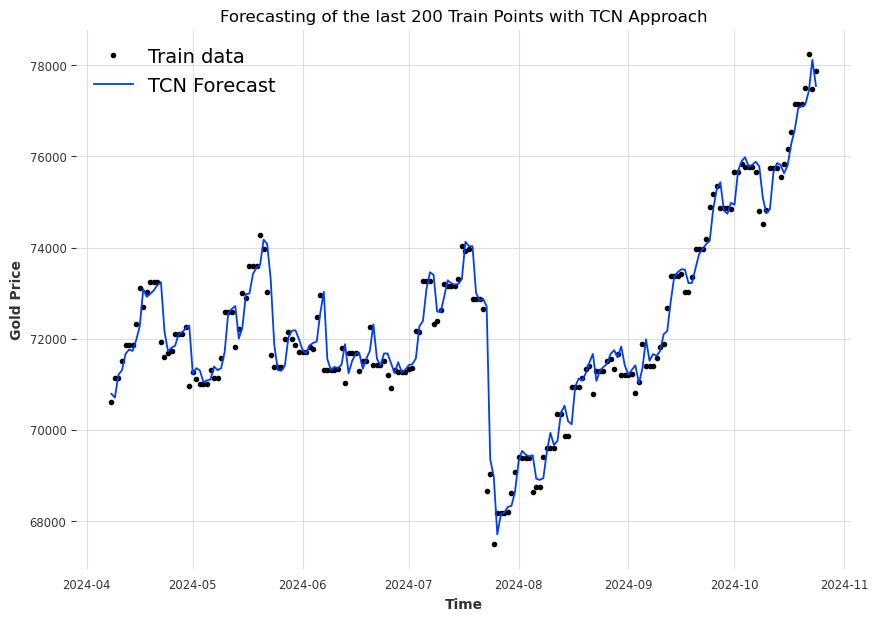

In [371]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [372]:
tcn_train_metrics = evaluate_preds(y_pred=preds_holdout_train_tcn,
                                      y_true=y_train[-200:])
tcn_train_metrics

{'mae': np.float32(320.83136),
 'mse': np.float32(278899.12),
 'rmse': np.float32(528.109),
 'mape': np.float32(0.44534746)}

##### Persist Metrics

In [373]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics['mape'],
        "Val MAPE": tcn_metrics['mape'],
        "Train RMSE": tcn_train_metrics['rmse'],
        "Val RMSE": tcn_metrics['rmse']
    }])
], ignore_index=True)

#### Less Complex but still Complex

##### Create Model

In [375]:
model_tcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=4,
    num_filters=4,
    num_layers=None,
    dilation_base=3,
    weight_norm=False,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn.name = 'Less Complex Model'

model_tcn.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 123/123 [00:00<00:00, 134.07it/s, train_loss=2.86e-5] 


TCNModel(output_chunk_shift=0, kernel_size=4, num_filters=4, num_layers=None, dilation_base=3, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [376]:
preds_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.41it/s]


##### Evaluate Predictions

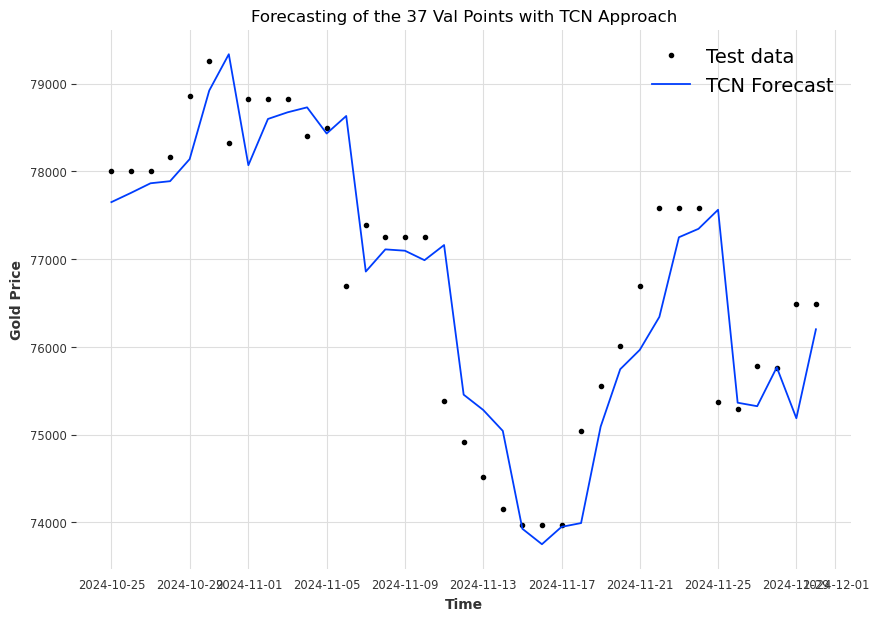

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [378]:
tcn_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn)
tcn_metrics

{'mae': np.float32(553.8691),
 'mse': np.float32(597678.0),
 'rmse': np.float32(773.0964),
 'mape': np.float32(0.7239558)}

##### Evaluate Overfitting

In [379]:
preds_holdout_train_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.30it/s]


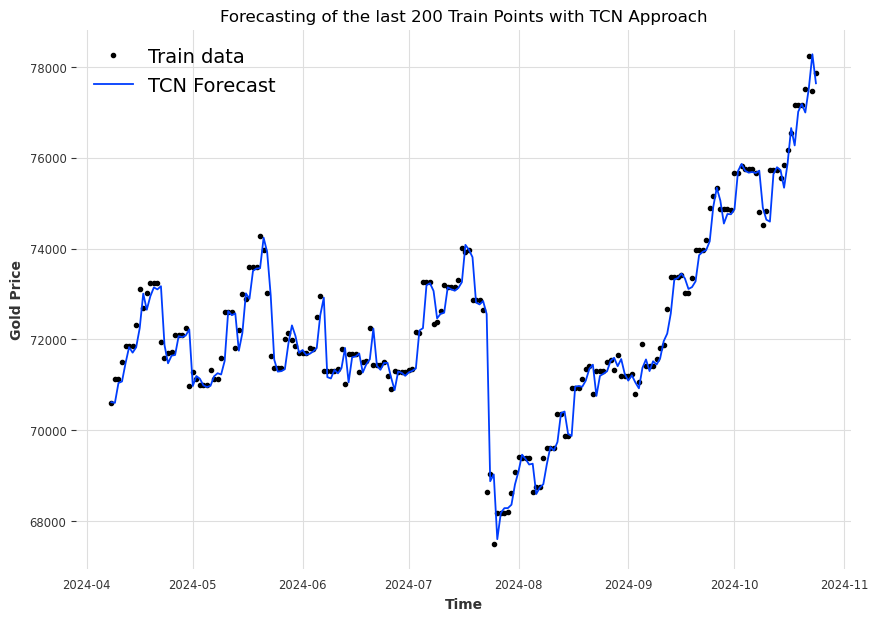

In [380]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [381]:
tcn_train_metrics = evaluate_preds(y_pred=preds_holdout_train_tcn,
                                      y_true=y_train[-200:])
tcn_train_metrics

{'mae': np.float32(314.64157),
 'mse': np.float32(269309.84),
 'rmse': np.float32(518.95074),
 'mape': np.float32(0.43616003)}

##### Persist Metrics

In [382]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics['mape'],
        "Val MAPE": tcn_metrics['mape'],
        "Train RMSE": tcn_train_metrics['rmse'],
        "Val RMSE": tcn_metrics['rmse']
    }])
], ignore_index=True)

#### Regularized Default

##### Create Model

In [ ]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_tcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=3,
    num_filters=3,
    num_layers=None,
    dilation_base=2,
    weight_norm=False,
    dropout=0.2,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn.name = 'Regularized Default Model'

model_tcn.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 4:  64%|██████▍   | 79/123 [00:00<00:00, 106.01it/s, train_loss=0.014]  

NameError: name 'exit' is not defined

##### Make Predictions

In [385]:
preds_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]


##### Evaluate Predictions

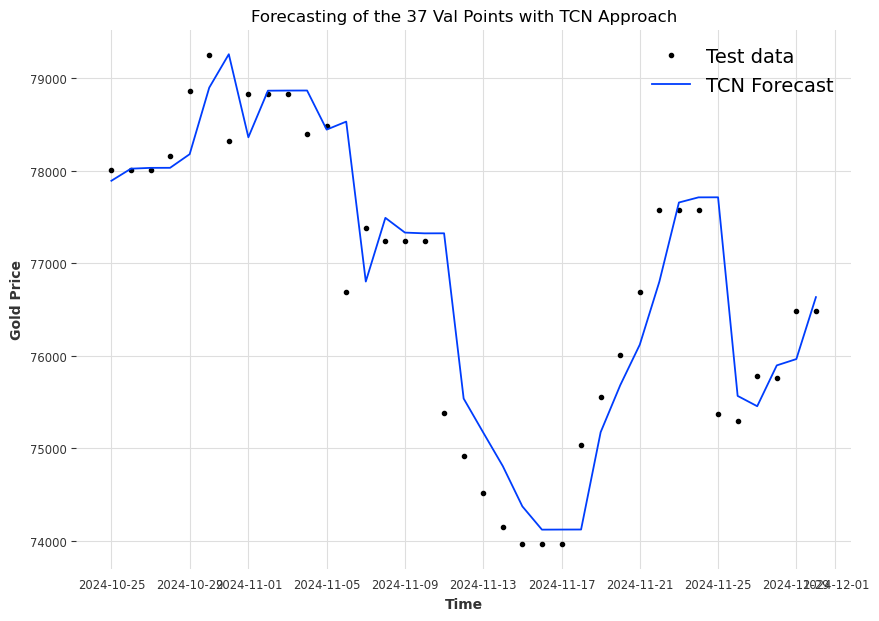

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [387]:
tcn_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn)
tcn_metrics

{'mae': np.float32(477.95398),
 'mse': np.float32(513659.47),
 'rmse': np.float32(716.7004),
 'mape': np.float32(0.6267014)}

##### Evaluate Overfitting

In [388]:
preds_holdout_train_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]


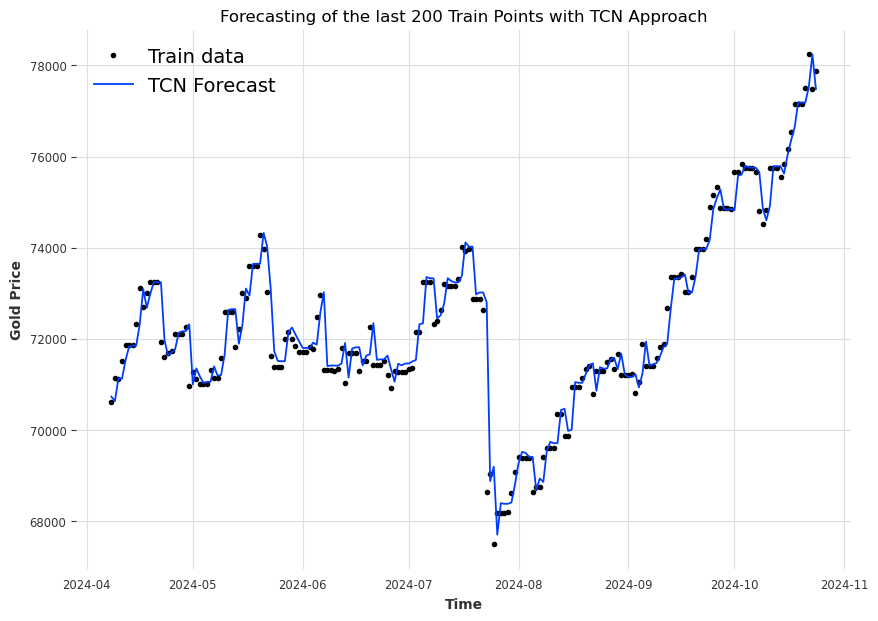

In [389]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [390]:
tcn_train_metrics = evaluate_preds(y_pred=preds_holdout_train_tcn,
                                      y_true=y_train[-200:])
tcn_train_metrics

{'mae': np.float32(320.0825),
 'mse': np.float32(281448.94),
 'rmse': np.float32(530.51764),
 'mape': np.float32(0.44463226)}

##### Persist Metrics

In [391]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics['mape'],
        "Val MAPE": tcn_metrics['mape'],
        "Train RMSE": tcn_train_metrics['rmse'],
        "Val RMSE": tcn_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Regularized Default Model

##### Create Model 

In [ ]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_tcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=3,
    num_filters=3,
    num_layers=None,
    dilation_base=2,
    weight_norm=False,
    dropout=0.2,
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_tcn.name = 'Early Stopping Regularized Default Model'

model_tcn.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 19: 100%|██████████| 123/123 [00:01<00:00, 104.55it/s, train_loss=0.000444]


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A6E6AAD40>]})

##### Make Predictions

In [396]:
preds_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.01it/s]


##### Evaluate Predictions

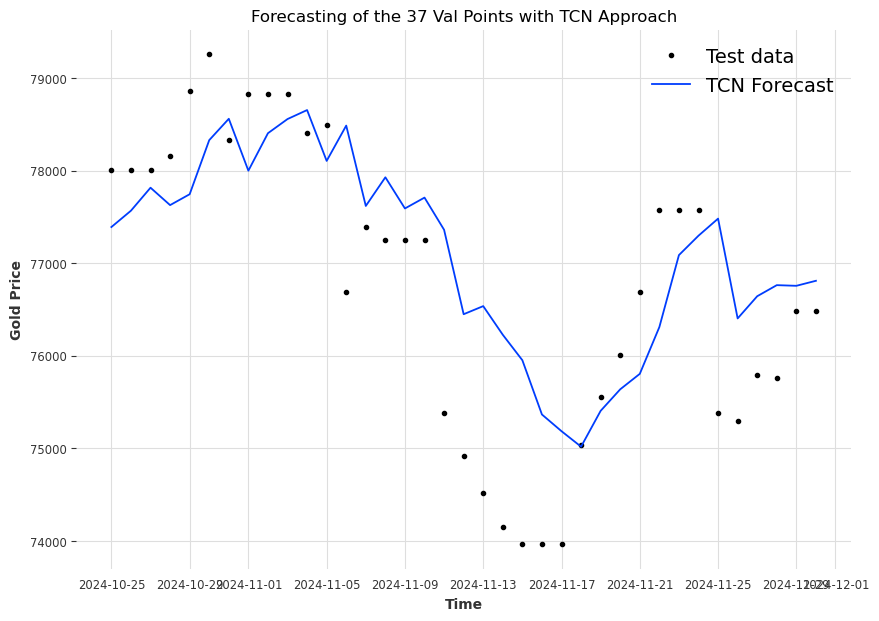

In [ ]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [398]:
tcn_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn)
tcn_metrics

{'mae': np.float32(840.477),
 'mse': np.float32(1103016.5),
 'rmse': np.float32(1050.246),
 'mape': np.float32(1.1054156)}

##### Evaluate Overfitting

In [399]:
preds_holdout_train_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]


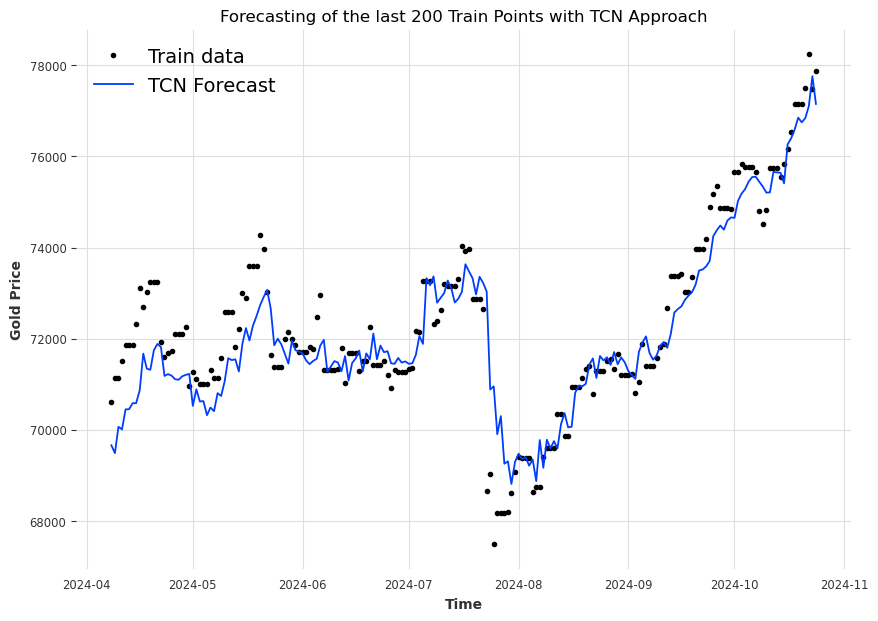

In [400]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [401]:
tcn_train_metrics = evaluate_preds(y_pred=preds_holdout_train_tcn,
                                      y_true=y_train[-200:])
tcn_train_metrics

{'mae': np.float32(590.7563),
 'mse': np.float32(689652.9),
 'rmse': np.float32(830.4534),
 'mape': np.float32(0.8197407)}

##### Persist Metrics

In [402]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics['mape'],
        "Val MAPE": tcn_metrics['mape'],
        "Train RMSE": tcn_train_metrics['rmse'],
        "Val RMSE": tcn_metrics['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [403]:
df_models_metrics_tcn

Model  Train MAPE  Val MAPE  Train RMSE  \
0                             Default Model    0.471332  0.684000  539.312500   
1                               Small Model    0.482403  0.936919  554.457825   
2                             Complex Model    0.445347  0.730862  528.109009   
3                        Less Complex Model    0.436160  0.723956  518.950745   
4                 Regularized Default Model    0.444632  0.626701  530.517639   
5  Early Stopping Regularized Default Model    0.819741  1.105416  830.453430   

      Val RMSE  
0   741.632324  
1   838.511841  
2   732.389648  
3   773.096375  
4   716.700378  
5  1050.245972

In [404]:
model_tcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=3,
    num_filters=3,
    num_layers=None,
    dilation_base=2,
    weight_norm=False,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn.fit(gold_price_darts_scaled_train_val, past_covariates=gold_price_exogenus_darts_scaled_train_val)

Epoch 99: 100%|██████████| 124/124 [00:00<00:00, 131.63it/s, train_loss=2.87e-5] 


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

In [405]:
preds_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


In [406]:
tcn_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_tcn)
tcn_metrics

{'mae': np.float32(292.46494),
 'mse': np.float32(179279.66),
 'rmse': np.float32(423.41428),
 'mape': np.float32(0.3820821)}

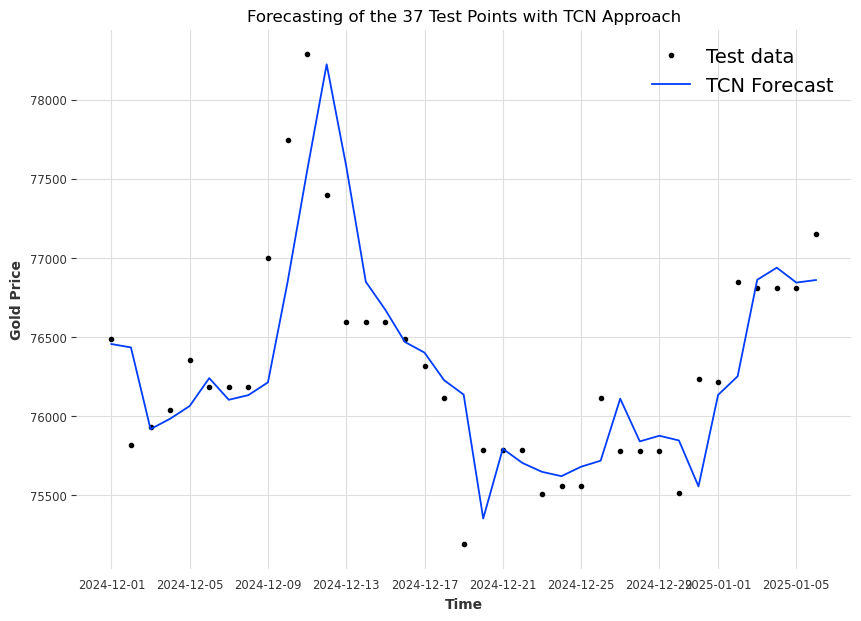

In [413]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with TCN Approach')
plt.show()

### vTRF (Vanilla Transformer)

In [415]:
from darts.models import TransformerModel

In [414]:
df_models_metrics_vtrf = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [417]:
model_vtrf = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=64,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.1,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf.name = 'Default Model'

model_vtrf.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 0:   0%|          | 0/123 [00:00<?, ?it/s] 

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\functional.py:5504: UserWarning:

1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)



Epoch 99: 100%|██████████| 123/123 [00:03<00:00, 39.52it/s, train_loss=0.000628]


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [ ]:
preds_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.60it/s]


##### Evaluate Predictions

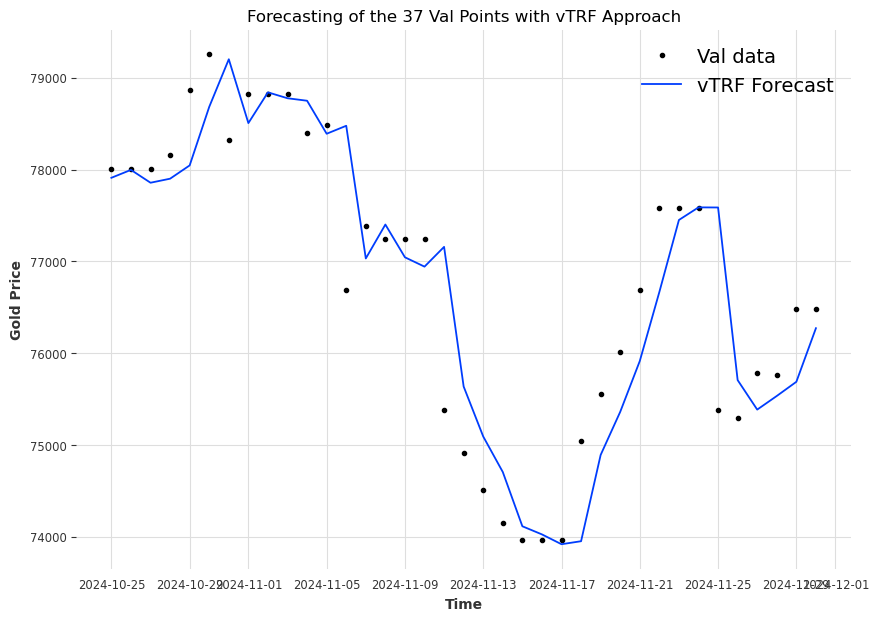

In [ ]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [420]:
vtrf_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf)
vtrf_metrics

{'mae': np.float32(508.0074),
 'mse': np.float32(523461.4),
 'rmse': np.float32(723.50635),
 'mape': np.float32(0.66524446)}

##### Evaluate Overfitting

In [421]:
preds_holdout_train_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s] 


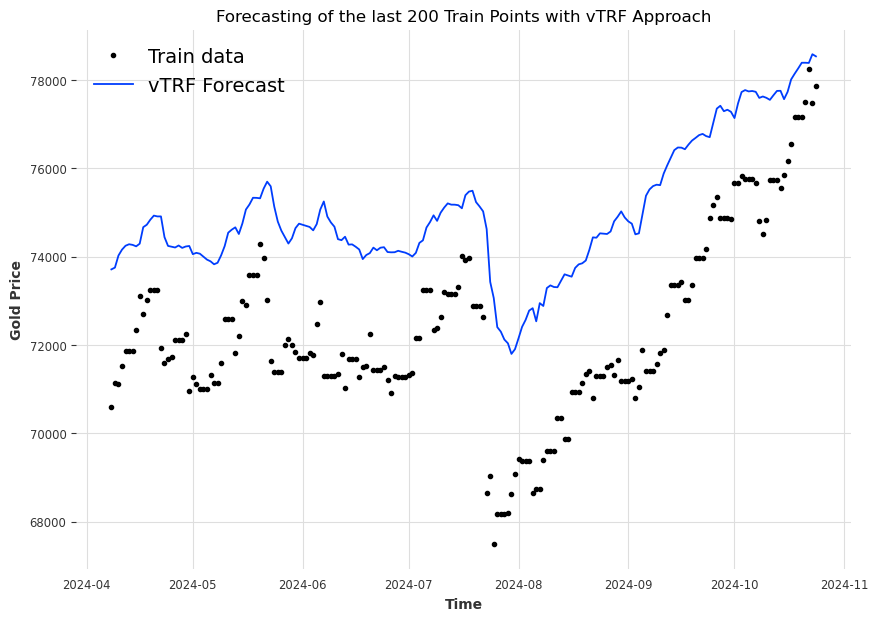

In [422]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [423]:
vtrf_train_metrics = evaluate_preds(y_pred=preds_holdout_train_vtrf,
                                      y_true=y_train[-200:])
vtrf_train_metrics

{'mae': np.float32(2672.2224),
 'mse': np.float32(7876445.0),
 'rmse': np.float32(2806.5005),
 'mape': np.float32(3.7238472)}

##### Persist Metrics

In [424]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics['mape'],
        "Val MAPE": vtrf_metrics['mape'],
        "Train RMSE": vtrf_train_metrics['rmse'],
        "Val RMSE": vtrf_metrics['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22108\276931026.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Complex Model

##### Create Model

In [426]:
model_vtrf = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=128,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=1024,
    dropout=0.2,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf.name = 'Complex Model'

model_vtrf.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 123/123 [00:12<00:00,  9.74it/s, train_loss=0.0614]  


TransformerModel(output_chunk_shift=0, d_model=128, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=1024, dropout=0.2, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [435]:
preds_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.61it/s]


##### Evaluate Predictions

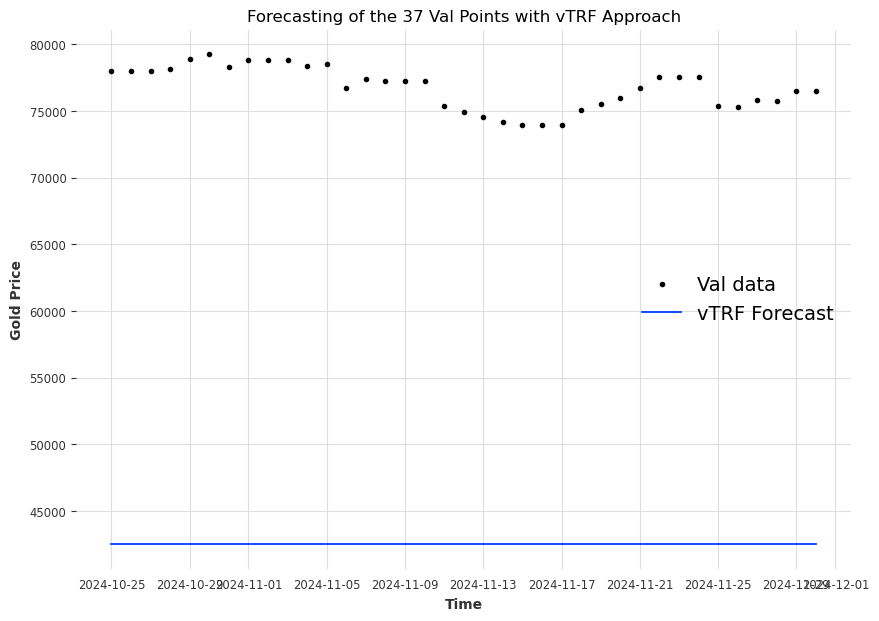

In [436]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [437]:
vtrf_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf)
vtrf_metrics

{'mae': np.float32(34233.137),
 'mse': np.float32(1174424400.0),
 'rmse': np.float32(34269.875),
 'mape': np.float32(44.577126)}

##### Evaluate Overfitting

In [438]:
preds_holdout_train_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s] 


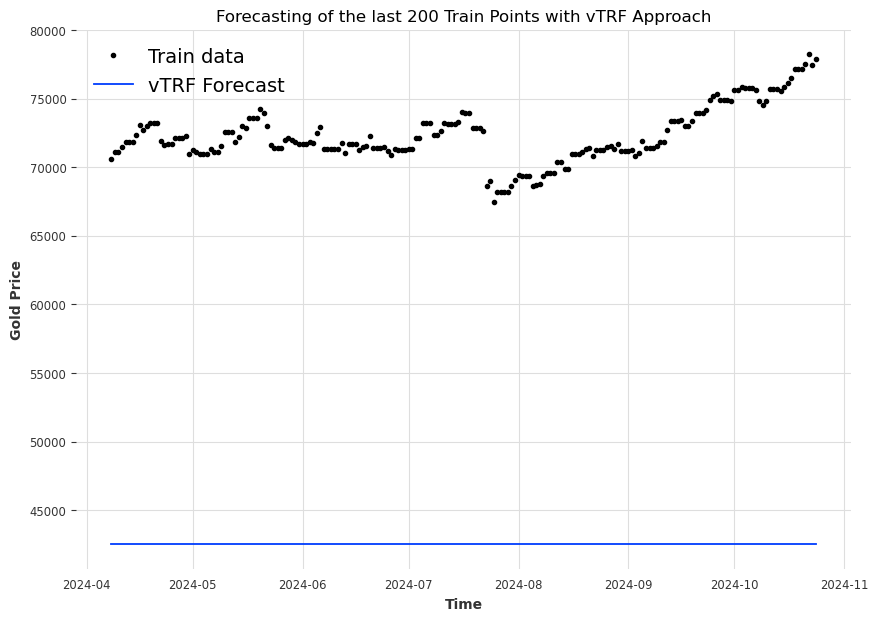

In [439]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [440]:
vtrf_train_metrics = evaluate_preds(y_pred=preds_holdout_train_vtrf,
                                      y_true=y_train[-200:])
vtrf_train_metrics

{'mae': np.float32(29784.25),
 'mse': np.float32(891225540.0),
 'rmse': np.float32(29853.4),
 'mape': np.float32(41.14645)}

##### Persist Metrics

In [441]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics['mape'],
        "Val MAPE": vtrf_metrics['mape'],
        "Train RMSE": vtrf_train_metrics['rmse'],
        "Val RMSE": vtrf_metrics['rmse']
    }])
], ignore_index=True)

#### Small Model

##### Create Model

In [446]:
model_vtrf = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=32,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf.name = 'Small Model'

model_vtrf.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 123/123 [00:02<00:00, 57.66it/s, train_loss=0.00017] 


TransformerModel(output_chunk_shift=0, d_model=32, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [447]:
preds_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.00it/s]


##### Evaluate Predictions

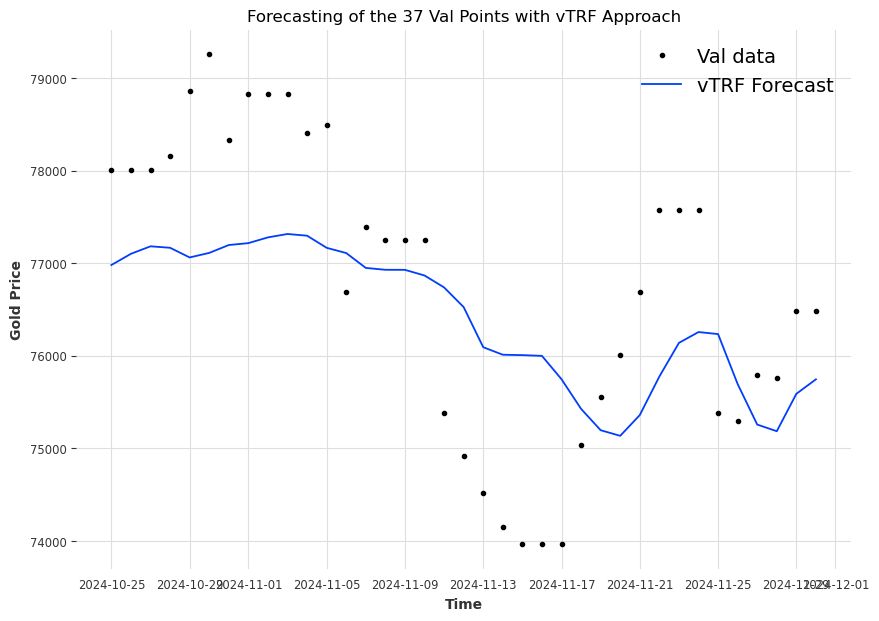

In [448]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [449]:
vtrf_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf)
vtrf_metrics

{'mae': np.float32(1124.0604),
 'mse': np.float32(1574680.1),
 'rmse': np.float32(1254.8625),
 'mape': np.float32(1.4655802)}

##### Evaluate Overfitting

In [450]:
preds_holdout_train_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.96it/s] 


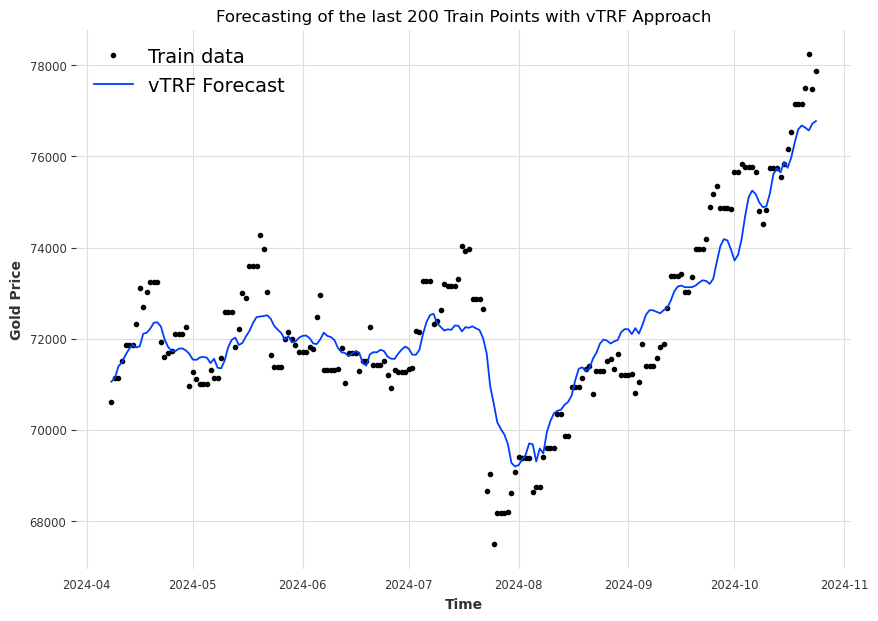

In [451]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [452]:
vtrf_train_metrics = evaluate_preds(y_pred=preds_holdout_train_vtrf,
                                      y_true=y_train[-200:])
vtrf_train_metrics

{'mae': np.float32(651.312),
 'mse': np.float32(711492.5),
 'rmse': np.float32(843.5001),
 'mape': np.float32(0.9005235)}

##### Persist Metrics

In [453]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics['mape'],
        "Val MAPE": vtrf_metrics['mape'],
        "Train RMSE": vtrf_train_metrics['rmse'],
        "Val RMSE": vtrf_metrics['rmse']
    }])
], ignore_index=True)

#### Smaller Model

##### Create Model

In [ ]:
model_vtrf = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=16,
    nhead=2,
    num_encoder_layers=1,
    num_decoder_layers=1,
    dim_feedforward=128,
    dropout=0.1,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf.name = 'Smaller Model'

model_vtrf.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 123/123 [00:01<00:00, 78.54it/s, train_loss=0.000191]


TransformerModel(output_chunk_shift=0, d_model=16, nhead=2, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [457]:
preds_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.11it/s]


##### Evaluate Predictions

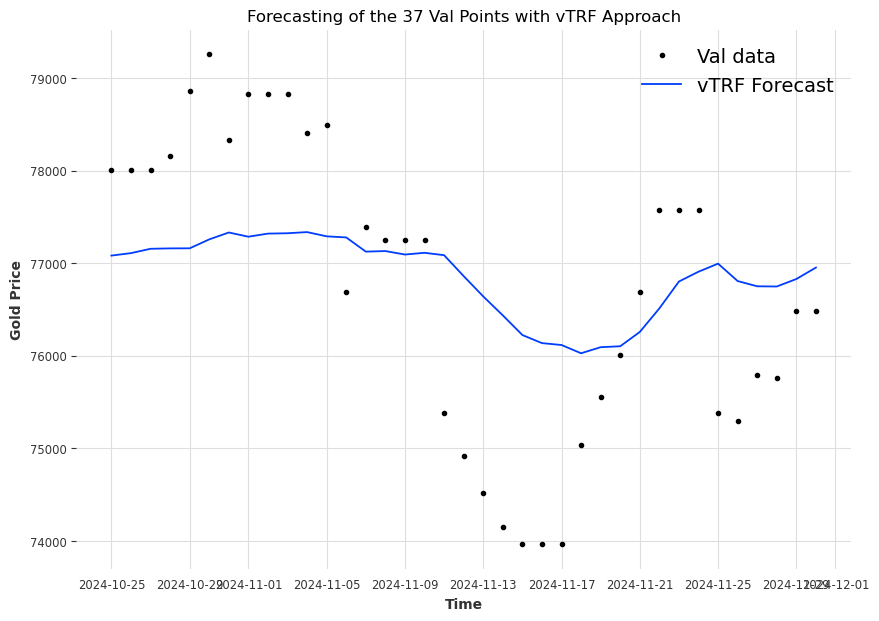

In [458]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [459]:
vtrf_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf)
vtrf_metrics

{'mae': np.float32(1123.3383),
 'mse': np.float32(1701232.2),
 'rmse': np.float32(1304.313),
 'mape': np.float32(1.4706281)}

##### Evaluate Overfitting

In [460]:
preds_holdout_train_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]


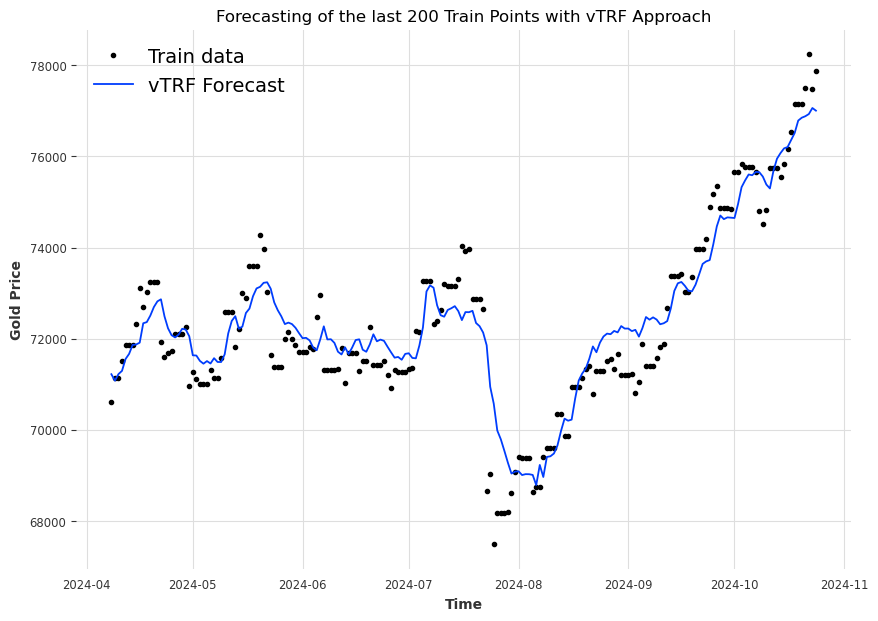

In [461]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [462]:
vtrf_train_metrics = evaluate_preds(y_pred=preds_holdout_train_vtrf,
                                      y_true=y_train[-200:])
vtrf_train_metrics

{'mae': np.float32(561.1382),
 'mse': np.float32(530372.5),
 'rmse': np.float32(728.2668),
 'mape': np.float32(0.77979517)}

##### Persist Metrics

In [463]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics['mape'],
        "Val MAPE": vtrf_metrics['mape'],
        "Train RMSE": vtrf_train_metrics['rmse'],
        "Val RMSE": vtrf_metrics['rmse']
    }])
], ignore_index=True)

#### Mix Model

##### Create Model

In [467]:
model_vtrf = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=512,
    dropout=0.2,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf.name = 'Mix Model'

model_vtrf.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 123/123 [00:02<00:00, 53.50it/s, train_loss=0.000229]


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=512, dropout=0.2, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [468]:
preds_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]


##### Evaluate Predictions

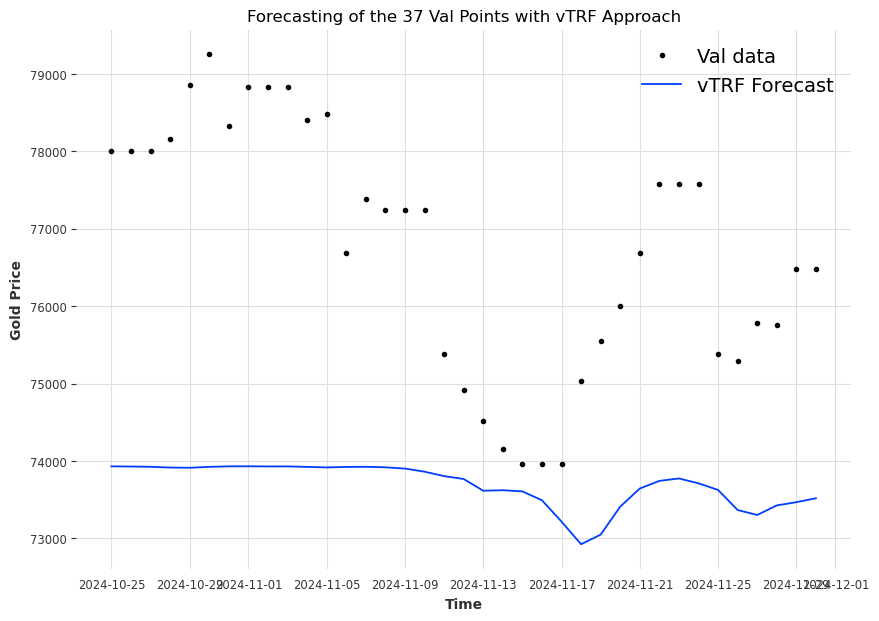

In [469]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [470]:
vtrf_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf)
vtrf_metrics

{'mae': np.float32(3058.8438),
 'mse': np.float32(11339132.0),
 'rmse': np.float32(3367.3628),
 'mape': np.float32(3.9491205)}

##### Evaluate Overfitting

In [471]:
preds_holdout_train_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.90it/s]


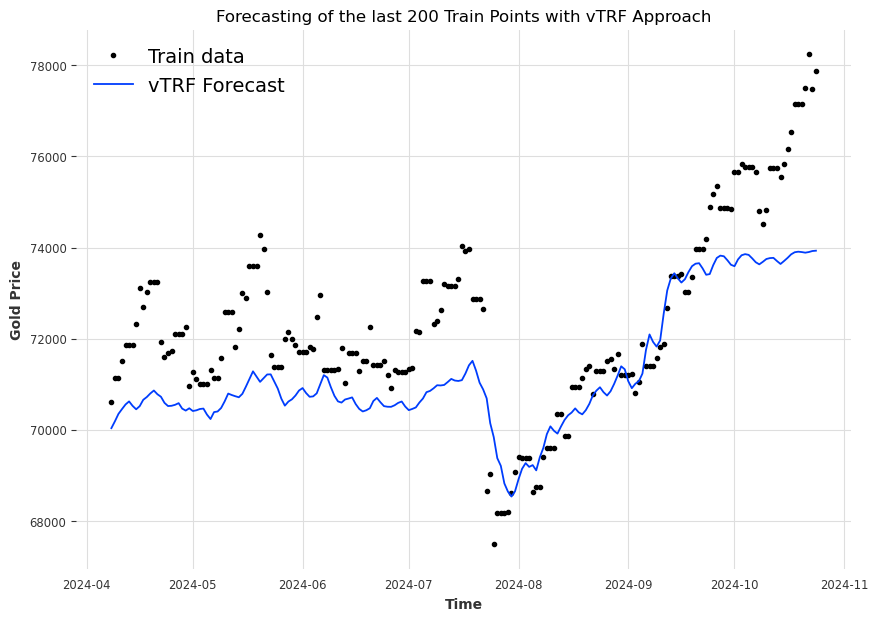

In [472]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [473]:
vtrf_train_metrics = evaluate_preds(y_pred=preds_holdout_train_vtrf,
                                      y_true=y_train[-200:])
vtrf_train_metrics

{'mae': np.float32(1212.4916),
 'mse': np.float32(2232055.5),
 'rmse': np.float32(1494.0065),
 'mape': np.float32(1.6559873)}

##### Persist Metrics

In [474]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics['mape'],
        "Val MAPE": vtrf_metrics['mape'],
        "Train RMSE": vtrf_train_metrics['rmse'],
        "Val RMSE": vtrf_metrics['rmse']
    }])
], ignore_index=True)

#### Early Stopping Small Model

##### Create Model

In [476]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_vtrf = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=32,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    activation='relu',
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_vtrf.name = 'Early Stopping Small Model'

model_vtrf.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 73: 100%|██████████| 123/123 [00:02<00:00, 47.13it/s, train_loss=0.000233]


TransformerModel(output_chunk_shift=0, d_model=32, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A5849CA90>]})

##### Make Predictions

In [477]:
preds_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s] 


##### Evaluate Predictions

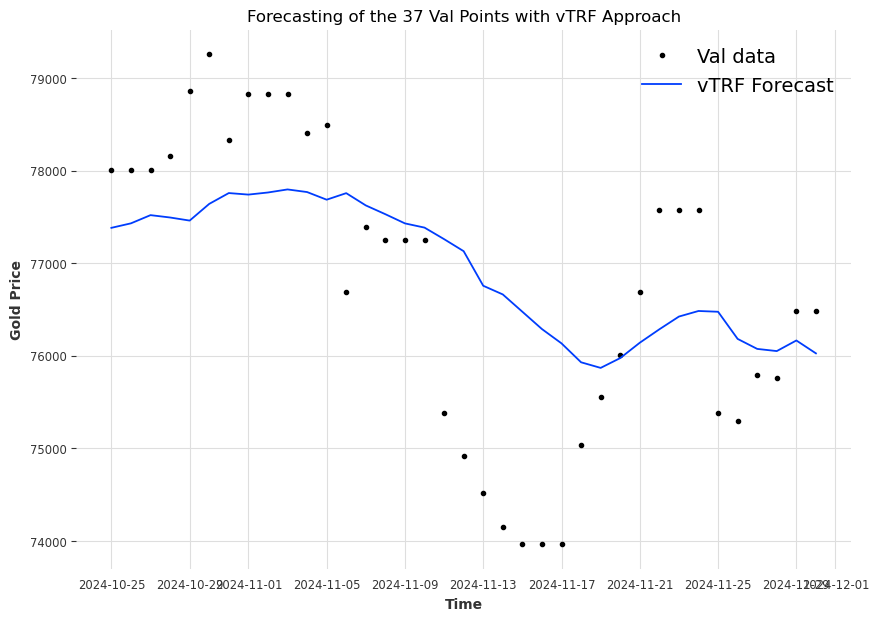

In [478]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [479]:
vtrf_metrics = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf)
vtrf_metrics

{'mae': np.float32(999.92084),
 'mse': np.float32(1516732.0),
 'rmse': np.float32(1231.5568),
 'mape': np.float32(1.312794)}

##### Evaluate Overfitting

In [480]:
preds_holdout_train_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.21it/s]


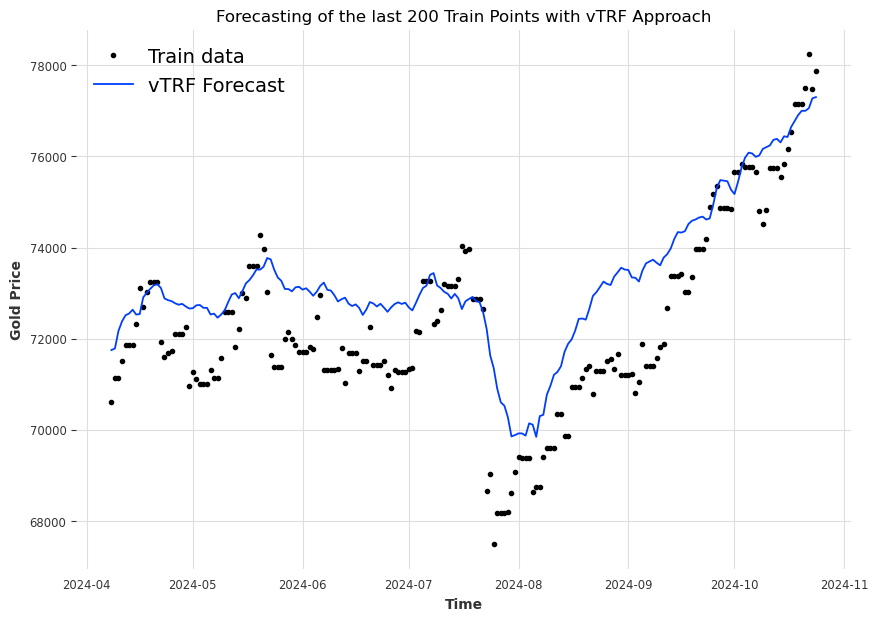

In [481]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [482]:
vtrf_train_metrics = evaluate_preds(y_pred=preds_holdout_train_vtrf,
                                      y_true=y_train[-200:])
vtrf_train_metrics

{'mae': np.float32(1073.914),
 'mse': np.float32(1664081.2),
 'rmse': np.float32(1289.9927),
 'mape': np.float32(1.5036279)}

##### Persist Metrics

In [483]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics['mape'],
        "Val MAPE": vtrf_metrics['mape'],
        "Train RMSE": vtrf_train_metrics['rmse'],
        "Val RMSE": vtrf_metrics['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [484]:
df_models_metrics_vtrf

Model  Train MAPE   Val MAPE    Train RMSE  \
0               Default Model    3.723847   0.665244   2806.500488   
1               Complex Model   41.146450   0.665244  29853.400391   
2               Complex Model   41.146450  44.577126  29853.400391   
3                 Small Model    0.900523   1.465580    843.500122   
4                 Small Model    0.779795   1.470628    728.266785   
5                   Mix Model    1.655987   3.949121   1494.006470   
6  Early Stopping Small Model    1.503628   1.312794   1289.992676   

       Val RMSE  
0    723.506348  
1    723.506348  
2  34269.875000  
3   1254.862549  
4   1304.312988  
5   3367.362793  
6   1231.556763

In [485]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_vtrf = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=32,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    activation='relu',
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_vtrf.fit(gold_price_darts_scaled_train_val, past_covariates=gold_price_exogenus_darts_scaled_train_val)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 119: 100%|██████████| 124/124 [00:02<00:00, 56.59it/s, train_loss=8.5e-5]  


TransformerModel(output_chunk_shift=0, d_model=32, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023A77285FF0>]})

In [486]:
preds_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.92it/s] 


In [487]:
vtrf_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_vtrf)
vtrf_metrics

{'mae': np.float32(618.549),
 'mse': np.float32(549485.4),
 'rmse': np.float32(741.2728),
 'mape': np.float32(0.81209904)}

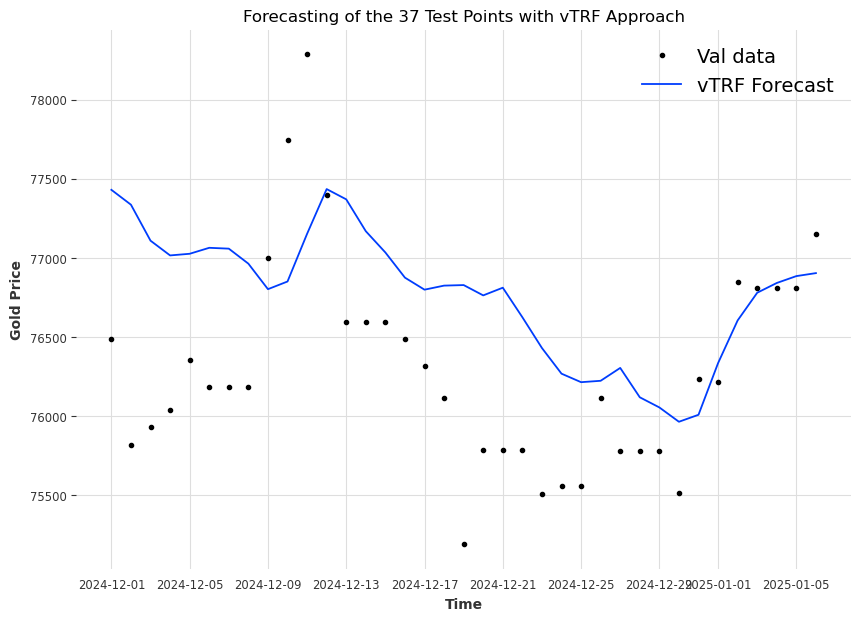

In [488]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with vTRF Approach')
plt.show()

### PatchTST

### Prophet

### GAT (Graph Attention Network)